In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if "foreground" in test:
    members= pd.read_pickle('/home/cz136/project/sa/data/{}/{}/{}.pkl'.format(shape_cat,vol,test))
elif "background" in test:
    members= pd.read_pickle('/home/cz136/project/sa/data/{}/{}/{}.pkl'.format(shape_cat,vol,test))
elif test=="":
    pass
else:
    raise TypeError

In [5]:
if vol!="uber":
    members=shapes

In [6]:
if quantile!="":
    i=int(quantile)

In [7]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [8]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [9]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [10]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [11]:
NBINS=10

In [12]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [13]:
len(shapes)

1079244

In [14]:
len(members)

491627

In [15]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [16]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [17]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [18]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [19]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:01,  1.90s/it]

4it [00:02,  1.34s/it]

7it [00:02,  1.05it/s]

10it [00:02,  1.48it/s]

13it [00:02,  2.06it/s]

16it [00:02,  2.83it/s]

19it [00:02,  3.85it/s]

23it [00:02,  5.21it/s]

26it [00:02,  6.88it/s]

30it [00:02,  8.98it/s]

34it [00:03, 11.43it/s]

38it [00:03, 13.95it/s]

42it [00:03, 16.54it/s]

45it [00:03, 18.99it/s]

48it [00:03, 20.84it/s]

52it [00:03, 23.27it/s]

56it [00:03, 25.35it/s]

60it [00:04, 26.44it/s]

63it [00:04, 27.19it/s]

67it [00:04, 28.15it/s]

70it [00:04, 28.36it/s]

73it [00:04, 28.45it/s]

76it [00:04, 28.47it/s]

79it [00:04, 27.76it/s]

82it [00:04, 27.74it/s]

85it [00:04, 27.71it/s]

88it [00:04, 27.87it/s]

92it [00:05, 28.87it/s]

95it [00:05, 28.58it/s]

98it [00:05, 28.74it/s]

102it [00:05, 29.04it/s]

106it [00:05, 29.69it/s]

110it [00:05, 30.49it/s]

114it [00:05, 30.37it/s]

118it [00:05, 30.64it/s]

122it [00:06, 30.58it/s]

126it [00:06, 31.27it/s]

130it [00:06, 30.56it/s]

134it [00:06, 30.72it/s]

138it [00:06, 30.55it/s]

142it [00:06, 29.59it/s]

145it [00:06, 29.02it/s]

148it [00:06, 29.04it/s]

151it [00:07, 29.30it/s]

155it [00:07, 30.33it/s]

159it [00:07, 29.86it/s]

163it [00:07, 30.52it/s]

167it [00:07, 29.81it/s]

170it [00:07, 28.68it/s]

174it [00:07, 29.77it/s]

177it [00:07, 29.30it/s]

181it [00:08, 29.82it/s]

185it [00:08, 30.48it/s]

189it [00:08, 30.09it/s]

193it [00:08, 30.02it/s]

197it [00:08, 30.08it/s]

201it [00:08, 30.08it/s]

205it [00:08, 30.12it/s]

209it [00:08, 30.29it/s]

213it [00:09, 29.34it/s]

216it [00:09, 29.16it/s]

220it [00:09, 29.29it/s]

223it [00:09, 29.17it/s]

227it [00:09, 30.18it/s]

231it [00:09, 29.32it/s]

235it [00:09, 29.04it/s]

238it [00:09, 29.02it/s]

242it [00:10, 29.65it/s]

246it [00:10, 30.56it/s]

250it [00:10, 30.77it/s]

254it [00:10, 30.58it/s]

258it [00:10, 30.15it/s]

262it [00:10, 29.56it/s]

266it [00:10, 29.97it/s]

270it [00:11, 29.78it/s]

274it [00:11, 29.33it/s]

277it [00:11, 28.87it/s]

280it [00:11, 28.87it/s]

284it [00:11, 29.56it/s]

288it [00:11, 30.12it/s]

292it [00:11, 29.08it/s]

296it [00:11, 29.73it/s]

299it [00:12, 28.53it/s]

302it [00:12, 28.55it/s]

306it [00:12, 28.28it/s]

309it [00:12, 28.38it/s]

312it [00:12, 28.49it/s]

316it [00:12, 30.02it/s]

320it [00:12, 31.61it/s]

324it [00:12, 31.51it/s]

328it [00:13, 31.04it/s]

332it [00:13, 30.40it/s]

336it [00:13, 30.08it/s]

340it [00:13, 29.61it/s]

343it [00:13, 29.00it/s]

346it [00:13, 28.06it/s]

349it [00:13, 27.46it/s]

352it [00:13, 27.75it/s]

355it [00:13, 27.08it/s]

359it [00:14, 28.73it/s]

363it [00:14, 29.49it/s]

367it [00:14, 30.06it/s]

371it [00:14, 29.92it/s]

375it [00:14, 30.19it/s]

379it [00:14, 30.21it/s]

383it [00:14, 29.50it/s]

386it [00:15, 28.26it/s]

390it [00:15, 29.55it/s]

394it [00:15, 30.66it/s]

398it [00:15, 29.72it/s]

401it [00:15, 29.47it/s]

404it [00:15, 28.95it/s]

407it [00:15, 28.49it/s]

410it [00:15, 28.46it/s]

413it [00:15, 28.78it/s]

417it [00:16, 29.15it/s]

421it [00:16, 30.11it/s]

425it [00:16, 30.23it/s]

429it [00:16, 30.65it/s]

433it [00:16, 30.99it/s]

437it [00:16, 31.37it/s]

441it [00:16, 30.91it/s]

445it [00:16, 30.93it/s]

449it [00:17, 29.63it/s]

452it [00:17, 29.29it/s]

455it [00:17, 29.31it/s]

459it [00:17, 29.74it/s]

462it [00:17, 28.77it/s]

466it [00:17, 29.38it/s]

469it [00:17, 29.07it/s]

472it [00:17, 28.94it/s]

475it [00:17, 28.88it/s]

479it [00:18, 29.70it/s]

483it [00:18, 30.95it/s]

487it [00:18, 30.44it/s]

491it [00:18, 30.73it/s]

495it [00:18, 30.88it/s]

499it [00:18, 29.86it/s]

502it [00:18, 29.21it/s]

505it [00:18, 27.89it/s]

509it [00:19, 29.00it/s]

513it [00:19, 29.57it/s]

516it [00:19, 28.92it/s]

520it [00:19, 29.26it/s]

524it [00:19, 29.44it/s]

527it [00:19, 28.90it/s]

531it [00:19, 29.67it/s]

534it [00:19, 28.34it/s]

538it [00:20, 28.86it/s]

541it [00:20, 28.16it/s]

545it [00:20, 29.36it/s]

549it [00:20, 30.14it/s]

553it [00:20, 30.17it/s]

557it [00:20, 31.18it/s]

561it [00:20, 30.46it/s]

565it [00:20, 31.04it/s]

569it [00:21, 30.45it/s]

573it [00:21, 30.11it/s]

577it [00:21, 30.27it/s]

581it [00:21, 29.92it/s]

585it [00:21, 30.37it/s]

589it [00:21, 29.79it/s]

593it [00:21, 30.09it/s]

597it [00:22, 29.79it/s]

601it [00:22, 30.41it/s]

605it [00:22, 31.66it/s]

609it [00:22, 31.18it/s]

613it [00:22, 30.92it/s]

617it [00:22, 30.05it/s]

621it [00:22, 30.61it/s]

625it [00:22, 31.22it/s]

629it [00:23, 32.04it/s]

633it [00:23, 31.83it/s]

637it [00:23, 31.46it/s]

641it [00:23, 30.94it/s]

645it [00:23, 29.84it/s]

649it [00:23, 30.28it/s]

653it [00:23, 30.17it/s]

657it [00:23, 30.13it/s]

661it [00:24, 30.34it/s]

665it [00:24, 30.39it/s]

669it [00:24, 30.96it/s]

673it [00:24, 31.45it/s]

677it [00:24, 30.73it/s]

681it [00:24, 31.30it/s]

685it [00:24, 32.10it/s]

689it [00:25, 32.25it/s]

693it [00:25, 32.61it/s]

697it [00:25, 32.35it/s]

701it [00:25, 32.16it/s]

705it [00:25, 32.07it/s]

709it [00:25, 30.95it/s]

713it [00:25, 30.78it/s]

717it [00:25, 31.46it/s]

721it [00:26, 32.48it/s]

725it [00:26, 33.09it/s]

729it [00:26, 32.19it/s]

733it [00:26, 32.69it/s]

737it [00:26, 32.32it/s]

741it [00:26, 32.36it/s]

745it [00:26, 31.67it/s]

749it [00:26, 31.31it/s]

753it [00:27, 30.55it/s]

757it [00:27, 30.15it/s]

761it [00:27, 31.39it/s]

765it [00:27, 32.01it/s]

769it [00:27, 32.43it/s]

773it [00:27, 33.24it/s]

777it [00:27, 33.28it/s]

781it [00:27, 32.82it/s]

785it [00:27, 32.72it/s]

789it [00:28, 33.59it/s]

793it [00:28, 34.57it/s]

797it [00:28, 33.46it/s]

801it [00:28, 33.13it/s]

805it [00:28, 32.76it/s]

809it [00:28, 33.84it/s]

813it [00:28, 34.00it/s]

817it [00:28, 34.59it/s]

821it [00:29, 34.32it/s]

825it [00:29, 34.79it/s]

829it [00:29, 34.41it/s]

833it [00:29, 33.88it/s]

837it [00:29, 34.10it/s]

841it [00:29, 34.70it/s]

845it [00:29, 35.12it/s]

849it [00:29, 35.65it/s]

853it [00:29, 34.79it/s]

857it [00:30, 33.94it/s]

861it [00:30, 34.36it/s]

865it [00:30, 35.14it/s]

869it [00:30, 35.77it/s]

873it [00:30, 33.95it/s]

877it [00:30, 32.49it/s]

881it [00:30, 33.21it/s]

885it [00:30, 33.19it/s]

889it [00:31, 34.34it/s]

893it [00:31, 35.00it/s]

897it [00:31, 34.03it/s]

901it [00:31, 35.13it/s]

905it [00:31, 36.05it/s]

909it [00:31, 35.96it/s]

913it [00:31, 36.76it/s]

917it [00:31, 36.95it/s]

921it [00:31, 36.98it/s]

925it [00:32, 35.86it/s]

929it [00:32, 36.72it/s]

933it [00:32, 37.18it/s]

937it [00:32, 37.00it/s]

941it [00:32, 35.68it/s]

945it [00:32, 35.66it/s]

949it [00:32, 34.06it/s]

953it [00:32, 35.26it/s]

957it [00:32, 34.28it/s]

961it [00:33, 35.12it/s]

965it [00:33, 34.08it/s]

969it [00:33, 34.58it/s]

973it [00:33, 35.65it/s]

977it [00:33, 34.60it/s]

981it [00:33, 33.83it/s]

985it [00:33, 33.93it/s]

989it [00:33, 35.10it/s]

993it [00:33, 34.94it/s]

997it [00:34, 34.07it/s]

1001it [00:34, 35.22it/s]

1005it [00:34, 36.49it/s]

1009it [00:34, 36.00it/s]

1013it [00:34, 35.07it/s]

1017it [00:34, 36.02it/s]

1021it [00:34, 36.42it/s]

1025it [00:34, 37.09it/s]

1029it [00:34, 36.09it/s]

1033it [00:35, 37.01it/s]

1037it [00:35, 37.31it/s]

1041it [00:35, 37.54it/s]

1045it [00:35, 37.17it/s]

1049it [00:35, 37.42it/s]

1053it [00:35, 36.02it/s]

1057it [00:35, 36.53it/s]

1061it [00:35, 36.82it/s]

1065it [00:35, 36.40it/s]

1069it [00:36, 35.26it/s]

1073it [00:36, 35.61it/s]

1077it [00:36, 34.53it/s]

1081it [00:36, 34.58it/s]

1085it [00:36, 34.20it/s]

1089it [00:36, 34.65it/s]

1093it [00:36, 35.65it/s]

1097it [00:36, 36.54it/s]

1101it [00:36, 36.97it/s]

1105it [00:37, 37.10it/s]

1110it [00:37, 39.69it/s]

1116it [00:37, 43.85it/s]

1121it [00:37, 41.57it/s]

1126it [00:37, 40.77it/s]

1131it [00:37, 40.24it/s]

1136it [00:37, 38.89it/s]

1140it [00:37, 37.01it/s]

1144it [00:38, 35.82it/s]

1148it [00:38, 34.92it/s]

1152it [00:38, 33.77it/s]

1156it [00:38, 34.26it/s]

1160it [00:38, 33.28it/s]

1164it [00:38, 34.35it/s]

1168it [00:38, 34.42it/s]

1172it [00:38, 35.82it/s]

1176it [00:38, 36.08it/s]

1180it [00:39, 34.55it/s]

1184it [00:39, 35.23it/s]

1188it [00:39, 36.14it/s]

1193it [00:39, 37.40it/s]

1197it [00:39, 35.61it/s]

1201it [00:39, 36.01it/s]

1205it [00:39, 36.24it/s]

1209it [00:39, 35.97it/s]

1213it [00:40, 34.59it/s]

1217it [00:40, 33.52it/s]

1221it [00:40, 35.04it/s]

1225it [00:40, 34.27it/s]

1229it [00:40, 32.81it/s]

1233it [00:40, 34.01it/s]

1237it [00:40, 33.80it/s]

1241it [00:40, 33.97it/s]

1245it [00:40, 33.31it/s]

1249it [00:41, 33.69it/s]

1253it [00:41, 34.83it/s]

1257it [00:41, 35.36it/s]

1261it [00:41, 34.25it/s]

1265it [00:41, 34.56it/s]

1269it [00:41, 34.95it/s]

1273it [00:41, 35.15it/s]

1277it [00:41, 36.26it/s]

1281it [00:41, 37.00it/s]

1285it [00:42, 37.45it/s]

1289it [00:42, 37.32it/s]

1293it [00:42, 36.47it/s]

1298it [00:42, 38.29it/s]

1304it [00:42, 41.75it/s]

1309it [00:42, 40.09it/s]

1314it [00:42, 39.48it/s]

1319it [00:42, 37.05it/s]

1323it [00:43, 35.07it/s]

1327it [00:43, 33.57it/s]

1331it [00:43, 34.82it/s]

1335it [00:43, 35.47it/s]

1339it [00:43, 36.45it/s]

1343it [00:43, 36.45it/s]

1347it [00:43, 37.03it/s]

1351it [00:43, 37.18it/s]

1355it [00:43, 36.86it/s]

1359it [00:44, 36.09it/s]

1363it [00:44, 36.13it/s]

1367it [00:44, 35.59it/s]

1371it [00:44, 36.48it/s]

1375it [00:44, 37.34it/s]

1379it [00:44, 37.65it/s]

1383it [00:44, 37.64it/s]

1387it [00:44, 37.40it/s]

1391it [00:44, 37.83it/s]

1395it [00:45, 37.49it/s]

1399it [00:45, 37.26it/s]

1403it [00:45, 35.49it/s]

1407it [00:45, 36.49it/s]

1411it [00:45, 35.74it/s]

1415it [00:45, 35.07it/s]

1419it [00:45, 35.93it/s]

1423it [00:45, 36.52it/s]

1427it [00:45, 36.58it/s]

1431it [00:46, 37.51it/s]

1435it [00:46, 38.03it/s]

1439it [00:46, 38.39it/s]

1443it [00:46, 38.72it/s]

1447it [00:46, 38.77it/s]

1451it [00:46, 35.57it/s]

1455it [00:46, 35.01it/s]

1459it [00:46, 35.44it/s]

1463it [00:46, 36.44it/s]

1467it [00:46, 37.00it/s]

1471it [00:47, 37.05it/s]

1475it [00:47, 34.90it/s]

1479it [00:47, 35.62it/s]

1483it [00:47, 36.60it/s]

1487it [00:47, 37.36it/s]

1491it [00:47, 37.67it/s]

1495it [00:47, 38.03it/s]

1499it [00:47, 36.94it/s]

1503it [00:47, 37.54it/s]

1507it [00:48, 37.64it/s]

1512it [00:48, 37.67it/s]

1516it [00:48, 37.91it/s]

1520it [00:48, 38.12it/s]

1524it [00:48, 38.32it/s]

1528it [00:48, 36.50it/s]

1532it [00:48, 36.42it/s]

1536it [00:48, 36.55it/s]

1540it [00:48, 37.14it/s]

1544it [00:49, 35.57it/s]

1548it [00:49, 36.37it/s]

1552it [00:49, 36.94it/s]

1556it [00:49, 35.90it/s]

1560it [00:49, 35.92it/s]

1564it [00:49, 35.11it/s]

1568it [00:49, 34.45it/s]

1572it [00:49, 34.78it/s]

1576it [00:49, 35.68it/s]

1580it [00:50, 35.59it/s]

1584it [00:50, 35.83it/s]

1588it [00:50, 35.89it/s]

1592it [00:50, 35.74it/s]

1596it [00:50, 36.01it/s]

1600it [00:50, 35.25it/s]

1604it [00:50, 35.67it/s]

1608it [00:50, 36.58it/s]

1612it [00:50, 37.29it/s]

1616it [00:51, 36.75it/s]

1621it [00:51, 37.69it/s]

1625it [00:51, 37.22it/s]

1629it [00:51, 37.57it/s]

1633it [00:51, 37.50it/s]

1637it [00:51, 37.75it/s]

1641it [00:51, 36.48it/s]

1645it [00:51, 35.49it/s]

1649it [00:51, 36.21it/s]

1653it [00:52, 37.03it/s]

1657it [00:52, 36.26it/s]

1661it [00:52, 35.31it/s]

1665it [00:52, 36.42it/s]

1669it [00:52, 35.94it/s]

1673it [00:52, 36.77it/s]

1677it [00:52, 37.01it/s]

1681it [00:52, 35.24it/s]

1685it [00:52, 35.67it/s]

1689it [00:53, 36.34it/s]

1693it [00:53, 35.54it/s]

1697it [00:53, 36.45it/s]

1701it [00:53, 36.66it/s]

1705it [00:53, 35.52it/s]

1709it [00:53, 34.43it/s]

1713it [00:53, 34.11it/s]

1717it [00:53, 35.06it/s]

1721it [00:53, 35.53it/s]

1725it [00:54, 34.35it/s]

1729it [00:54, 35.48it/s]

1733it [00:54, 36.22it/s]

1737it [00:54, 36.56it/s]

1741it [00:54, 36.94it/s]

1745it [00:54, 37.04it/s]

1749it [00:54, 37.71it/s]

1753it [00:54, 36.97it/s]

1757it [00:54, 36.19it/s]

1761it [00:55, 34.65it/s]

1765it [00:55, 34.91it/s]

1769it [00:55, 34.19it/s]

1773it [00:55, 34.66it/s]

1777it [00:55, 35.20it/s]

1781it [00:55, 35.59it/s]

1785it [00:55, 35.26it/s]

1789it [00:55, 35.71it/s]

1793it [00:56, 35.68it/s]

1797it [00:56, 34.70it/s]

1801it [00:56, 35.27it/s]

1805it [00:56, 34.36it/s]

1809it [00:56, 33.83it/s]

1813it [00:56, 34.03it/s]

1817it [00:56, 34.96it/s]

1821it [00:56, 35.80it/s]

1825it [00:56, 36.14it/s]

1829it [00:57, 36.50it/s]

1833it [00:57, 35.34it/s]

1837it [00:57, 35.64it/s]

1841it [00:57, 35.03it/s]

1845it [00:57, 34.33it/s]

1849it [00:57, 35.56it/s]

1853it [00:57, 34.42it/s]

1857it [00:57, 33.44it/s]

1861it [00:57, 33.60it/s]

1865it [00:58, 33.87it/s]

1869it [00:58, 33.42it/s]

1873it [00:58, 34.18it/s]

1877it [00:58, 34.80it/s]

1881it [00:58, 33.83it/s]

1885it [00:58, 34.66it/s]

1889it [00:58, 35.61it/s]

1893it [00:58, 36.60it/s]

1897it [00:58, 36.99it/s]

1901it [00:59, 37.27it/s]

1905it [00:59, 36.74it/s]

1909it [00:59, 35.76it/s]

1913it [00:59, 35.65it/s]

1917it [00:59, 34.33it/s]

1921it [00:59, 34.32it/s]

1925it [00:59, 35.69it/s]

1929it [00:59, 34.89it/s]

1933it [01:00, 34.87it/s]

1937it [01:00, 35.97it/s]

1941it [01:00, 34.64it/s]

1945it [01:00, 34.06it/s]

1949it [01:00, 34.36it/s]

1953it [01:00, 34.07it/s]

1957it [01:00, 33.59it/s]

1961it [01:00, 34.55it/s]

1965it [01:00, 33.83it/s]

1969it [01:01, 33.86it/s]

1973it [01:01, 34.75it/s]

1977it [01:01, 35.38it/s]

1981it [01:01, 36.12it/s]

1985it [01:01, 36.60it/s]

1989it [01:01, 36.83it/s]

1993it [01:01, 37.48it/s]

1998it [01:01, 38.88it/s]

2002it [01:01, 38.82it/s]

2006it [01:02, 38.53it/s]

2010it [01:02, 37.14it/s]

2014it [01:02, 36.71it/s]

2018it [01:02, 35.29it/s]

2022it [01:02, 35.62it/s]

2026it [01:02, 34.95it/s]

2030it [01:02, 34.43it/s]

2034it [01:02, 33.87it/s]

2038it [01:02, 33.66it/s]

2042it [01:03, 33.12it/s]

2046it [01:03, 32.48it/s]

2050it [01:03, 33.97it/s]

2054it [01:03, 35.01it/s]

2058it [01:03, 34.24it/s]

2062it [01:03, 34.54it/s]

2066it [01:03, 35.38it/s]

2070it [01:03, 35.69it/s]

2074it [01:04, 34.75it/s]

2078it [01:04, 33.59it/s]

2082it [01:04, 33.82it/s]

2086it [01:04, 34.57it/s]

2090it [01:04, 34.01it/s]

2094it [01:04, 33.11it/s]

2098it [01:04, 33.75it/s]

2102it [01:04, 34.61it/s]

2106it [01:04, 35.56it/s]

2110it [01:05, 35.49it/s]

2114it [01:05, 36.23it/s]

2118it [01:05, 35.01it/s]

2122it [01:05, 35.99it/s]

2126it [01:05, 36.39it/s]

2130it [01:05, 34.90it/s]

2134it [01:05, 35.49it/s]

2138it [01:05, 36.00it/s]

2142it [01:05, 36.04it/s]

2146it [01:06, 35.75it/s]

2150it [01:06, 35.27it/s]

2154it [01:06, 34.07it/s]

2158it [01:06, 33.17it/s]

2162it [01:06, 32.86it/s]

2166it [01:06, 32.35it/s]

2170it [01:06, 31.70it/s]

2174it [01:06, 33.16it/s]

2178it [01:07, 32.49it/s]

2182it [01:07, 33.25it/s]

2186it [01:07, 34.22it/s]

2190it [01:07, 35.07it/s]

2194it [01:07, 35.68it/s]

2198it [01:07, 36.71it/s]

2202it [01:07, 36.12it/s]

2206it [01:07, 36.28it/s]

2210it [01:07, 36.32it/s]

2214it [01:08, 35.52it/s]

2218it [01:08, 35.48it/s]

2222it [01:08, 34.39it/s]

2226it [01:08, 35.72it/s]

2230it [01:08, 36.69it/s]

2234it [01:08, 36.21it/s]

2238it [01:08, 36.11it/s]

2242it [01:08, 35.62it/s]

2246it [01:08, 35.69it/s]

2250it [01:09, 33.94it/s]

2254it [01:09, 34.96it/s]

2258it [01:09, 34.90it/s]

2262it [01:09, 34.50it/s]

2266it [01:09, 32.91it/s]

2270it [01:09, 32.43it/s]

2274it [01:09, 31.84it/s]

2278it [01:09, 32.34it/s]

2282it [01:10, 33.09it/s]

2286it [01:10, 34.52it/s]

2290it [01:10, 35.53it/s]

2294it [01:10, 35.57it/s]

2298it [01:10, 34.34it/s]

2302it [01:10, 34.46it/s]

2306it [01:10, 33.06it/s]

2310it [01:10, 34.04it/s]

2314it [01:10, 34.74it/s]

2318it [01:11, 35.33it/s]

2322it [01:11, 36.19it/s]

2326it [01:11, 36.08it/s]

2330it [01:11, 36.67it/s]

2334it [01:11, 36.31it/s]

2338it [01:11, 36.90it/s]

2342it [01:11, 37.03it/s]

2346it [01:11, 35.46it/s]

2350it [01:11, 34.91it/s]

2354it [01:12, 34.29it/s]

2358it [01:12, 33.90it/s]

2362it [01:12, 33.86it/s]

2366it [01:12, 34.58it/s]

2370it [01:12, 35.17it/s]

2374it [01:12, 33.34it/s]

2378it [01:12, 32.10it/s]

2382it [01:12, 32.05it/s]

2386it [01:13, 31.91it/s]

2390it [01:13, 32.97it/s]

2394it [01:13, 34.08it/s]

2398it [01:13, 34.41it/s]

2402it [01:13, 34.11it/s]

2406it [01:13, 34.47it/s]

2410it [01:13, 35.23it/s]

2414it [01:13, 35.93it/s]

2418it [01:13, 36.31it/s]

2422it [01:14, 34.51it/s]

2426it [01:14, 33.39it/s]

2430it [01:14, 33.45it/s]

2434it [01:14, 34.28it/s]

2438it [01:14, 34.73it/s]

2442it [01:14, 34.72it/s]

2446it [01:14, 34.56it/s]

2452it [01:14, 38.34it/s]

2456it [01:15, 36.93it/s]

2460it [01:15, 34.70it/s]

2464it [01:15, 35.50it/s]

2468it [01:15, 35.48it/s]

2472it [01:15, 34.25it/s]

2476it [01:15, 33.78it/s]

2480it [01:15, 33.00it/s]

2484it [01:15, 33.64it/s]

2489it [01:15, 36.28it/s]

2494it [01:16, 37.52it/s]

2499it [01:16, 38.31it/s]

2504it [01:16, 40.53it/s]

2509it [01:16, 42.18it/s]

2514it [01:16, 43.18it/s]

2519it [01:16, 44.16it/s]

2524it [01:16, 45.04it/s]

2529it [01:16, 44.92it/s]

2534it [01:16, 43.14it/s]

2539it [01:17, 42.33it/s]

2544it [01:17, 43.91it/s]

2549it [01:17, 43.62it/s]

2554it [01:17, 45.02it/s]

2559it [01:17, 45.71it/s]

2564it [01:17, 43.53it/s]

2569it [01:17, 42.10it/s]

2574it [01:17, 43.30it/s]

2579it [01:17, 44.67it/s]

2584it [01:18, 43.35it/s]

2589it [01:18, 43.15it/s]

2594it [01:18, 44.47it/s]

2599it [01:18, 45.18it/s]

2604it [01:18, 45.68it/s]

2609it [01:18, 43.72it/s]

2614it [01:18, 45.08it/s]

2619it [01:18, 43.67it/s]

2625it [01:19, 45.56it/s]

2630it [01:19, 46.44it/s]

2635it [01:19, 44.81it/s]

2640it [01:19, 45.92it/s]

2645it [01:19, 46.93it/s]

2650it [01:19, 44.18it/s]

2655it [01:19, 42.94it/s]

2661it [01:19, 44.89it/s]

2666it [01:19, 45.76it/s]

2671it [01:20, 46.72it/s]

2676it [01:20, 46.97it/s]

2681it [01:20, 46.36it/s]

2686it [01:20, 46.17it/s]

2691it [01:20, 45.54it/s]

2696it [01:20, 43.55it/s]

2701it [01:20, 44.68it/s]

2706it [01:20, 44.75it/s]

2711it [01:20, 45.91it/s]

2716it [01:21, 45.90it/s]

2721it [01:21, 45.06it/s]

2726it [01:21, 45.29it/s]

2731it [01:21, 46.01it/s]

2736it [01:21, 45.68it/s]

2741it [01:21, 46.42it/s]

2746it [01:21, 46.90it/s]

2751it [01:21, 44.97it/s]

2756it [01:21, 45.71it/s]

2761it [01:22, 44.93it/s]

2766it [01:22, 44.86it/s]

2771it [01:22, 45.95it/s]

2776it [01:22, 46.79it/s]

2781it [01:22, 47.52it/s]

2786it [01:22, 46.70it/s]

2791it [01:22, 47.33it/s]

2796it [01:22, 47.47it/s]

2801it [01:22, 47.97it/s]

2806it [01:22, 47.97it/s]

2811it [01:23, 48.11it/s]

2816it [01:23, 48.33it/s]

2821it [01:23, 48.60it/s]

2826it [01:23, 48.24it/s]

2831it [01:23, 47.87it/s]

2836it [01:23, 47.52it/s]

2841it [01:23, 47.84it/s]

2846it [01:23, 48.01it/s]

2851it [01:23, 48.04it/s]

2856it [01:23, 48.25it/s]

2861it [01:24, 48.32it/s]

2866it [01:24, 47.12it/s]

2871it [01:24, 45.04it/s]

2876it [01:24, 43.69it/s]

2881it [01:24, 42.59it/s]

2886it [01:24, 43.42it/s]

2891it [01:24, 44.57it/s]

2896it [01:24, 45.70it/s]

2901it [01:25, 46.10it/s]

2906it [01:25, 45.72it/s]

2911it [01:25, 46.14it/s]

2916it [01:25, 45.92it/s]

2921it [01:25, 45.50it/s]

2926it [01:25, 45.42it/s]

2931it [01:25, 45.19it/s]

2936it [01:25, 43.83it/s]

2941it [01:25, 44.62it/s]

2946it [01:26, 44.57it/s]

2951it [01:26, 44.12it/s]

2956it [01:26, 44.60it/s]

2961it [01:26, 44.31it/s]

2966it [01:26, 45.08it/s]

2971it [01:26, 44.73it/s]

2976it [01:26, 44.44it/s]

2981it [01:26, 44.59it/s]

2986it [01:26, 44.73it/s]

2991it [01:27, 44.82it/s]

2996it [01:27, 44.61it/s]

3001it [01:27, 44.53it/s]

3006it [01:27, 42.48it/s]

3011it [01:27, 41.42it/s]

3016it [01:27, 39.92it/s]

3021it [01:27, 38.79it/s]

3026it [01:27, 39.50it/s]

3031it [01:28, 40.32it/s]

3036it [01:28, 39.33it/s]

3040it [01:28, 38.39it/s]

3044it [01:28, 38.28it/s]

3048it [01:28, 38.49it/s]

3052it [01:28, 38.46it/s]

3057it [01:28, 39.90it/s]

3062it [01:28, 40.74it/s]

3067it [01:28, 42.11it/s]

3072it [01:29, 41.33it/s]

3077it [01:29, 41.48it/s]

3082it [01:29, 40.08it/s]

3087it [01:29, 39.59it/s]

3091it [01:29, 38.76it/s]

3096it [01:29, 39.29it/s]

3100it [01:29, 38.21it/s]

3105it [01:29, 39.48it/s]

3109it [01:29, 39.51it/s]

3114it [01:30, 39.81it/s]

3119it [01:30, 40.62it/s]

3124it [01:30, 40.15it/s]

3129it [01:30, 41.04it/s]

3134it [01:30, 41.06it/s]

3139it [01:30, 40.37it/s]

3144it [01:30, 39.93it/s]

3149it [01:30, 40.75it/s]

3154it [01:31, 40.98it/s]

3159it [01:31, 40.80it/s]

3164it [01:31, 40.10it/s]

3169it [01:31, 40.03it/s]

3174it [01:31, 39.20it/s]

3179it [01:31, 40.08it/s]

3184it [01:31, 39.80it/s]

3189it [01:31, 40.22it/s]

3194it [01:32, 40.20it/s]

3199it [01:32, 39.87it/s]

3204it [01:32, 41.05it/s]

3209it [01:32, 41.86it/s]

3214it [01:32, 41.90it/s]

3219it [01:32, 42.18it/s]

3224it [01:32, 41.97it/s]

3229it [01:32, 41.38it/s]

3234it [01:33, 41.01it/s]

3239it [01:33, 41.11it/s]

3244it [01:33, 41.85it/s]

3249it [01:33, 41.05it/s]

3254it [01:33, 40.29it/s]

3259it [01:33, 40.71it/s]

3264it [01:33, 41.79it/s]

3269it [01:33, 41.51it/s]

3274it [01:34, 41.32it/s]

3279it [01:34, 41.92it/s]

3284it [01:34, 41.06it/s]

3289it [01:34, 41.34it/s]

3294it [01:34, 41.16it/s]

3299it [01:34, 39.96it/s]

3304it [01:34, 39.91it/s]

3309it [01:34, 40.43it/s]

3314it [01:35, 40.40it/s]

3319it [01:35, 39.68it/s]

3324it [01:35, 40.38it/s]

3329it [01:35, 39.81it/s]

3334it [01:35, 40.26it/s]

3339it [01:35, 40.92it/s]

3344it [01:35, 40.16it/s]

3349it [01:35, 40.06it/s]

3354it [01:36, 39.07it/s]

3359it [01:36, 40.17it/s]

3364it [01:36, 39.92it/s]

3369it [01:36, 39.22it/s]

3374it [01:36, 39.46it/s]

3379it [01:36, 40.11it/s]

3384it [01:36, 40.58it/s]

3389it [01:36, 41.25it/s]

3394it [01:36, 40.79it/s]

3399it [01:37, 41.17it/s]

3404it [01:37, 40.80it/s]

3409it [01:37, 40.49it/s]

3414it [01:37, 41.48it/s]

3419it [01:37, 41.99it/s]

3424it [01:37, 42.10it/s]

3429it [01:37, 42.59it/s]

3434it [01:37, 43.03it/s]

3439it [01:38, 43.09it/s]

3444it [01:38, 41.64it/s]

3449it [01:38, 41.24it/s]

3454it [01:38, 41.46it/s]

3459it [01:38, 41.20it/s]

3464it [01:38, 40.61it/s]

3469it [01:38, 39.93it/s]

3473it [01:38, 39.14it/s]

3478it [01:39, 40.19it/s]

3483it [01:39, 39.08it/s]

3488it [01:39, 40.25it/s]

3493it [01:39, 41.34it/s]

3498it [01:39, 41.24it/s]

3503it [01:39, 41.20it/s]

3508it [01:39, 41.22it/s]

3513it [01:39, 41.34it/s]

3518it [01:39, 41.96it/s]

3523it [01:40, 42.27it/s]

3528it [01:40, 42.56it/s]

3533it [01:40, 41.85it/s]

3538it [01:40, 40.91it/s]

3543it [01:40, 40.59it/s]

3548it [01:40, 39.64it/s]

3552it [01:40, 39.28it/s]

3556it [01:40, 39.23it/s]

3560it [01:41, 39.45it/s]

3565it [01:41, 39.70it/s]

3570it [01:41, 40.15it/s]

3575it [01:41, 39.51it/s]

3580it [01:41, 39.90it/s]

3585it [01:41, 40.83it/s]

3590it [01:41, 41.56it/s]

3595it [01:41, 41.94it/s]

3600it [01:42, 40.41it/s]

3605it [01:42, 41.37it/s]

3610it [01:42, 41.32it/s]

3615it [01:42, 41.68it/s]

3620it [01:42, 41.67it/s]

3625it [01:42, 40.66it/s]

3630it [01:42, 40.49it/s]

3635it [01:42, 40.21it/s]

3640it [01:43, 40.49it/s]

3645it [01:43, 41.56it/s]

3650it [01:43, 41.94it/s]

3655it [01:43, 41.61it/s]

3660it [01:43, 41.15it/s]

3665it [01:43, 41.10it/s]

3670it [01:43, 39.97it/s]

3675it [01:43, 40.36it/s]

3680it [01:43, 41.11it/s]

3685it [01:44, 41.06it/s]

3690it [01:44, 40.48it/s]

3695it [01:44, 41.33it/s]

3700it [01:44, 40.85it/s]

3705it [01:44, 40.93it/s]

3710it [01:44, 41.20it/s]

3715it [01:44, 41.95it/s]

3720it [01:44, 41.63it/s]

3725it [01:45, 40.15it/s]

3730it [01:45, 40.79it/s]

3735it [01:45, 40.08it/s]

3740it [01:45, 39.86it/s]

3745it [01:45, 40.51it/s]

3750it [01:45, 40.57it/s]

3755it [01:45, 41.07it/s]

3760it [01:45, 38.93it/s]

3765it [01:46, 39.81it/s]

3770it [01:46, 39.65it/s]

3774it [01:46, 39.64it/s]

3779it [01:46, 40.69it/s]

3784it [01:46, 41.61it/s]

3789it [01:46, 41.09it/s]

3794it [01:46, 40.89it/s]

3799it [01:46, 41.71it/s]

3804it [01:47, 42.03it/s]

3809it [01:47, 42.84it/s]

3814it [01:47, 43.22it/s]

3819it [01:47, 44.54it/s]

3824it [01:47, 43.40it/s]

3829it [01:47, 44.73it/s]

3834it [01:47, 44.33it/s]

3839it [01:47, 44.04it/s]

3844it [01:47, 43.76it/s]

3849it [01:48, 44.53it/s]

3854it [01:48, 43.48it/s]

3859it [01:48, 44.25it/s]

3864it [01:48, 44.54it/s]

3869it [01:48, 45.32it/s]

3874it [01:48, 44.82it/s]

3879it [01:48, 43.68it/s]

3884it [01:48, 43.53it/s]

3889it [01:48, 43.48it/s]

3894it [01:49, 44.62it/s]

3899it [01:49, 44.32it/s]

3904it [01:49, 44.19it/s]

3909it [01:49, 44.02it/s]

3914it [01:49, 44.47it/s]

3919it [01:49, 45.00it/s]

3924it [01:49, 45.22it/s]

3929it [01:49, 45.50it/s]

3934it [01:49, 44.34it/s]

3939it [01:50, 44.92it/s]

3944it [01:50, 45.35it/s]

3949it [01:50, 43.68it/s]

3954it [01:50, 44.09it/s]

3959it [01:50, 44.99it/s]

3964it [01:50, 45.60it/s]

3970it [01:50, 47.04it/s]

3975it [01:50, 46.64it/s]

3980it [01:50, 46.21it/s]

3985it [01:51, 45.03it/s]

3990it [01:51, 44.35it/s]

3995it [01:51, 43.92it/s]

4000it [01:51, 45.19it/s]

4005it [01:51, 44.53it/s]

4011it [01:51, 46.29it/s]

4016it [01:51, 44.85it/s]

4021it [01:51, 45.50it/s]

4026it [01:51, 45.81it/s]

4031it [01:52, 45.95it/s]

4036it [01:52, 45.78it/s]

4041it [01:52, 46.07it/s]

4046it [01:52, 46.04it/s]

4052it [01:52, 46.52it/s]

4057it [01:52, 45.48it/s]

4062it [01:52, 45.25it/s]

4067it [01:52, 44.02it/s]

4072it [01:52, 42.05it/s]

4077it [01:53, 42.76it/s]

4082it [01:53, 43.23it/s]

4087it [01:53, 44.02it/s]

4092it [01:53, 43.51it/s]

4097it [01:53, 41.24it/s]

4102it [01:53, 42.44it/s]

4107it [01:53, 43.44it/s]

4112it [01:53, 43.29it/s]

4117it [01:54, 42.37it/s]

4123it [01:54, 44.44it/s]

4128it [01:54, 44.13it/s]

4133it [01:54, 44.22it/s]

4138it [01:54, 44.56it/s]

4143it [01:54, 43.22it/s]

4148it [01:54, 43.73it/s]

4153it [01:54, 44.73it/s]

4158it [01:54, 43.70it/s]

4163it [01:55, 45.06it/s]

4168it [01:55, 44.61it/s]

4173it [01:55, 45.15it/s]

4178it [01:55, 42.58it/s]

4183it [01:55, 43.24it/s]

4188it [01:55, 43.96it/s]

4193it [01:55, 44.22it/s]

4198it [01:55, 41.73it/s]

4203it [01:56, 42.55it/s]

4208it [01:56, 43.73it/s]

4213it [01:56, 43.76it/s]

4218it [01:56, 44.48it/s]

4223it [01:56, 43.35it/s]

4228it [01:56, 41.02it/s]

4233it [01:56, 42.15it/s]

4238it [01:56, 43.33it/s]

4243it [01:56, 42.95it/s]

4248it [01:57, 42.04it/s]

4253it [01:57, 43.00it/s]

4258it [01:57, 43.59it/s]

4263it [01:57, 43.64it/s]

4268it [01:57, 44.33it/s]

4273it [01:57, 44.26it/s]

4278it [01:57, 44.17it/s]

4283it [01:57, 44.13it/s]

4288it [01:57, 43.93it/s]

4293it [01:58, 42.80it/s]

4298it [01:58, 43.79it/s]

4303it [01:58, 44.20it/s]

4308it [01:58, 43.87it/s]

4313it [01:58, 43.58it/s]

4318it [01:58, 44.07it/s]

4323it [01:58, 44.33it/s]

4328it [01:58, 44.61it/s]

4333it [01:58, 43.45it/s]

4338it [01:59, 41.63it/s]

4343it [01:59, 39.80it/s]

4348it [01:59, 40.96it/s]

4353it [01:59, 42.59it/s]

4358it [01:59, 42.04it/s]

4363it [01:59, 44.04it/s]

4368it [01:59, 42.37it/s]

4373it [01:59, 42.77it/s]

4378it [02:00, 44.07it/s]

4383it [02:00, 44.46it/s]

4388it [02:00, 45.41it/s]

4393it [02:00, 46.21it/s]

4398it [02:00, 45.77it/s]

4403it [02:00, 45.64it/s]

4408it [02:00, 45.72it/s]

4413it [02:00, 44.22it/s]

4418it [02:00, 43.19it/s]

4423it [02:01, 43.92it/s]

4428it [02:01, 45.42it/s]

4433it [02:01, 42.00it/s]

4438it [02:01, 42.57it/s]

4443it [02:01, 41.80it/s]

4448it [02:01, 41.80it/s]

4453it [02:01, 43.34it/s]

4458it [02:01, 44.40it/s]

4463it [02:01, 44.74it/s]

4468it [02:02, 42.53it/s]

4473it [02:02, 43.24it/s]

4478it [02:02, 44.40it/s]

4483it [02:02, 45.92it/s]

4488it [02:02, 43.88it/s]

4493it [02:02, 41.18it/s]

4498it [02:02, 40.86it/s]

4503it [02:02, 40.52it/s]

4508it [02:03, 40.41it/s]

4513it [02:03, 40.34it/s]

4518it [02:03, 39.95it/s]

4523it [02:03, 40.17it/s]

4528it [02:03, 42.15it/s]

4533it [02:03, 40.27it/s]

4538it [02:03, 39.47it/s]

4542it [02:03, 38.60it/s]

4547it [02:04, 39.76it/s]

4552it [02:04, 41.53it/s]

4557it [02:04, 42.68it/s]

4562it [02:04, 42.63it/s]

4567it [02:04, 43.98it/s]

4572it [02:04, 44.23it/s]

4577it [02:04, 44.19it/s]

4582it [02:04, 44.31it/s]

4587it [02:04, 42.77it/s]

4592it [02:05, 42.30it/s]

4597it [02:05, 43.13it/s]

4602it [02:05, 43.93it/s]

4607it [02:05, 43.95it/s]

4612it [02:05, 44.98it/s]

4617it [02:05, 44.14it/s]

4622it [02:05, 44.87it/s]

4627it [02:05, 44.46it/s]

4632it [02:05, 44.32it/s]

4637it [02:06, 43.19it/s]

4642it [02:06, 43.85it/s]

4647it [02:06, 42.70it/s]

4652it [02:06, 42.30it/s]

4657it [02:06, 41.55it/s]

4662it [02:06, 42.52it/s]

4667it [02:06, 42.48it/s]

4672it [02:06, 42.10it/s]

4677it [02:07, 41.64it/s]

4682it [02:07, 43.19it/s]

4687it [02:07, 43.94it/s]

4692it [02:07, 42.14it/s]

4697it [02:07, 43.26it/s]

4702it [02:07, 43.43it/s]

4709it [02:07, 48.28it/s]

4715it [02:07, 48.79it/s]

4721it [02:07, 45.90it/s]

4726it [02:08, 46.29it/s]

4731it [02:08, 45.40it/s]

4736it [02:08, 43.63it/s]

4741it [02:08, 43.96it/s]

4746it [02:08, 43.15it/s]

4751it [02:08, 42.26it/s]

4756it [02:08, 42.37it/s]

4761it [02:08, 40.36it/s]

4766it [02:09, 40.92it/s]

4771it [02:09, 42.03it/s]

4776it [02:09, 43.34it/s]

4781it [02:09, 44.28it/s]

4786it [02:09, 44.54it/s]

4791it [02:09, 44.36it/s]

4796it [02:09, 44.17it/s]

4801it [02:09, 44.18it/s]

4806it [02:09, 43.85it/s]

4811it [02:10, 44.45it/s]

4816it [02:10, 45.44it/s]

4821it [02:10, 45.95it/s]

4826it [02:10, 42.99it/s]

4831it [02:10, 44.15it/s]

4836it [02:10, 45.45it/s]

4841it [02:10, 45.66it/s]

4846it [02:10, 44.82it/s]

4851it [02:10, 45.58it/s]

4856it [02:11, 44.41it/s]

4861it [02:11, 44.24it/s]

4866it [02:11, 44.96it/s]

4871it [02:11, 43.26it/s]

4876it [02:11, 41.95it/s]

4881it [02:11, 42.87it/s]

4886it [02:11, 40.93it/s]

4891it [02:12, 28.22it/s]

4895it [02:12, 30.47it/s]

4899it [02:12, 31.83it/s]

4903it [02:12, 32.92it/s]

4907it [02:12, 33.60it/s]

4911it [02:12, 34.68it/s]

4915it [02:12, 36.10it/s]

4919it [02:12, 35.75it/s]

4923it [02:12, 36.78it/s]

4927it [02:13, 37.10it/s]

4931it [02:13, 36.13it/s]

4935it [02:13, 36.85it/s]

4939it [02:13, 37.51it/s]

4943it [02:13, 35.98it/s]

4947it [02:13, 34.97it/s]

4951it [02:13, 34.84it/s]

4956it [02:13, 36.26it/s]

4960it [02:13, 36.81it/s]

4964it [02:14, 37.57it/s]

4968it [02:14, 37.93it/s]

4972it [02:14, 37.13it/s]

4976it [02:14, 36.04it/s]

4980it [02:14, 37.12it/s]

4985it [02:14, 37.65it/s]

4989it [02:14, 38.03it/s]

4993it [02:14, 38.28it/s]

4997it [02:14, 37.21it/s]

5001it [02:15, 36.57it/s]

5006it [02:15, 37.71it/s]

5011it [02:15, 38.60it/s]

5016it [02:15, 39.53it/s]

5020it [02:15, 38.60it/s]

5024it [02:15, 38.12it/s]

5028it [02:15, 38.04it/s]

5032it [02:15, 37.76it/s]

5036it [02:15, 36.47it/s]

5040it [02:16, 37.25it/s]

5045it [02:16, 38.31it/s]

5050it [02:16, 39.65it/s]

5055it [02:16, 40.19it/s]

5060it [02:16, 40.37it/s]

5065it [02:16, 40.52it/s]

5070it [02:16, 39.98it/s]

5075it [02:16, 37.84it/s]

5079it [02:17, 38.11it/s]

5083it [02:17, 37.46it/s]

5087it [02:17, 37.47it/s]

5091it [02:17, 38.15it/s]

5095it [02:17, 37.14it/s]

5099it [02:17, 36.34it/s]

5104it [02:17, 37.10it/s]

5108it [02:17, 37.71it/s]

5112it [02:17, 38.00it/s]

5116it [02:18, 36.33it/s]

5120it [02:18, 35.68it/s]

5124it [02:18, 35.99it/s]

5129it [02:18, 37.09it/s]

5133it [02:18, 37.88it/s]

5137it [02:18, 38.22it/s]

5141it [02:18, 38.38it/s]

5145it [02:18, 38.26it/s]

5150it [02:18, 39.02it/s]

5154it [02:19, 39.10it/s]

5158it [02:19, 38.38it/s]

5162it [02:19, 36.93it/s]

5166it [02:19, 37.66it/s]

5170it [02:19, 38.20it/s]

5174it [02:19, 37.46it/s]

5178it [02:19, 37.50it/s]

5183it [02:19, 38.40it/s]

5187it [02:19, 38.52it/s]

5191it [02:20, 38.69it/s]

5195it [02:20, 38.03it/s]

5199it [02:20, 36.96it/s]

5203it [02:20, 36.59it/s]

5207it [02:20, 35.32it/s]

5211it [02:20, 34.66it/s]

5215it [02:20, 34.50it/s]

5219it [02:20, 33.91it/s]

5223it [02:20, 34.77it/s]

5227it [02:21, 35.70it/s]

5231it [02:21, 35.67it/s]

5235it [02:21, 36.67it/s]

5239it [02:21, 37.54it/s]

5243it [02:21, 37.81it/s]

5247it [02:21, 37.82it/s]

5251it [02:21, 36.44it/s]

5255it [02:21, 37.42it/s]

5259it [02:21, 38.08it/s]

5263it [02:22, 38.38it/s]

5267it [02:22, 38.40it/s]

5272it [02:22, 38.94it/s]

5276it [02:22, 38.49it/s]

5280it [02:22, 37.65it/s]

5284it [02:22, 35.87it/s]

5288it [02:22, 36.19it/s]

5292it [02:22, 37.21it/s]

5296it [02:22, 37.86it/s]

5300it [02:22, 36.81it/s]

5304it [02:23, 36.56it/s]

5309it [02:23, 37.86it/s]

5313it [02:23, 37.48it/s]

5317it [02:23, 37.20it/s]

5322it [02:23, 37.94it/s]

5327it [02:23, 38.61it/s]

5331it [02:23, 38.21it/s]

5335it [02:23, 38.61it/s]

5339it [02:24, 38.56it/s]

5344it [02:24, 39.16it/s]

5348it [02:24, 38.72it/s]

5352it [02:24, 38.77it/s]

5357it [02:24, 39.62it/s]

5362it [02:24, 39.99it/s]

5367it [02:24, 38.13it/s]

5372it [02:24, 38.92it/s]

5377it [02:24, 39.57it/s]

5382it [02:25, 40.15it/s]

5387it [02:25, 40.68it/s]

5392it [02:25, 40.29it/s]

5397it [02:25, 40.27it/s]

5402it [02:25, 39.48it/s]

5406it [02:25, 39.38it/s]

5411it [02:25, 39.84it/s]

5415it [02:25, 39.84it/s]

5420it [02:26, 40.44it/s]

5425it [02:26, 40.48it/s]

5430it [02:26, 40.55it/s]

5435it [02:26, 39.21it/s]

5439it [02:26, 38.70it/s]

5443it [02:26, 38.44it/s]

5447it [02:26, 38.09it/s]

5451it [02:26, 38.07it/s]

5456it [02:26, 38.84it/s]

5461it [02:27, 39.13it/s]

5466it [02:27, 39.84it/s]

5471it [02:27, 40.48it/s]

5476it [02:27, 39.78it/s]

5480it [02:27, 38.87it/s]

5485it [02:27, 39.56it/s]

5489it [02:27, 39.47it/s]

5494it [02:27, 39.94it/s]

5499it [02:28, 40.39it/s]

5504it [02:28, 40.67it/s]

5509it [02:28, 41.01it/s]

5514it [02:28, 41.17it/s]

5519it [02:28, 41.47it/s]

5524it [02:28, 41.69it/s]

5529it [02:28, 41.40it/s]

5534it [02:28, 41.69it/s]

5539it [02:28, 41.73it/s]

5544it [02:29, 41.43it/s]

5549it [02:29, 41.96it/s]

5554it [02:29, 42.14it/s]

5559it [02:29, 41.56it/s]

5564it [02:29, 40.82it/s]

5569it [02:29, 41.05it/s]

5574it [02:29, 41.42it/s]

5579it [02:29, 41.42it/s]

5584it [02:30, 41.68it/s]

5589it [02:30, 41.62it/s]

5594it [02:30, 41.18it/s]

5599it [02:30, 40.80it/s]

5604it [02:30, 38.79it/s]

5609it [02:30, 39.39it/s]

5613it [02:30, 38.58it/s]

5617it [02:30, 38.72it/s]

5621it [02:31, 38.08it/s]

5625it [02:31, 38.23it/s]

5629it [02:31, 38.71it/s]

5634it [02:31, 39.19it/s]

5639it [02:31, 39.54it/s]

5643it [02:31, 39.35it/s]

5648it [02:31, 39.89it/s]

5653it [02:31, 39.91it/s]

5658it [02:31, 40.23it/s]

5663it [02:32, 39.80it/s]

5668it [02:32, 40.41it/s]

5673it [02:32, 39.57it/s]

5678it [02:32, 40.02it/s]

5683it [02:32, 40.19it/s]

5688it [02:32, 40.43it/s]

5693it [02:32, 40.53it/s]

5698it [02:32, 38.69it/s]

5702it [02:33, 38.99it/s]

5706it [02:33, 37.37it/s]

5711it [02:33, 38.29it/s]

5715it [02:33, 38.46it/s]

5719it [02:33, 36.64it/s]

5724it [02:33, 37.89it/s]

5729it [02:33, 38.89it/s]

5733it [02:33, 39.19it/s]

5738it [02:34, 39.73it/s]

5743it [02:34, 40.27it/s]

5748it [02:34, 40.52it/s]

5753it [02:34, 40.74it/s]

5758it [02:34, 40.04it/s]

5763it [02:34, 40.07it/s]

5768it [02:34, 40.36it/s]

5773it [02:34, 40.13it/s]

5778it [02:34, 40.78it/s]

5783it [02:35, 40.85it/s]

5788it [02:35, 40.18it/s]

5793it [02:35, 38.38it/s]

5798it [02:35, 39.06it/s]

5803it [02:35, 39.62it/s]

5808it [02:35, 39.98it/s]

5813it [02:35, 39.94it/s]

5818it [02:35, 40.10it/s]

5823it [02:36, 40.75it/s]

5828it [02:36, 40.97it/s]

5833it [02:36, 41.18it/s]

5838it [02:36, 40.71it/s]

5843it [02:36, 40.42it/s]

5848it [02:36, 40.57it/s]

5853it [02:36, 40.60it/s]

5858it [02:36, 40.57it/s]

5863it [02:37, 40.68it/s]

5868it [02:37, 40.38it/s]

5873it [02:37, 40.04it/s]

5878it [02:37, 39.14it/s]

5882it [02:37, 38.64it/s]

5886it [02:37, 38.33it/s]

5890it [02:37, 38.49it/s]

5894it [02:37, 38.56it/s]

5898it [02:38, 37.10it/s]

5902it [02:38, 37.43it/s]

5906it [02:38, 38.07it/s]

5910it [02:38, 36.71it/s]

5914it [02:38, 36.87it/s]

5919it [02:38, 37.93it/s]

5923it [02:38, 38.50it/s]

5928it [02:38, 38.97it/s]

5932it [02:38, 39.01it/s]

5936it [02:39, 39.11it/s]

5941it [02:39, 39.52it/s]

5945it [02:39, 39.42it/s]

5949it [02:39, 39.27it/s]

5953it [02:39, 37.59it/s]

5957it [02:39, 37.93it/s]

5961it [02:39, 38.48it/s]

5965it [02:39, 37.45it/s]

5970it [02:39, 38.65it/s]

5975it [02:40, 39.44it/s]

5979it [02:40, 38.91it/s]

5984it [02:40, 39.54it/s]

5988it [02:40, 38.69it/s]

5993it [02:40, 39.44it/s]

5997it [02:40, 39.59it/s]

6002it [02:40, 39.86it/s]

6007it [02:40, 40.50it/s]

6012it [02:40, 40.53it/s]

6017it [02:41, 39.98it/s]

6022it [02:41, 40.35it/s]

6027it [02:41, 40.70it/s]

6032it [02:41, 40.74it/s]

6037it [02:41, 40.66it/s]

6042it [02:41, 41.04it/s]

6047it [02:41, 40.55it/s]

6052it [02:41, 41.57it/s]

6057it [02:42, 41.09it/s]

6062it [02:42, 41.05it/s]

6067it [02:42, 40.90it/s]

6072it [02:42, 39.36it/s]

6077it [02:42, 40.25it/s]

6082it [02:42, 40.65it/s]

6087it [02:42, 41.06it/s]

6092it [02:42, 41.47it/s]

6097it [02:43, 41.95it/s]

6102it [02:43, 42.50it/s]

6107it [02:43, 42.23it/s]

6112it [02:43, 42.18it/s]

6117it [02:43, 42.78it/s]

6122it [02:43, 42.08it/s]

6127it [02:43, 42.02it/s]

6132it [02:43, 41.13it/s]

6137it [02:43, 40.96it/s]

6142it [02:44, 41.21it/s]

6147it [02:44, 40.34it/s]

6152it [02:44, 40.12it/s]

6157it [02:44, 39.98it/s]

6162it [02:44, 39.20it/s]

6167it [02:44, 39.61it/s]

6172it [02:44, 40.10it/s]

6177it [02:44, 39.59it/s]

6182it [02:45, 40.17it/s]

6187it [02:45, 40.57it/s]

6192it [02:45, 40.70it/s]

6197it [02:45, 41.13it/s]

6202it [02:45, 40.89it/s]

6207it [02:45, 40.10it/s]

6212it [02:45, 39.81it/s]

6217it [02:45, 40.29it/s]

6222it [02:46, 38.91it/s]

6227it [02:46, 39.68it/s]

6232it [02:46, 40.27it/s]

6237it [02:46, 40.72it/s]

6242it [02:46, 40.86it/s]

6247it [02:46, 40.89it/s]

6252it [02:46, 40.47it/s]

6257it [02:46, 41.05it/s]

6262it [02:47, 41.15it/s]

6267it [02:47, 40.73it/s]

6272it [02:47, 41.08it/s]

6277it [02:47, 41.00it/s]

6282it [02:47, 41.14it/s]

6287it [02:47, 41.28it/s]

6292it [02:47, 40.71it/s]

6297it [02:47, 40.74it/s]

6302it [02:48, 40.77it/s]

6307it [02:48, 40.93it/s]

6312it [02:48, 41.05it/s]

6317it [02:48, 41.08it/s]

6322it [02:48, 40.35it/s]

6327it [02:48, 40.74it/s]

6332it [02:48, 41.02it/s]

6337it [02:48, 41.06it/s]

6342it [02:49, 41.12it/s]

6347it [02:49, 40.85it/s]

6352it [02:49, 38.73it/s]

6357it [02:49, 39.28it/s]

6362it [02:49, 40.10it/s]

6367it [02:49, 40.43it/s]

6372it [02:49, 40.57it/s]

6377it [02:49, 40.67it/s]

6382it [02:50, 40.62it/s]

6387it [02:50, 39.25it/s]

6392it [02:50, 39.72it/s]

6396it [02:50, 39.47it/s]

6400it [02:50, 37.74it/s]

6405it [02:50, 38.52it/s]

6409it [02:50, 37.46it/s]

6413it [02:50, 37.67it/s]

6418it [02:50, 38.34it/s]

6423it [02:51, 39.20it/s]

6428it [02:51, 39.72it/s]

6432it [02:51, 37.65it/s]

6436it [02:51, 37.74it/s]

6441it [02:51, 38.38it/s]

6446it [02:51, 39.07it/s]

6450it [02:51, 39.15it/s]

6454it [02:51, 39.35it/s]

6458it [02:51, 38.31it/s]

6462it [02:52, 37.10it/s]

6466it [02:52, 37.78it/s]

6471it [02:52, 38.94it/s]

6475it [02:52, 38.94it/s]

6480it [02:52, 39.69it/s]

6484it [02:52, 38.42it/s]

6489it [02:52, 39.30it/s]

6494it [02:52, 39.86it/s]

6499it [02:53, 40.30it/s]

6504it [02:53, 39.96it/s]

6509it [02:53, 40.27it/s]

6514it [02:53, 40.43it/s]

6519it [02:53, 40.15it/s]

6524it [02:53, 40.45it/s]

6529it [02:53, 40.64it/s]

6534it [02:53, 40.72it/s]

6539it [02:54, 40.17it/s]

6544it [02:54, 40.38it/s]

6549it [02:54, 40.13it/s]

6554it [02:54, 39.25it/s]

6559it [02:54, 39.83it/s]

6563it [02:54, 38.72it/s]

6568it [02:54, 39.34it/s]

6572it [02:54, 38.89it/s]

6576it [02:54, 37.75it/s]

6580it [02:55, 37.87it/s]

6584it [02:55, 38.04it/s]

6588it [02:55, 36.70it/s]

6592it [02:55, 37.29it/s]

6596it [02:55, 37.98it/s]

6601it [02:55, 38.58it/s]

6605it [02:55, 38.36it/s]

6610it [02:55, 38.99it/s]

6615it [02:55, 39.49it/s]

6619it [02:56, 39.60it/s]

6624it [02:56, 40.12it/s]

6629it [02:56, 40.38it/s]

6634it [02:56, 39.52it/s]

6639it [02:56, 39.86it/s]

6644it [02:56, 40.04it/s]

6649it [02:56, 40.02it/s]

6654it [02:56, 40.09it/s]

6659it [02:57, 40.18it/s]

6664it [02:57, 40.46it/s]

6669it [02:57, 40.58it/s]

6674it [02:57, 40.14it/s]

6679it [02:57, 39.15it/s]

6683it [02:57, 38.30it/s]

6688it [02:57, 38.89it/s]

6693it [02:57, 39.43it/s]

6698it [02:58, 39.94it/s]

6703it [02:58, 40.29it/s]

6708it [02:58, 40.42it/s]

6713it [02:58, 40.59it/s]

6718it [02:58, 40.45it/s]

6723it [02:58, 40.44it/s]

6728it [02:58, 39.61it/s]

6732it [02:58, 39.44it/s]

6736it [02:59, 39.59it/s]

6741it [02:59, 39.80it/s]

6745it [02:59, 38.46it/s]

6749it [02:59, 37.77it/s]

6753it [02:59, 38.40it/s]

6757it [02:59, 37.53it/s]

6762it [02:59, 38.47it/s]

6767it [02:59, 39.26it/s]

6771it [02:59, 39.46it/s]

6776it [03:00, 39.69it/s]

6780it [03:00, 39.71it/s]

6785it [03:00, 39.94it/s]

6790it [03:00, 40.77it/s]

6795it [03:00, 39.60it/s]

6800it [03:00, 40.05it/s]

6805it [03:00, 40.40it/s]

6810it [03:00, 37.87it/s]

6815it [03:01, 38.73it/s]

6820it [03:01, 39.19it/s]

6824it [03:01, 37.61it/s]

6828it [03:01, 38.06it/s]

6832it [03:01, 38.54it/s]

6836it [03:01, 38.94it/s]

6840it [03:01, 38.86it/s]

6844it [03:01, 38.75it/s]

6848it [03:01, 37.78it/s]

6852it [03:01, 38.32it/s]

6856it [03:02, 38.21it/s]

6861it [03:02, 38.92it/s]

6865it [03:02, 39.09it/s]

6869it [03:02, 39.27it/s]

6873it [03:02, 39.34it/s]

6878it [03:02, 39.95it/s]

6882it [03:02, 39.04it/s]

6887it [03:02, 39.53it/s]

6892it [03:03, 39.56it/s]

6897it [03:03, 39.88it/s]

6901it [03:03, 39.14it/s]

6906it [03:03, 39.60it/s]

6910it [03:03, 39.03it/s]

6914it [03:03, 38.16it/s]

6919it [03:03, 38.86it/s]

6923it [03:03, 38.82it/s]

6927it [03:03, 38.65it/s]

6931it [03:04, 37.50it/s]

6935it [03:04, 38.21it/s]

6940it [03:04, 38.93it/s]

6944it [03:04, 38.01it/s]

6948it [03:04, 38.36it/s]

6953it [03:04, 38.99it/s]

6957it [03:04, 39.01it/s]

6961it [03:04, 38.83it/s]

6965it [03:04, 39.13it/s]

6970it [03:05, 39.59it/s]

6975it [03:05, 40.08it/s]

6980it [03:05, 40.26it/s]

6985it [03:05, 40.38it/s]

6990it [03:05, 40.66it/s]

6995it [03:05, 40.13it/s]

7000it [03:05, 40.56it/s]

7005it [03:05, 40.48it/s]

7010it [03:05, 40.22it/s]

7015it [03:06, 38.64it/s]

7019it [03:06, 38.35it/s]

7023it [03:06, 38.14it/s]

7028it [03:06, 38.70it/s]

7032it [03:06, 38.56it/s]

7036it [03:06, 38.28it/s]

7040it [03:06, 36.70it/s]

7044it [03:06, 35.72it/s]

7049it [03:07, 37.45it/s]

7054it [03:07, 38.20it/s]

7059it [03:07, 38.77it/s]

7064it [03:07, 39.59it/s]

7069it [03:07, 39.90it/s]

7074it [03:07, 39.39it/s]

7078it [03:07, 37.92it/s]

7082it [03:07, 37.67it/s]

7087it [03:08, 38.55it/s]

7092it [03:08, 39.47it/s]

7096it [03:08, 39.04it/s]

7100it [03:08, 37.51it/s]

7105it [03:08, 39.32it/s]

7109it [03:08, 37.38it/s]

7113it [03:08, 37.20it/s]

7117it [03:08, 36.12it/s]

7121it [03:08, 37.08it/s]

7126it [03:09, 37.67it/s]

7130it [03:09, 36.58it/s]

7134it [03:09, 36.01it/s]

7138it [03:09, 36.53it/s]

7143it [03:09, 37.69it/s]

7148it [03:09, 38.35it/s]

7153it [03:09, 40.71it/s]

7158it [03:09, 40.36it/s]

7163it [03:09, 40.38it/s]

7168it [03:10, 39.42it/s]

7172it [03:10, 38.89it/s]

7176it [03:10, 38.99it/s]

7181it [03:10, 39.43it/s]

7186it [03:10, 39.76it/s]

7190it [03:10, 39.21it/s]

7195it [03:10, 39.87it/s]

7200it [03:10, 40.16it/s]

7205it [03:11, 40.40it/s]

7210it [03:11, 38.70it/s]

7214it [03:11, 38.33it/s]

7219it [03:11, 39.33it/s]

7223it [03:11, 39.37it/s]

7227it [03:11, 39.46it/s]

7232it [03:11, 39.74it/s]

7237it [03:11, 40.04it/s]

7242it [03:11, 39.80it/s]

7246it [03:12, 39.51it/s]

7250it [03:12, 37.92it/s]

7255it [03:12, 38.61it/s]

7259it [03:12, 38.97it/s]

7263it [03:12, 37.87it/s]

7267it [03:12, 38.43it/s]

7271it [03:12, 38.85it/s]

7275it [03:12, 38.82it/s]

7280it [03:12, 39.55it/s]

7284it [03:13, 39.66it/s]

7289it [03:13, 39.88it/s]

7294it [03:13, 40.29it/s]

7299it [03:13, 39.47it/s]

7304it [03:13, 39.69it/s]

7308it [03:13, 38.68it/s]

7312it [03:13, 37.96it/s]

7316it [03:13, 38.02it/s]

7320it [03:13, 38.55it/s]

7325it [03:14, 39.17it/s]

7329it [03:14, 37.85it/s]

7333it [03:14, 37.80it/s]

7338it [03:14, 38.69it/s]

7342it [03:14, 38.82it/s]

7347it [03:14, 39.10it/s]

7351it [03:14, 39.17it/s]

7356it [03:14, 39.71it/s]

7361it [03:15, 39.93it/s]

7365it [03:15, 38.66it/s]

7370it [03:15, 38.98it/s]

7375it [03:15, 39.67it/s]

7380it [03:15, 40.04it/s]

7385it [03:15, 38.53it/s]

7389it [03:15, 37.74it/s]

7394it [03:15, 38.45it/s]

7399it [03:16, 39.05it/s]

7403it [03:16, 39.01it/s]

7407it [03:16, 37.76it/s]

7411it [03:16, 38.22it/s]

7415it [03:16, 37.08it/s]

7419it [03:16, 37.58it/s]

7424it [03:16, 38.44it/s]

7429it [03:16, 38.93it/s]

7434it [03:16, 39.47it/s]

7439it [03:17, 39.74it/s]

7444it [03:17, 39.81it/s]

7448it [03:17, 39.00it/s]

7453it [03:17, 39.49it/s]

7458it [03:17, 39.74it/s]

7462it [03:17, 39.08it/s]

7466it [03:17, 36.92it/s]

7470it [03:17, 37.36it/s]

7475it [03:17, 38.32it/s]

7480it [03:18, 39.17it/s]

7484it [03:18, 39.22it/s]

7488it [03:18, 38.09it/s]

7492it [03:18, 38.39it/s]

7497it [03:18, 38.95it/s]

7502it [03:18, 39.55it/s]

7507it [03:18, 39.88it/s]

7512it [03:18, 40.18it/s]

7517it [03:19, 40.16it/s]

7522it [03:19, 39.33it/s]

7526it [03:19, 39.31it/s]

7530it [03:19, 39.51it/s]

7534it [03:19, 39.59it/s]

7538it [03:19, 38.35it/s]

7542it [03:19, 38.60it/s]

7547it [03:19, 39.18it/s]

7551it [03:19, 39.08it/s]

7556it [03:20, 39.36it/s]

7560it [03:20, 39.06it/s]

7564it [03:20, 39.33it/s]

7568it [03:20, 38.27it/s]

7572it [03:20, 38.32it/s]

7576it [03:20, 38.21it/s]

7581it [03:20, 38.69it/s]

7585it [03:20, 38.98it/s]

7590it [03:20, 39.49it/s]

7595it [03:21, 39.79it/s]

7600it [03:21, 40.27it/s]

7605it [03:21, 40.11it/s]

7610it [03:21, 38.92it/s]

7616it [03:21, 41.95it/s]

7621it [03:21, 41.41it/s]

7626it [03:21, 40.46it/s]

7631it [03:21, 40.42it/s]

7636it [03:22, 40.19it/s]

7641it [03:22, 40.09it/s]

7646it [03:22, 39.55it/s]

7651it [03:22, 39.79it/s]

7655it [03:22, 38.84it/s]

7659it [03:22, 38.53it/s]

7664it [03:22, 39.09it/s]

7668it [03:22, 37.51it/s]

7672it [03:22, 38.08it/s]

7676it [03:23, 38.57it/s]

7680it [03:23, 38.22it/s]

7684it [03:23, 37.30it/s]

7688it [03:23, 37.74it/s]

7693it [03:23, 38.62it/s]

7697it [03:23, 38.95it/s]

7702it [03:23, 40.01it/s]

7708it [03:23, 42.35it/s]

7713it [03:23, 41.55it/s]

7718it [03:24, 41.26it/s]

7723it [03:24, 40.97it/s]

7728it [03:24, 40.83it/s]

7733it [03:24, 40.43it/s]

7738it [03:24, 40.37it/s]

7743it [03:24, 40.48it/s]

7748it [03:24, 40.60it/s]

7753it [03:24, 40.66it/s]

7758it [03:25, 40.49it/s]

7763it [03:25, 40.48it/s]

7768it [03:25, 40.04it/s]

7773it [03:25, 39.90it/s]

7777it [03:25, 39.37it/s]

7782it [03:25, 39.43it/s]

7786it [03:25, 38.93it/s]

7790it [03:25, 38.37it/s]

7794it [03:26, 38.03it/s]

7798it [03:26, 38.03it/s]

7803it [03:26, 38.71it/s]

7807it [03:26, 38.87it/s]

7811it [03:26, 39.04it/s]

7815it [03:26, 39.24it/s]

7820it [03:26, 39.62it/s]

7825it [03:26, 39.64it/s]

7829it [03:26, 38.92it/s]

7834it [03:27, 39.56it/s]

7838it [03:27, 37.91it/s]

7842it [03:27, 38.02it/s]

7846it [03:27, 36.26it/s]

7850it [03:27, 35.50it/s]

7854it [03:27, 35.67it/s]

7858it [03:27, 36.70it/s]

7862it [03:27, 37.51it/s]

7867it [03:27, 38.31it/s]

7872it [03:28, 38.97it/s]

7877it [03:28, 39.51it/s]

7882it [03:28, 39.72it/s]

7886it [03:28, 39.12it/s]

7891it [03:28, 39.59it/s]

7895it [03:28, 37.86it/s]

7899it [03:28, 36.76it/s]

7903it [03:28, 37.60it/s]

7907it [03:28, 37.06it/s]

7911it [03:29, 37.03it/s]

7915it [03:29, 36.34it/s]

7919it [03:29, 37.16it/s]

7924it [03:29, 38.26it/s]

7928it [03:29, 37.67it/s]

7933it [03:29, 38.56it/s]

7937it [03:29, 38.64it/s]

7941it [03:29, 38.80it/s]

7946it [03:29, 39.51it/s]

7951it [03:30, 40.19it/s]

7956it [03:30, 39.90it/s]

7961it [03:30, 39.97it/s]

7966it [03:30, 40.33it/s]

7971it [03:30, 40.54it/s]

7976it [03:30, 40.45it/s]

7981it [03:30, 40.57it/s]

7986it [03:30, 39.92it/s]

7990it [03:31, 39.83it/s]

7994it [03:31, 38.52it/s]

7998it [03:31, 38.42it/s]

8003it [03:31, 39.04it/s]

8007it [03:31, 38.08it/s]

8012it [03:31, 39.04it/s]

8017it [03:31, 39.33it/s]

8022it [03:31, 39.91it/s]

8027it [03:32, 40.19it/s]

8032it [03:32, 39.55it/s]

8037it [03:32, 39.97it/s]

8042it [03:32, 39.75it/s]

8047it [03:32, 40.00it/s]

8052it [03:32, 39.99it/s]

8057it [03:32, 40.02it/s]

8062it [03:32, 39.80it/s]

8066it [03:33, 37.71it/s]

8071it [03:33, 38.57it/s]

8075it [03:33, 37.80it/s]

8079it [03:33, 38.23it/s]

8084it [03:33, 38.95it/s]

8088it [03:33, 39.04it/s]

8092it [03:33, 38.04it/s]

8096it [03:33, 38.30it/s]

8101it [03:33, 38.69it/s]

8106it [03:34, 39.40it/s]

8110it [03:34, 39.21it/s]

8115it [03:34, 39.49it/s]

8120it [03:34, 39.70it/s]

8124it [03:34, 38.38it/s]

8129it [03:34, 39.34it/s]

8133it [03:34, 39.46it/s]

8137it [03:34, 39.10it/s]

8141it [03:34, 39.27it/s]

8146it [03:35, 39.51it/s]

8150it [03:35, 38.62it/s]

8154it [03:35, 37.93it/s]

8158it [03:35, 38.22it/s]

8163it [03:35, 39.14it/s]

8167it [03:35, 39.35it/s]

8172it [03:35, 40.00it/s]

8177it [03:35, 40.14it/s]

8182it [03:35, 40.22it/s]

8187it [03:36, 39.72it/s]

8192it [03:36, 40.03it/s]

8197it [03:36, 39.58it/s]

8201it [03:36, 38.00it/s]

8205it [03:36, 37.56it/s]

8210it [03:36, 38.53it/s]

8215it [03:36, 39.28it/s]

8220it [03:36, 39.68it/s]

8225it [03:37, 39.96it/s]

8230it [03:37, 39.98it/s]

8235it [03:37, 40.00it/s]

8240it [03:37, 40.32it/s]

8245it [03:37, 39.90it/s]

8250it [03:37, 40.20it/s]

8255it [03:37, 40.38it/s]

8260it [03:37, 38.67it/s]

8265it [03:38, 39.31it/s]

8270it [03:38, 40.03it/s]

8275it [03:38, 38.70it/s]

8279it [03:38, 37.76it/s]

8284it [03:38, 38.50it/s]

8288it [03:38, 38.68it/s]

8292it [03:38, 37.97it/s]

8296it [03:38, 36.69it/s]

8301it [03:39, 37.80it/s]

8305it [03:39, 38.36it/s]

8309it [03:39, 38.07it/s]

8314it [03:39, 38.93it/s]

8319it [03:39, 39.52it/s]

8324it [03:39, 39.70it/s]

8328it [03:39, 39.37it/s]

8332it [03:39, 38.54it/s]

8337it [03:39, 38.57it/s]

8342it [03:40, 39.04it/s]

8346it [03:40, 38.65it/s]

8351it [03:40, 39.11it/s]

8356it [03:40, 39.42it/s]

8360it [03:40, 39.53it/s]

8364it [03:40, 38.89it/s]

8368it [03:40, 38.09it/s]

8372it [03:40, 38.62it/s]

8376it [03:40, 38.88it/s]

8380it [03:41, 39.04it/s]

8384it [03:41, 38.96it/s]

8388it [03:41, 38.13it/s]

8392it [03:41, 37.77it/s]

8396it [03:41, 36.90it/s]

8400it [03:41, 36.65it/s]

8404it [03:41, 36.90it/s]

8408it [03:41, 37.62it/s]

8412it [03:41, 37.88it/s]

8416it [03:42, 37.37it/s]

8421it [03:42, 38.31it/s]

8425it [03:42, 38.27it/s]

8429it [03:42, 36.72it/s]

8434it [03:42, 37.88it/s]

8438it [03:42, 36.59it/s]

8443it [03:42, 37.59it/s]

8448it [03:42, 38.34it/s]

8452it [03:42, 38.59it/s]

8456it [03:43, 38.46it/s]

8461it [03:43, 39.04it/s]

8465it [03:43, 37.30it/s]

8470it [03:43, 38.09it/s]

8474it [03:43, 37.19it/s]

8479it [03:43, 38.11it/s]

8483it [03:43, 38.50it/s]

8487it [03:43, 37.45it/s]

8491it [03:43, 36.66it/s]

8495it [03:44, 36.78it/s]

8500it [03:44, 37.81it/s]

8505it [03:44, 38.97it/s]

8509it [03:44, 39.11it/s]

8513it [03:44, 39.18it/s]

8518it [03:44, 39.61it/s]

8522it [03:44, 38.90it/s]

8526it [03:44, 38.35it/s]

8530it [03:44, 37.69it/s]

8534it [03:45, 38.08it/s]

8539it [03:45, 38.60it/s]

8543it [03:45, 38.03it/s]

8547it [03:45, 37.03it/s]

8552it [03:45, 37.88it/s]

8557it [03:45, 38.55it/s]

8561it [03:45, 38.44it/s]

8566it [03:45, 39.38it/s]

8571it [03:46, 39.73it/s]

8576it [03:46, 40.16it/s]

8581it [03:46, 40.27it/s]

8586it [03:46, 40.59it/s]

8591it [03:46, 39.93it/s]

8595it [03:46, 38.54it/s]

8600it [03:46, 39.11it/s]

8605it [03:46, 39.68it/s]

8610it [03:47, 39.79it/s]

8615it [03:47, 39.94it/s]

8619it [03:47, 39.60it/s]

8623it [03:47, 39.52it/s]

8628it [03:47, 39.62it/s]

8632it [03:47, 39.25it/s]

8636it [03:47, 39.30it/s]

8641it [03:47, 39.74it/s]

8646it [03:47, 39.92it/s]

8650it [03:48, 39.55it/s]

8655it [03:48, 39.91it/s]

8660it [03:48, 40.05it/s]

8665it [03:48, 40.25it/s]

8670it [03:48, 40.23it/s]

8675it [03:48, 40.41it/s]

8680it [03:48, 39.29it/s]

8684it [03:48, 37.25it/s]

8688it [03:48, 37.83it/s]

8693it [03:49, 38.81it/s]

8698it [03:49, 39.66it/s]

8702it [03:49, 39.08it/s]

8707it [03:49, 39.65it/s]

8712it [03:49, 40.22it/s]

8717it [03:49, 40.51it/s]

8722it [03:49, 40.37it/s]

8727it [03:49, 40.29it/s]

8732it [03:50, 40.18it/s]

8737it [03:50, 40.74it/s]

8742it [03:50, 40.40it/s]

8747it [03:50, 39.58it/s]

8752it [03:50, 40.04it/s]

8757it [03:50, 40.35it/s]

8762it [03:50, 39.81it/s]

8766it [03:50, 38.79it/s]

8770it [03:51, 38.98it/s]

8775it [03:51, 39.44it/s]

8779it [03:51, 39.14it/s]

8784it [03:51, 39.52it/s]

8789it [03:51, 39.73it/s]

8793it [03:51, 39.78it/s]

8798it [03:51, 40.13it/s]

8803it [03:51, 40.26it/s]

8808it [03:51, 39.79it/s]

8812it [03:52, 39.69it/s]

8817it [03:52, 39.96it/s]

8822it [03:52, 40.30it/s]

8827it [03:52, 40.42it/s]

8832it [03:52, 40.34it/s]

8837it [03:52, 40.39it/s]

8842it [03:52, 39.81it/s]

8846it [03:52, 39.68it/s]

8850it [03:53, 39.55it/s]

8854it [03:53, 39.52it/s]

8859it [03:53, 39.58it/s]

8863it [03:53, 38.46it/s]

8867it [03:53, 38.12it/s]

8871it [03:53, 38.40it/s]

8875it [03:53, 38.84it/s]

8880it [03:53, 39.18it/s]

8884it [03:53, 39.39it/s]

8888it [03:54, 39.46it/s]

8892it [03:54, 39.34it/s]

8897it [03:54, 39.93it/s]

8902it [03:54, 40.23it/s]

8907it [03:54, 40.32it/s]

8912it [03:54, 38.91it/s]

8916it [03:54, 37.95it/s]

8921it [03:54, 38.63it/s]

8926it [03:54, 39.36it/s]

8931it [03:55, 39.25it/s]

8935it [03:55, 39.33it/s]

8939it [03:55, 39.50it/s]

8944it [03:55, 39.92it/s]

8948it [03:55, 39.76it/s]

8952it [03:55, 39.70it/s]

8957it [03:55, 40.02it/s]

8962it [03:55, 40.06it/s]

8967it [03:56, 37.88it/s]

8971it [03:56, 37.64it/s]

8975it [03:56, 36.73it/s]

8979it [03:56, 37.17it/s]

8983it [03:56, 36.81it/s]

8987it [03:56, 37.34it/s]

8992it [03:56, 38.37it/s]

8996it [03:56, 37.46it/s]

9000it [03:56, 37.64it/s]

9005it [03:57, 38.44it/s]

9010it [03:57, 39.03it/s]

9015it [03:57, 39.71it/s]

9019it [03:57, 38.28it/s]

9023it [03:57, 38.72it/s]

9028it [03:57, 39.35it/s]

9033it [03:57, 39.72it/s]

9037it [03:57, 39.70it/s]

9041it [03:57, 39.17it/s]

9045it [03:58, 39.10it/s]

9049it [03:58, 39.06it/s]

9054it [03:58, 39.58it/s]

9058it [03:58, 39.35it/s]

9062it [03:58, 38.53it/s]

9066it [03:58, 38.59it/s]

9070it [03:58, 38.82it/s]

9075it [03:58, 39.49it/s]

9080it [03:58, 39.91it/s]

9085it [03:59, 40.06it/s]

9090it [03:59, 40.19it/s]

9095it [03:59, 40.55it/s]

9100it [03:59, 40.53it/s]

9105it [03:59, 40.40it/s]

9110it [03:59, 40.55it/s]

9115it [03:59, 40.49it/s]

9120it [03:59, 38.63it/s]

9124it [04:00, 38.87it/s]

9128it [04:00, 37.31it/s]

9132it [04:00, 37.28it/s]

9137it [04:00, 38.52it/s]

9141it [04:00, 38.50it/s]

9145it [04:00, 38.64it/s]

9150it [04:00, 39.21it/s]

9155it [04:00, 39.50it/s]

9159it [04:00, 39.02it/s]

9163it [04:01, 38.46it/s]

9167it [04:01, 37.73it/s]

9171it [04:01, 37.44it/s]

9175it [04:01, 36.73it/s]

9180it [04:01, 37.57it/s]

9185it [04:01, 38.38it/s]

9189it [04:01, 38.66it/s]

9193it [04:01, 38.72it/s]

9197it [04:01, 38.59it/s]

9202it [04:02, 39.28it/s]

9207it [04:02, 39.61it/s]

9212it [04:02, 39.91it/s]

9216it [04:02, 38.26it/s]

9220it [04:02, 38.02it/s]

9224it [04:02, 38.01it/s]

9228it [04:02, 38.21it/s]

9233it [04:02, 38.90it/s]

9237it [04:02, 38.53it/s]

9242it [04:03, 39.09it/s]

9247it [04:03, 39.77it/s]

9252it [04:03, 39.92it/s]

9257it [04:03, 40.20it/s]

9262it [04:03, 40.15it/s]

9267it [04:03, 39.15it/s]

9271it [04:03, 38.50it/s]

9276it [04:03, 39.19it/s]

9281it [04:04, 39.15it/s]

9285it [04:04, 38.01it/s]

9289it [04:04, 37.06it/s]

9293it [04:04, 37.33it/s]

9297it [04:04, 37.77it/s]

9301it [04:04, 37.08it/s]

9306it [04:04, 37.71it/s]

9310it [04:04, 38.32it/s]

9314it [04:04, 38.66it/s]

9318it [04:05, 38.83it/s]

9322it [04:05, 39.06it/s]

9326it [04:05, 38.45it/s]

9330it [04:05, 37.69it/s]

9334it [04:05, 37.96it/s]

9338it [04:05, 37.23it/s]

9342it [04:05, 37.98it/s]

9347it [04:05, 38.66it/s]

9351it [04:05, 37.47it/s]

9355it [04:06, 37.80it/s]

9360it [04:06, 38.76it/s]

9365it [04:06, 39.37it/s]

9369it [04:06, 37.54it/s]

9373it [04:06, 36.99it/s]

9377it [04:06, 36.69it/s]

9381it [04:06, 37.47it/s]

9385it [04:06, 37.48it/s]

9389it [04:06, 37.28it/s]

9394it [04:07, 38.16it/s]

9399it [04:07, 38.81it/s]

9403it [04:07, 39.04it/s]

9407it [04:07, 38.69it/s]

9411it [04:07, 37.18it/s]

9416it [04:07, 38.15it/s]

9420it [04:07, 38.01it/s]

9424it [04:07, 36.90it/s]

9428it [04:07, 36.55it/s]

9433it [04:08, 37.74it/s]

9438it [04:08, 38.51it/s]

9443it [04:08, 38.87it/s]

9447it [04:08, 39.10it/s]

9451it [04:08, 38.91it/s]

9455it [04:08, 39.01it/s]

9460it [04:08, 39.85it/s]

9464it [04:08, 39.28it/s]

9469it [04:08, 39.69it/s]

9473it [04:09, 39.53it/s]

9478it [04:09, 40.21it/s]

9483it [04:09, 40.22it/s]

9488it [04:09, 40.43it/s]

9493it [04:09, 39.29it/s]

9498it [04:09, 39.89it/s]

9502it [04:09, 39.89it/s]

9506it [04:09, 39.55it/s]

9510it [04:10, 39.13it/s]

9514it [04:10, 38.43it/s]

9518it [04:10, 37.57it/s]

9522it [04:10, 37.10it/s]

9526it [04:10, 37.85it/s]

9531it [04:10, 38.67it/s]

9535it [04:10, 39.03it/s]

9539it [04:10, 39.01it/s]

9544it [04:10, 39.49it/s]

9548it [04:11, 39.52it/s]

9552it [04:11, 38.04it/s]

9557it [04:11, 38.90it/s]

9562it [04:11, 39.50it/s]

9567it [04:11, 39.92it/s]

9572it [04:11, 40.09it/s]

9577it [04:11, 37.66it/s]

9581it [04:11, 38.07it/s]

9585it [04:11, 37.81it/s]

9589it [04:12, 37.54it/s]

9593it [04:12, 38.21it/s]

9598it [04:12, 38.85it/s]

9603it [04:12, 39.56it/s]

9607it [04:12, 39.53it/s]

9612it [04:12, 39.95it/s]

9617it [04:12, 40.05it/s]

9622it [04:12, 40.31it/s]

9627it [04:13, 40.54it/s]

9632it [04:13, 40.60it/s]

9637it [04:13, 39.79it/s]

9642it [04:13, 40.26it/s]

9647it [04:13, 39.15it/s]

9652it [04:13, 39.11it/s]

9657it [04:13, 39.74it/s]

9661it [04:13, 39.60it/s]

9666it [04:13, 40.00it/s]

9671it [04:14, 40.24it/s]

9676it [04:14, 40.32it/s]

9681it [04:14, 39.12it/s]

9685it [04:14, 38.59it/s]

9689it [04:14, 36.70it/s]

9693it [04:14, 37.17it/s]

9697it [04:14, 37.76it/s]

9701it [04:14, 37.64it/s]

9706it [04:15, 38.54it/s]

9710it [04:15, 38.27it/s]

9715it [04:15, 39.14it/s]

9719it [04:15, 39.23it/s]

9724it [04:15, 39.65it/s]

9729it [04:15, 39.89it/s]

9734it [04:15, 40.19it/s]

9739it [04:15, 40.40it/s]

9744it [04:15, 40.29it/s]

9749it [04:16, 40.11it/s]

9754it [04:16, 40.30it/s]

9759it [04:16, 38.64it/s]

9763it [04:16, 38.81it/s]

9768it [04:16, 39.53it/s]

9772it [04:16, 38.32it/s]

9776it [04:16, 38.49it/s]

9780it [04:16, 38.53it/s]

9784it [04:17, 38.42it/s]

9788it [04:17, 37.14it/s]

9792it [04:17, 37.85it/s]

9796it [04:17, 36.84it/s]

9800it [04:17, 37.03it/s]

9804it [04:17, 36.04it/s]

9808it [04:17, 36.17it/s]

9812it [04:17, 35.67it/s]

9816it [04:17, 35.99it/s]

9821it [04:18, 37.27it/s]

9826it [04:18, 38.33it/s]

9830it [04:18, 37.43it/s]

9835it [04:18, 38.23it/s]

9839it [04:18, 37.31it/s]

9843it [04:18, 37.45it/s]

9848it [04:18, 38.34it/s]

9852it [04:18, 38.79it/s]

9856it [04:18, 39.10it/s]

9861it [04:19, 39.53it/s]

9865it [04:19, 38.75it/s]

9869it [04:19, 37.72it/s]

9873it [04:19, 38.00it/s]

9878it [04:19, 38.76it/s]

9882it [04:19, 38.05it/s]

9886it [04:19, 37.14it/s]

9891it [04:19, 38.22it/s]

9895it [04:19, 38.54it/s]

9899it [04:20, 38.81it/s]

9903it [04:20, 39.10it/s]

9908it [04:20, 39.50it/s]

9912it [04:20, 38.24it/s]

9917it [04:20, 39.10it/s]

9922it [04:20, 39.84it/s]

9927it [04:20, 39.97it/s]

9932it [04:20, 40.12it/s]

9937it [04:21, 40.23it/s]

9942it [04:21, 39.41it/s]

9946it [04:21, 39.13it/s]

9950it [04:21, 38.75it/s]

9955it [04:21, 39.23it/s]

9959it [04:21, 37.17it/s]

9963it [04:21, 37.73it/s]

9968it [04:21, 38.66it/s]

9972it [04:21, 38.66it/s]

9976it [04:22, 37.29it/s]

9980it [04:22, 36.60it/s]

9985it [04:22, 38.04it/s]

9989it [04:22, 37.06it/s]

9994it [04:22, 38.08it/s]

9998it [04:22, 38.27it/s]

10003it [04:22, 39.18it/s]

10007it [04:22, 37.59it/s]

10011it [04:22, 38.24it/s]

10015it [04:23, 38.56it/s]

10020it [04:23, 39.08it/s]

10024it [04:23, 39.04it/s]

10028it [04:23, 39.10it/s]

10032it [04:23, 38.31it/s]

10037it [04:23, 39.10it/s]

10042it [04:23, 39.64it/s]

10046it [04:23, 39.64it/s]

10050it [04:23, 39.13it/s]

10055it [04:24, 39.45it/s]

10060it [04:24, 39.57it/s]

10065it [04:24, 40.08it/s]

10070it [04:24, 40.46it/s]

10075it [04:24, 40.36it/s]

10080it [04:24, 40.29it/s]

10085it [04:24, 41.28it/s]

10090it [04:24, 40.30it/s]

10095it [04:25, 40.39it/s]

10100it [04:25, 40.25it/s]

10105it [04:25, 40.34it/s]

10110it [04:25, 40.37it/s]

10115it [04:25, 40.40it/s]

10120it [04:25, 40.37it/s]

10125it [04:25, 40.51it/s]

10130it [04:25, 41.43it/s]

10135it [04:26, 40.97it/s]

10140it [04:26, 40.87it/s]

10145it [04:26, 40.95it/s]

10150it [04:26, 38.65it/s]

10154it [04:26, 38.32it/s]

10159it [04:26, 38.96it/s]

10164it [04:26, 39.80it/s]

10169it [04:26, 40.10it/s]

10174it [04:27, 39.00it/s]

10179it [04:27, 39.79it/s]

10184it [04:27, 40.01it/s]

10189it [04:27, 40.14it/s]

10194it [04:27, 37.70it/s]

10198it [04:27, 36.86it/s]

10202it [04:27, 36.71it/s]

10206it [04:27, 37.38it/s]

10210it [04:27, 36.88it/s]

10214it [04:28, 37.51it/s]

10219it [04:28, 38.37it/s]

10224it [04:28, 39.41it/s]

10228it [04:28, 39.54it/s]

10233it [04:28, 39.93it/s]

10238it [04:28, 40.34it/s]

10243it [04:28, 40.35it/s]

10248it [04:28, 38.70it/s]

10253it [04:29, 39.28it/s]

10258it [04:29, 39.90it/s]

10263it [04:29, 39.81it/s]

10268it [04:29, 40.05it/s]

10273it [04:29, 39.93it/s]

10277it [04:29, 39.93it/s]

10282it [04:29, 40.14it/s]

10287it [04:29, 40.08it/s]

10292it [04:30, 39.46it/s]

10296it [04:30, 38.39it/s]

10300it [04:30, 38.40it/s]

10305it [04:30, 39.08it/s]

10309it [04:30, 38.43it/s]

10313it [04:30, 37.28it/s]

10317it [04:30, 37.50it/s]

10321it [04:30, 38.11it/s]

10325it [04:30, 38.61it/s]

10330it [04:31, 39.03it/s]

10335it [04:31, 39.51it/s]

10339it [04:31, 38.59it/s]

10344it [04:31, 39.18it/s]

10349it [04:31, 39.77it/s]

10354it [04:31, 40.24it/s]

10359it [04:31, 40.56it/s]

10364it [04:31, 40.60it/s]

10369it [04:31, 40.66it/s]

10374it [04:32, 40.99it/s]

10379it [04:32, 41.17it/s]

10384it [04:32, 41.41it/s]

10389it [04:32, 41.52it/s]

10394it [04:32, 41.16it/s]

10399it [04:32, 41.21it/s]

10404it [04:32, 41.25it/s]

10409it [04:32, 40.96it/s]

10414it [04:33, 41.03it/s]

10419it [04:33, 40.07it/s]

10424it [04:33, 40.45it/s]

10429it [04:33, 39.11it/s]

10433it [04:33, 39.04it/s]

10437it [04:33, 38.60it/s]

10442it [04:33, 39.66it/s]

10447it [04:33, 40.15it/s]

10452it [04:34, 39.57it/s]

10457it [04:34, 40.10it/s]

10462it [04:34, 40.29it/s]

10467it [04:34, 39.84it/s]

10471it [04:34, 39.41it/s]

10476it [04:34, 39.93it/s]

10481it [04:34, 40.20it/s]

10486it [04:34, 40.51it/s]

10491it [04:35, 40.30it/s]

10496it [04:35, 40.19it/s]

10501it [04:35, 39.58it/s]

10506it [04:35, 40.09it/s]

10511it [04:35, 39.85it/s]

10515it [04:35, 38.64it/s]

10519it [04:35, 38.73it/s]

10524it [04:35, 39.24it/s]

10528it [04:35, 37.56it/s]

10533it [04:36, 38.69it/s]

10538it [04:36, 39.33it/s]

10542it [04:36, 39.24it/s]

10546it [04:36, 38.79it/s]

10550it [04:36, 37.69it/s]

10554it [04:36, 37.11it/s]

10558it [04:36, 37.31it/s]

10562it [04:36, 37.76it/s]

10566it [04:36, 37.07it/s]

10571it [04:37, 38.14it/s]

10576it [04:37, 39.33it/s]

10580it [04:37, 38.83it/s]

10584it [04:37, 39.10it/s]

10588it [04:37, 39.04it/s]

10593it [04:37, 39.68it/s]

10598it [04:37, 40.11it/s]

10603it [04:37, 39.10it/s]

10607it [04:38, 39.26it/s]

10612it [04:38, 39.55it/s]

10616it [04:38, 39.63it/s]

10621it [04:38, 39.97it/s]

10626it [04:38, 40.30it/s]

10631it [04:38, 40.33it/s]

10636it [04:38, 39.33it/s]

10641it [04:38, 41.67it/s]

10646it [04:38, 40.93it/s]

10651it [04:39, 41.33it/s]

10656it [04:39, 40.90it/s]

10661it [04:39, 41.24it/s]

10666it [04:39, 41.25it/s]

10671it [04:39, 39.50it/s]

10675it [04:39, 38.37it/s]

10680it [04:39, 38.99it/s]

10685it [04:39, 39.60it/s]

10690it [04:40, 40.16it/s]

10695it [04:40, 40.47it/s]

10700it [04:40, 40.66it/s]

10705it [04:40, 38.43it/s]

10709it [04:40, 37.56it/s]

10713it [04:40, 37.42it/s]

10718it [04:40, 38.32it/s]

10723it [04:40, 39.19it/s]

10727it [04:41, 39.32it/s]

10731it [04:41, 38.62it/s]

10735it [04:41, 37.79it/s]

10740it [04:41, 38.67it/s]

10745it [04:41, 39.17it/s]

10750it [04:41, 39.68it/s]

10755it [04:41, 40.12it/s]

10760it [04:41, 40.86it/s]

10765it [04:41, 40.90it/s]

10770it [04:42, 39.61it/s]

10774it [04:42, 39.22it/s]

10779it [04:42, 39.76it/s]

10784it [04:42, 39.73it/s]

10789it [04:42, 40.08it/s]

10794it [04:42, 39.85it/s]

10799it [04:42, 40.15it/s]

10804it [04:42, 38.72it/s]

10809it [04:43, 39.36it/s]

10814it [04:43, 39.69it/s]

10819it [04:43, 40.18it/s]

10824it [04:43, 38.65it/s]

10829it [04:43, 39.37it/s]

10834it [04:43, 39.90it/s]

10839it [04:43, 39.70it/s]

10843it [04:43, 39.41it/s]

10848it [04:44, 39.92it/s]

10853it [04:44, 40.16it/s]

10858it [04:44, 40.22it/s]

10863it [04:44, 40.67it/s]

10868it [04:44, 40.68it/s]

10873it [04:44, 40.86it/s]

10878it [04:44, 40.71it/s]

10883it [04:44, 40.40it/s]

10888it [04:45, 40.60it/s]

10893it [04:45, 40.45it/s]

10898it [04:45, 40.60it/s]

10903it [04:45, 40.91it/s]

10908it [04:45, 39.52it/s]

10913it [04:45, 39.91it/s]

10918it [04:45, 40.41it/s]

10923it [04:45, 40.21it/s]

10928it [04:46, 39.12it/s]

10932it [04:46, 39.28it/s]

10937it [04:46, 39.79it/s]

10941it [04:46, 39.14it/s]

10945it [04:46, 38.65it/s]

10949it [04:46, 37.70it/s]

10953it [04:46, 38.33it/s]

10958it [04:46, 39.44it/s]

10962it [04:46, 38.42it/s]

10966it [04:47, 38.35it/s]

10970it [04:47, 37.49it/s]

10974it [04:47, 36.84it/s]

10979it [04:47, 37.94it/s]

10984it [04:47, 38.82it/s]

10989it [04:47, 39.49it/s]

10994it [04:47, 39.77it/s]

10998it [04:47, 39.54it/s]

11003it [04:47, 40.25it/s]

11008it [04:48, 40.30it/s]

11013it [04:48, 40.76it/s]

11018it [04:48, 40.63it/s]

11023it [04:48, 39.47it/s]

11027it [04:48, 38.80it/s]

11032it [04:48, 39.57it/s]

11036it [04:48, 39.46it/s]

11041it [04:48, 39.81it/s]

11046it [04:49, 40.15it/s]

11051it [04:49, 40.32it/s]

11057it [04:49, 42.48it/s]

11062it [04:49, 41.96it/s]

11067it [04:49, 40.27it/s]

11072it [04:49, 39.29it/s]

11076it [04:49, 38.57it/s]

11081it [04:49, 39.15it/s]

11085it [04:50, 28.32it/s]

11090it [04:50, 31.42it/s]

11095it [04:50, 33.98it/s]

11100it [04:50, 35.75it/s]

11105it [04:50, 37.48it/s]

11109it [04:50, 37.90it/s]

11114it [04:50, 39.04it/s]

11119it [04:50, 39.88it/s]

11124it [04:51, 40.07it/s]

11129it [04:51, 38.73it/s]

11134it [04:51, 39.15it/s]

11139it [04:51, 39.60it/s]

11144it [04:51, 39.64it/s]

11148it [04:51, 38.87it/s]

11153it [04:51, 39.61it/s]

11158it [04:51, 40.14it/s]

11163it [04:52, 39.03it/s]

11167it [04:52, 38.47it/s]

11172it [04:52, 39.38it/s]

11176it [04:52, 39.52it/s]

11181it [04:52, 39.95it/s]

11186it [04:52, 38.32it/s]

11190it [04:52, 38.73it/s]

11194it [04:52, 38.54it/s]

11198it [04:52, 38.13it/s]

11202it [04:53, 38.34it/s]

11207it [04:53, 39.52it/s]

11212it [04:53, 40.12it/s]

11217it [04:53, 39.78it/s]

11221it [04:53, 39.74it/s]

11226it [04:53, 40.03it/s]

11231it [04:53, 40.45it/s]

11236it [04:53, 39.09it/s]

11240it [04:54, 39.18it/s]

11245it [04:54, 39.60it/s]

11249it [04:54, 38.29it/s]

11253it [04:54, 37.75it/s]

11257it [04:54, 36.58it/s]

11261it [04:54, 37.37it/s]

11266it [04:54, 38.37it/s]

11270it [04:54, 38.14it/s]

11274it [04:54, 37.49it/s]

11278it [04:55, 37.87it/s]

11282it [04:55, 37.74it/s]

11287it [04:55, 38.40it/s]

11291it [04:55, 37.45it/s]

11296it [04:55, 38.23it/s]

11301it [04:55, 38.98it/s]

11306it [04:55, 39.61it/s]

11310it [04:55, 37.73it/s]

11315it [04:56, 38.73it/s]

11320it [04:56, 39.45it/s]

11324it [04:56, 39.46it/s]

11328it [04:56, 38.78it/s]

11332it [04:56, 38.89it/s]

11336it [04:56, 38.18it/s]

11341it [04:56, 38.99it/s]

11346it [04:56, 39.25it/s]

11350it [04:56, 39.37it/s]

11355it [04:57, 39.74it/s]

11359it [04:57, 38.87it/s]

11364it [04:57, 39.46it/s]

11369it [04:57, 40.39it/s]

11374it [04:57, 39.21it/s]

11379it [04:57, 40.00it/s]

11384it [04:57, 38.72it/s]

11389it [04:57, 39.33it/s]

11394it [04:58, 39.90it/s]

11399it [04:58, 40.33it/s]

11404it [04:58, 40.81it/s]

11409it [04:58, 40.17it/s]

11414it [04:58, 40.43it/s]

11419it [04:58, 39.71it/s]

11424it [04:58, 40.36it/s]

11429it [04:58, 40.33it/s]

11434it [04:58, 40.21it/s]

11439it [04:59, 40.29it/s]

11444it [04:59, 40.58it/s]

11449it [04:59, 40.49it/s]

11454it [04:59, 40.81it/s]

11459it [04:59, 38.51it/s]

11463it [04:59, 37.81it/s]

11468it [04:59, 38.57it/s]

11472it [04:59, 38.91it/s]

11477it [05:00, 39.57it/s]

11482it [05:00, 39.79it/s]

11487it [05:00, 39.96it/s]

11492it [05:00, 40.31it/s]

11497it [05:00, 40.49it/s]

11502it [05:00, 41.25it/s]

11507it [05:00, 41.64it/s]

11512it [05:00, 41.59it/s]

11517it [05:01, 40.39it/s]

11522it [05:01, 38.48it/s]

11526it [05:01, 38.47it/s]

11530it [05:01, 38.63it/s]

11535it [05:01, 39.56it/s]

11540it [05:01, 40.31it/s]

11545it [05:01, 40.28it/s]

11550it [05:01, 39.97it/s]

11555it [05:02, 40.43it/s]

11560it [05:02, 40.76it/s]

11565it [05:02, 40.69it/s]

11570it [05:02, 39.79it/s]

11575it [05:02, 40.06it/s]

11580it [05:02, 38.38it/s]

11584it [05:02, 38.44it/s]

11588it [05:02, 37.82it/s]

11593it [05:03, 38.87it/s]

11597it [05:03, 38.97it/s]

11602it [05:03, 39.96it/s]

11607it [05:03, 40.24it/s]

11612it [05:03, 40.74it/s]

11617it [05:03, 41.00it/s]

11622it [05:03, 40.56it/s]

11627it [05:03, 39.62it/s]

11631it [05:03, 38.96it/s]

11635it [05:04, 38.11it/s]

11639it [05:04, 37.27it/s]

11644it [05:04, 38.35it/s]

11649it [05:04, 38.98it/s]

11654it [05:04, 39.77it/s]

11658it [05:04, 39.74it/s]

11663it [05:04, 40.15it/s]

11668it [05:04, 40.24it/s]

11673it [05:05, 39.59it/s]

11678it [05:05, 39.96it/s]

11683it [05:05, 39.60it/s]

11688it [05:05, 40.03it/s]

11693it [05:05, 40.23it/s]

11698it [05:05, 38.45it/s]

11703it [05:05, 39.30it/s]

11708it [05:05, 39.63it/s]

11713it [05:06, 40.04it/s]

11718it [05:06, 38.24it/s]

11723it [05:06, 39.03it/s]

11728it [05:06, 39.63it/s]

11733it [05:06, 40.07it/s]

11738it [05:06, 40.60it/s]

11743it [05:06, 40.82it/s]

11748it [05:06, 39.16it/s]

11752it [05:07, 39.34it/s]

11756it [05:07, 39.40it/s]

11761it [05:07, 39.76it/s]

11765it [05:07, 39.67it/s]

11769it [05:07, 39.76it/s]

11774it [05:07, 39.57it/s]

11779it [05:07, 40.15it/s]

11784it [05:07, 40.45it/s]

11789it [05:07, 40.31it/s]

11794it [05:08, 40.18it/s]

11799it [05:08, 40.20it/s]

11804it [05:08, 39.64it/s]

11809it [05:08, 39.80it/s]

11813it [05:08, 38.78it/s]

11818it [05:08, 39.29it/s]

11823it [05:08, 39.83it/s]

11828it [05:08, 40.07it/s]

11833it [05:09, 40.39it/s]

11838it [05:09, 40.12it/s]

11843it [05:09, 40.56it/s]

11848it [05:09, 38.99it/s]

11852it [05:09, 39.21it/s]

11857it [05:09, 39.50it/s]

11861it [05:09, 38.21it/s]

11865it [05:09, 37.06it/s]

11869it [05:09, 37.44it/s]

11873it [05:10, 37.39it/s]

11877it [05:10, 37.21it/s]

11881it [05:10, 36.77it/s]

11885it [05:10, 37.46it/s]

11889it [05:10, 37.45it/s]

11894it [05:10, 38.65it/s]

11898it [05:10, 38.08it/s]

11903it [05:10, 38.82it/s]

11908it [05:10, 39.17it/s]

11912it [05:11, 38.06it/s]

11917it [05:11, 39.10it/s]

11922it [05:11, 39.38it/s]

11927it [05:11, 39.92it/s]

11932it [05:11, 40.40it/s]

11937it [05:11, 40.59it/s]

11942it [05:11, 40.13it/s]

11947it [05:11, 40.16it/s]

11952it [05:12, 39.50it/s]

11957it [05:12, 39.57it/s]

11961it [05:12, 39.08it/s]

11965it [05:12, 37.80it/s]

11970it [05:12, 38.72it/s]

11974it [05:12, 38.83it/s]

11979it [05:12, 39.51it/s]

11984it [05:12, 39.95it/s]

11989it [05:13, 40.48it/s]

11994it [05:13, 40.63it/s]

11999it [05:13, 40.50it/s]

12004it [05:13, 39.76it/s]

12008it [05:13, 38.37it/s]

12012it [05:13, 38.57it/s]

12017it [05:13, 39.35it/s]

12021it [05:13, 39.19it/s]

12025it [05:13, 39.38it/s]

12030it [05:14, 39.64it/s]

12035it [05:14, 41.37it/s]

12040it [05:14, 40.19it/s]

12045it [05:14, 40.40it/s]

12050it [05:14, 40.25it/s]

12055it [05:14, 39.76it/s]

12060it [05:14, 40.18it/s]

12065it [05:14, 39.23it/s]

12069it [05:15, 38.77it/s]

12074it [05:15, 39.42it/s]

12078it [05:15, 39.31it/s]

12083it [05:15, 39.92it/s]

12088it [05:15, 40.65it/s]

12093it [05:15, 40.41it/s]

12098it [05:15, 39.52it/s]

12102it [05:15, 39.61it/s]

12106it [05:15, 39.45it/s]

12110it [05:16, 39.31it/s]

12115it [05:16, 39.56it/s]

12119it [05:16, 38.37it/s]

12124it [05:16, 38.95it/s]

12129it [05:16, 39.13it/s]

12133it [05:16, 38.97it/s]

12137it [05:16, 38.76it/s]

12142it [05:16, 39.45it/s]

12146it [05:16, 39.25it/s]

12150it [05:17, 38.80it/s]

12155it [05:17, 39.56it/s]

12160it [05:17, 39.96it/s]

12165it [05:17, 39.80it/s]

12169it [05:17, 37.92it/s]

12173it [05:17, 38.44it/s]

12178it [05:17, 39.07it/s]

12183it [05:17, 39.48it/s]

12188it [05:18, 39.87it/s]

12192it [05:18, 38.45it/s]

12196it [05:18, 38.35it/s]

12201it [05:18, 39.24it/s]

12206it [05:18, 39.84it/s]

12211it [05:18, 39.91it/s]

12216it [05:18, 40.05it/s]

12221it [05:18, 40.56it/s]

12226it [05:19, 40.87it/s]

12231it [05:19, 41.28it/s]

12236it [05:19, 41.48it/s]

12241it [05:19, 41.53it/s]

12246it [05:19, 41.34it/s]

12251it [05:19, 39.64it/s]

12255it [05:19, 38.56it/s]

12260it [05:19, 39.71it/s]

12265it [05:19, 40.39it/s]

12270it [05:20, 39.97it/s]

12275it [05:20, 40.52it/s]

12280it [05:20, 40.45it/s]

12285it [05:20, 40.59it/s]

12290it [05:20, 41.07it/s]

12295it [05:20, 41.16it/s]

12300it [05:20, 40.89it/s]

12305it [05:20, 41.03it/s]

12312it [05:21, 45.95it/s]

12319it [05:21, 49.49it/s]

12325it [05:21, 45.33it/s]

12330it [05:21, 43.84it/s]

12335it [05:21, 42.92it/s]

12340it [05:21, 42.48it/s]

12345it [05:21, 42.30it/s]

12350it [05:21, 41.82it/s]

12355it [05:22, 41.67it/s]

12360it [05:22, 40.70it/s]

12365it [05:22, 39.60it/s]

12370it [05:22, 39.92it/s]

12375it [05:22, 39.68it/s]

12379it [05:22, 38.66it/s]

12383it [05:22, 37.79it/s]

12388it [05:22, 38.69it/s]

12392it [05:23, 37.42it/s]

12396it [05:23, 37.42it/s]

12401it [05:23, 38.21it/s]

12405it [05:23, 38.54it/s]

12410it [05:23, 39.53it/s]

12414it [05:23, 39.41it/s]

12418it [05:23, 39.07it/s]

12423it [05:23, 39.65it/s]

12427it [05:23, 39.07it/s]

12432it [05:24, 39.59it/s]

12437it [05:24, 40.05it/s]

12442it [05:24, 40.48it/s]

12447it [05:24, 40.57it/s]

12452it [05:24, 40.40it/s]

12457it [05:24, 40.70it/s]

12462it [05:24, 40.67it/s]

12467it [05:24, 39.74it/s]

12472it [05:25, 39.86it/s]

12472it [05:25, 38.37it/s]


0it [00:00, ?it/s]

4it [00:00, 36.72it/s]

Number of empty sat catalogs is 3


8it [00:00, 37.40it/s]

13it [00:00, 39.27it/s]

18it [00:00, 40.31it/s]

23it [00:00, 41.19it/s]

28it [00:00, 42.03it/s]

33it [00:00, 41.66it/s]

38it [00:00, 41.80it/s]

43it [00:01, 42.65it/s]

48it [00:01, 40.66it/s]

53it [00:01, 41.74it/s]

58it [00:01, 42.44it/s]

63it [00:01, 42.78it/s]

68it [00:01, 42.91it/s]

73it [00:01, 41.95it/s]

78it [00:01, 42.12it/s]

83it [00:01, 42.40it/s]

88it [00:02, 43.03it/s]

93it [00:02, 41.82it/s]

99it [00:02, 45.78it/s]

104it [00:02, 44.09it/s]

109it [00:02, 44.20it/s]

114it [00:02, 44.12it/s]

119it [00:02, 44.14it/s]

124it [00:02, 44.13it/s]

129it [00:03, 43.87it/s]

134it [00:03, 43.33it/s]

139it [00:03, 43.10it/s]

144it [00:03, 43.12it/s]

149it [00:03, 43.29it/s]

154it [00:03, 43.11it/s]

159it [00:03, 43.14it/s]

164it [00:03, 43.20it/s]

169it [00:03, 41.76it/s]

174it [00:04, 41.39it/s]

179it [00:04, 42.21it/s]

184it [00:04, 42.94it/s]

189it [00:04, 42.14it/s]

194it [00:04, 42.42it/s]

199it [00:04, 43.00it/s]

204it [00:04, 42.01it/s]

209it [00:04, 42.41it/s]

214it [00:05, 41.66it/s]

219it [00:05, 42.42it/s]

224it [00:05, 43.11it/s]

229it [00:05, 44.01it/s]

234it [00:05, 42.90it/s]

239it [00:05, 43.12it/s]

244it [00:05, 41.31it/s]

249it [00:05, 42.17it/s]

254it [00:05, 40.87it/s]

259it [00:06, 40.64it/s]

264it [00:06, 42.01it/s]

269it [00:06, 41.02it/s]

274it [00:06, 39.11it/s]

278it [00:06, 38.49it/s]

282it [00:06, 38.36it/s]

287it [00:06, 40.01it/s]

292it [00:06, 40.11it/s]

297it [00:07, 38.94it/s]

302it [00:07, 40.30it/s]

307it [00:07, 40.45it/s]

312it [00:07, 41.63it/s]

317it [00:07, 42.10it/s]

322it [00:07, 42.32it/s]

327it [00:07, 42.82it/s]

332it [00:07, 41.40it/s]

337it [00:07, 41.71it/s]

342it [00:08, 41.88it/s]

347it [00:08, 42.46it/s]

352it [00:08, 43.17it/s]

357it [00:08, 41.38it/s]

362it [00:08, 42.37it/s]

367it [00:08, 42.88it/s]

372it [00:08, 43.10it/s]

377it [00:08, 43.50it/s]

382it [00:09, 42.88it/s]

387it [00:09, 42.36it/s]

392it [00:09, 41.84it/s]

397it [00:09, 42.78it/s]

404it [00:09, 47.53it/s]

411it [00:09, 52.30it/s]

417it [00:09, 48.83it/s]

423it [00:09, 46.60it/s]

428it [00:10, 46.26it/s]

433it [00:10, 45.83it/s]

438it [00:10, 45.70it/s]

443it [00:10, 43.22it/s]

448it [00:10, 42.86it/s]

453it [00:10, 42.02it/s]

458it [00:10, 42.71it/s]

463it [00:10, 41.94it/s]

468it [00:10, 41.26it/s]

473it [00:11, 40.34it/s]

478it [00:11, 41.77it/s]

483it [00:11, 42.60it/s]

488it [00:11, 43.31it/s]

493it [00:11, 43.66it/s]

498it [00:11, 43.27it/s]

503it [00:11, 43.77it/s]

508it [00:11, 43.84it/s]

513it [00:12, 43.11it/s]

518it [00:12, 43.83it/s]

523it [00:12, 44.29it/s]

528it [00:12, 44.58it/s]

533it [00:12, 44.42it/s]

538it [00:12, 44.53it/s]

543it [00:12, 44.00it/s]

548it [00:12, 44.54it/s]

553it [00:12, 43.97it/s]

558it [00:13, 42.42it/s]

563it [00:13, 43.41it/s]

568it [00:13, 43.33it/s]

573it [00:13, 43.87it/s]

578it [00:13, 43.40it/s]

583it [00:13, 42.98it/s]

588it [00:13, 43.53it/s]

593it [00:13, 41.80it/s]

598it [00:13, 42.53it/s]

603it [00:14, 43.20it/s]

608it [00:14, 43.19it/s]

613it [00:14, 43.92it/s]

618it [00:14, 44.14it/s]

623it [00:14, 43.81it/s]

628it [00:14, 43.39it/s]

633it [00:14, 43.88it/s]

638it [00:14, 44.11it/s]

643it [00:14, 44.17it/s]

648it [00:15, 44.16it/s]

653it [00:15, 44.23it/s]

658it [00:15, 44.69it/s]

663it [00:15, 42.91it/s]

668it [00:15, 42.35it/s]

673it [00:15, 43.20it/s]

678it [00:15, 42.03it/s]

683it [00:15, 41.74it/s]

688it [00:16, 42.55it/s]

693it [00:16, 43.12it/s]

698it [00:16, 43.07it/s]

703it [00:16, 43.77it/s]

708it [00:16, 43.82it/s]

713it [00:16, 44.13it/s]

718it [00:16, 43.84it/s]

723it [00:16, 41.64it/s]

728it [00:16, 42.54it/s]

733it [00:17, 42.92it/s]

738it [00:17, 43.51it/s]

743it [00:17, 43.35it/s]

748it [00:17, 42.45it/s]

753it [00:17, 42.00it/s]

758it [00:17, 42.63it/s]

763it [00:17, 43.43it/s]

768it [00:17, 43.25it/s]

773it [00:17, 42.99it/s]

778it [00:18, 42.73it/s]

783it [00:18, 42.35it/s]

788it [00:18, 42.88it/s]

793it [00:18, 42.06it/s]

798it [00:18, 42.66it/s]

803it [00:18, 42.17it/s]

808it [00:18, 41.77it/s]

813it [00:18, 42.86it/s]

818it [00:19, 43.24it/s]

823it [00:19, 43.50it/s]

828it [00:19, 41.81it/s]

833it [00:19, 42.60it/s]

838it [00:19, 43.02it/s]

843it [00:19, 42.92it/s]

848it [00:19, 43.85it/s]

853it [00:19, 43.96it/s]

858it [00:19, 43.34it/s]

863it [00:20, 42.40it/s]

868it [00:20, 43.29it/s]

873it [00:20, 43.68it/s]

878it [00:20, 41.36it/s]

883it [00:20, 41.13it/s]

888it [00:20, 41.90it/s]

893it [00:20, 42.00it/s]

898it [00:20, 42.97it/s]

903it [00:21, 42.78it/s]

908it [00:21, 43.19it/s]

913it [00:21, 43.85it/s]

918it [00:21, 44.22it/s]

923it [00:21, 44.21it/s]

928it [00:21, 44.57it/s]

933it [00:21, 44.24it/s]

938it [00:21, 42.08it/s]

943it [00:21, 40.37it/s]

948it [00:22, 41.86it/s]

953it [00:22, 41.39it/s]

958it [00:22, 41.83it/s]

963it [00:22, 42.35it/s]

968it [00:22, 42.93it/s]

973it [00:22, 41.86it/s]

978it [00:22, 40.85it/s]

983it [00:22, 39.60it/s]

988it [00:23, 39.65it/s]

993it [00:23, 40.96it/s]

998it [00:23, 41.85it/s]

1003it [00:23, 42.66it/s]

1008it [00:23, 41.18it/s]

1013it [00:23, 41.95it/s]

1018it [00:23, 42.95it/s]

1023it [00:23, 43.55it/s]

1028it [00:23, 43.90it/s]

1033it [00:24, 44.33it/s]

1038it [00:24, 42.42it/s]

1043it [00:24, 43.15it/s]

1048it [00:24, 43.28it/s]

1053it [00:24, 43.19it/s]

1058it [00:24, 43.70it/s]

1063it [00:24, 42.13it/s]

1068it [00:24, 43.07it/s]

1073it [00:25, 43.57it/s]

1078it [00:25, 43.51it/s]

1083it [00:25, 41.62it/s]

1088it [00:25, 41.31it/s]

1093it [00:25, 42.15it/s]

1098it [00:25, 42.98it/s]

1103it [00:25, 43.58it/s]

1108it [00:25, 43.74it/s]

1113it [00:25, 43.95it/s]

1118it [00:26, 44.01it/s]

1123it [00:26, 44.46it/s]

1128it [00:26, 44.78it/s]

1133it [00:26, 42.95it/s]

1138it [00:26, 43.69it/s]

1143it [00:26, 44.11it/s]

1148it [00:26, 44.50it/s]

1153it [00:26, 44.71it/s]

1158it [00:26, 44.48it/s]

1163it [00:27, 44.58it/s]

1168it [00:27, 44.59it/s]

1173it [00:27, 42.43it/s]

1179it [00:27, 45.35it/s]

1186it [00:27, 50.70it/s]

1192it [00:27, 47.49it/s]

1197it [00:27, 45.95it/s]

1202it [00:27, 45.28it/s]

1207it [00:28, 44.37it/s]

1212it [00:28, 42.43it/s]

1217it [00:28, 42.89it/s]

1222it [00:28, 43.29it/s]

1227it [00:28, 43.45it/s]

1232it [00:28, 42.72it/s]

1237it [00:28, 42.34it/s]

1242it [00:28, 41.92it/s]

1247it [00:28, 42.52it/s]

1252it [00:29, 41.93it/s]

1257it [00:29, 41.97it/s]

1262it [00:29, 42.55it/s]

1267it [00:29, 42.63it/s]

1272it [00:29, 43.45it/s]

1277it [00:29, 43.78it/s]

1282it [00:29, 43.98it/s]

1287it [00:29, 43.88it/s]

1292it [00:30, 43.98it/s]

1297it [00:30, 44.20it/s]

1302it [00:30, 44.45it/s]

1307it [00:30, 44.79it/s]

1312it [00:30, 44.56it/s]

1317it [00:30, 44.78it/s]

1322it [00:30, 44.80it/s]

1327it [00:30, 44.21it/s]

1332it [00:30, 42.74it/s]

1337it [00:31, 43.31it/s]

1342it [00:31, 44.06it/s]

1347it [00:31, 44.38it/s]

1352it [00:31, 44.43it/s]

1357it [00:31, 44.45it/s]

1362it [00:31, 43.47it/s]

1367it [00:31, 43.82it/s]

1372it [00:31, 44.08it/s]

1377it [00:31, 44.42it/s]

1382it [00:32, 44.46it/s]

1387it [00:32, 44.54it/s]

1392it [00:32, 44.52it/s]

1397it [00:32, 44.69it/s]

1402it [00:32, 44.59it/s]

1407it [00:32, 44.56it/s]

1412it [00:32, 42.21it/s]

1417it [00:32, 42.00it/s]

1422it [00:32, 42.21it/s]

1427it [00:33, 42.91it/s]

1432it [00:33, 43.59it/s]

1437it [00:33, 42.92it/s]

1442it [00:33, 43.06it/s]

1447it [00:33, 42.19it/s]

1452it [00:33, 42.68it/s]

1457it [00:33, 43.37it/s]

1462it [00:33, 43.90it/s]

1467it [00:34, 43.85it/s]

1472it [00:34, 43.32it/s]

1477it [00:34, 43.83it/s]

1482it [00:34, 42.77it/s]

1487it [00:34, 42.92it/s]

1492it [00:34, 43.17it/s]

1497it [00:34, 43.12it/s]

1502it [00:34, 43.25it/s]

1507it [00:34, 43.40it/s]

1512it [00:35, 44.16it/s]

1517it [00:35, 44.54it/s]

1522it [00:35, 44.27it/s]

1527it [00:35, 43.10it/s]

1532it [00:35, 42.21it/s]

1537it [00:35, 42.94it/s]

1542it [00:35, 42.28it/s]

1547it [00:35, 41.05it/s]

1552it [00:36, 42.05it/s]

1557it [00:36, 42.82it/s]

1562it [00:36, 43.38it/s]

1567it [00:36, 44.08it/s]

1572it [00:36, 43.69it/s]

1577it [00:36, 44.43it/s]

1582it [00:36, 43.54it/s]

1587it [00:36, 44.06it/s]

1592it [00:36, 44.25it/s]

1597it [00:37, 44.62it/s]

1602it [00:37, 43.87it/s]

1607it [00:37, 41.98it/s]

1612it [00:37, 41.20it/s]

1617it [00:37, 42.57it/s]

1622it [00:37, 43.44it/s]

1627it [00:37, 41.98it/s]

1632it [00:37, 42.03it/s]

1637it [00:37, 42.72it/s]

1642it [00:38, 43.19it/s]

1647it [00:38, 43.11it/s]

1652it [00:38, 42.79it/s]

1657it [00:38, 43.35it/s]

1662it [00:38, 43.74it/s]

1667it [00:38, 44.11it/s]

1672it [00:38, 44.35it/s]

1677it [00:38, 44.20it/s]

1682it [00:38, 44.39it/s]

1687it [00:39, 44.11it/s]

1692it [00:39, 43.75it/s]

1697it [00:39, 43.44it/s]

1702it [00:39, 43.69it/s]

1707it [00:39, 43.13it/s]

1712it [00:39, 41.95it/s]

1717it [00:39, 41.61it/s]

1722it [00:39, 42.81it/s]

1727it [00:40, 43.60it/s]

1732it [00:40, 43.85it/s]

1737it [00:40, 44.21it/s]

1742it [00:40, 44.25it/s]

1747it [00:40, 44.18it/s]

1752it [00:40, 44.51it/s]

1757it [00:40, 44.69it/s]

1762it [00:40, 44.88it/s]

1767it [00:40, 44.96it/s]

1772it [00:41, 44.11it/s]

1777it [00:41, 42.47it/s]

1782it [00:41, 41.14it/s]

1787it [00:41, 41.52it/s]

1792it [00:41, 42.25it/s]

1797it [00:41, 43.10it/s]

1802it [00:41, 43.40it/s]

1807it [00:41, 43.04it/s]

1812it [00:42, 43.29it/s]

1817it [00:42, 43.63it/s]

1822it [00:42, 43.29it/s]

1827it [00:42, 42.71it/s]

1832it [00:42, 41.80it/s]

1837it [00:42, 41.28it/s]

1842it [00:42, 42.11it/s]

1847it [00:42, 42.15it/s]

1852it [00:42, 42.87it/s]

1857it [00:43, 43.65it/s]

1862it [00:43, 43.51it/s]

1867it [00:43, 43.52it/s]

1872it [00:43, 43.56it/s]

1877it [00:43, 43.38it/s]

1882it [00:43, 43.72it/s]

1887it [00:43, 44.07it/s]

1892it [00:43, 43.39it/s]

1897it [00:43, 43.54it/s]

1902it [00:44, 43.75it/s]

1907it [00:44, 43.80it/s]

1912it [00:44, 43.85it/s]

1917it [00:44, 43.89it/s]

1922it [00:44, 43.76it/s]

1927it [00:44, 44.09it/s]

1932it [00:44, 44.61it/s]

1937it [00:44, 44.35it/s]

1942it [00:44, 44.32it/s]

1947it [00:45, 44.63it/s]

1952it [00:45, 44.77it/s]

1957it [00:45, 44.69it/s]

1962it [00:45, 44.24it/s]

1967it [00:45, 44.48it/s]

1972it [00:45, 42.80it/s]

1977it [00:45, 42.99it/s]

1982it [00:45, 43.62it/s]

1987it [00:46, 44.04it/s]

1992it [00:46, 44.57it/s]

1997it [00:46, 44.24it/s]

2002it [00:46, 44.20it/s]

2007it [00:46, 44.24it/s]

2012it [00:46, 44.43it/s]

2017it [00:46, 44.69it/s]

2022it [00:46, 44.69it/s]

2027it [00:46, 43.61it/s]

2032it [00:47, 43.10it/s]

2037it [00:47, 43.89it/s]

2042it [00:47, 43.42it/s]

2047it [00:47, 44.04it/s]

2052it [00:47, 44.58it/s]

2057it [00:47, 44.69it/s]

2062it [00:47, 44.85it/s]

2067it [00:47, 44.91it/s]

2072it [00:47, 44.79it/s]

2077it [00:48, 44.91it/s]

2082it [00:48, 45.27it/s]

2087it [00:48, 45.18it/s]

2092it [00:48, 45.38it/s]

2098it [00:48, 46.61it/s]

2103it [00:48, 44.79it/s]

2108it [00:48, 44.10it/s]

2113it [00:48, 44.57it/s]

2118it [00:48, 43.81it/s]

2123it [00:49, 43.26it/s]

2128it [00:49, 42.27it/s]

2133it [00:49, 41.54it/s]

2138it [00:49, 42.14it/s]

2143it [00:49, 42.35it/s]

2148it [00:49, 40.96it/s]

2153it [00:49, 42.03it/s]

2158it [00:49, 42.93it/s]

2163it [00:50, 43.89it/s]

2168it [00:50, 43.45it/s]

2173it [00:50, 44.19it/s]

2178it [00:50, 44.60it/s]

2183it [00:50, 44.59it/s]

2188it [00:50, 44.72it/s]

2193it [00:50, 44.72it/s]

2198it [00:50, 42.79it/s]

2203it [00:50, 42.61it/s]

2208it [00:51, 41.03it/s]

2213it [00:51, 42.37it/s]

2218it [00:51, 43.16it/s]

2223it [00:51, 43.77it/s]

2228it [00:51, 42.94it/s]

2233it [00:51, 43.63it/s]

2238it [00:51, 44.08it/s]

2243it [00:51, 44.59it/s]

2248it [00:51, 44.82it/s]

2253it [00:52, 45.01it/s]

2258it [00:52, 45.11it/s]

2263it [00:52, 45.12it/s]

2268it [00:52, 44.92it/s]

2273it [00:52, 44.31it/s]

2278it [00:52, 44.70it/s]

2283it [00:52, 43.50it/s]

2288it [00:52, 42.96it/s]

2293it [00:52, 43.26it/s]

2298it [00:53, 43.94it/s]

2303it [00:53, 42.84it/s]

2308it [00:53, 43.17it/s]

2313it [00:53, 43.76it/s]

2318it [00:53, 42.40it/s]

2323it [00:53, 43.41it/s]

2328it [00:53, 43.25it/s]

2333it [00:53, 43.79it/s]

2338it [00:54, 43.68it/s]

2343it [00:54, 43.69it/s]

2348it [00:54, 43.94it/s]

2353it [00:54, 44.28it/s]

2358it [00:54, 44.51it/s]

2363it [00:54, 42.83it/s]

2368it [00:54, 41.79it/s]

2373it [00:54, 41.48it/s]

2378it [00:54, 42.14it/s]

2383it [00:55, 42.33it/s]

2388it [00:55, 41.77it/s]

2393it [00:55, 42.32it/s]

2398it [00:55, 43.18it/s]

2403it [00:55, 44.01it/s]

2408it [00:55, 44.32it/s]

2413it [00:55, 44.62it/s]

2418it [00:55, 44.45it/s]

2423it [00:55, 43.14it/s]

2428it [00:56, 43.32it/s]

2433it [00:56, 43.99it/s]

2438it [00:56, 43.24it/s]

2443it [00:56, 44.32it/s]

2448it [00:56, 44.45it/s]

2453it [00:56, 43.57it/s]

2458it [00:56, 43.54it/s]

2463it [00:56, 43.20it/s]

2468it [00:57, 42.42it/s]

2473it [00:57, 43.08it/s]

2478it [00:57, 43.25it/s]

2483it [00:57, 42.93it/s]

2488it [00:57, 41.15it/s]

2493it [00:57, 41.97it/s]

2498it [00:57, 42.76it/s]

2503it [00:57, 43.24it/s]

2508it [00:57, 42.38it/s]

2513it [00:58, 41.33it/s]

2518it [00:58, 42.22it/s]

2523it [00:58, 41.99it/s]

2528it [00:58, 42.91it/s]

2533it [00:58, 41.75it/s]

2538it [00:58, 41.35it/s]

2543it [00:58, 42.34it/s]

2548it [00:58, 42.96it/s]

2553it [00:59, 42.63it/s]

2558it [00:59, 42.37it/s]

2563it [00:59, 42.47it/s]

2568it [00:59, 42.55it/s]

2573it [00:59, 43.38it/s]

2578it [00:59, 43.88it/s]

2583it [00:59, 44.32it/s]

2588it [00:59, 42.38it/s]

2593it [00:59, 42.84it/s]

2598it [01:00, 43.60it/s]

2603it [01:00, 44.82it/s]

2608it [01:00, 45.32it/s]

2613it [01:00, 45.51it/s]

2618it [01:00, 45.44it/s]

2623it [01:00, 45.63it/s]

2628it [01:00, 45.64it/s]

2633it [01:00, 44.53it/s]

2638it [01:00, 42.75it/s]

2643it [01:01, 43.28it/s]

2648it [01:01, 43.60it/s]

2653it [01:01, 44.15it/s]

2658it [01:01, 44.29it/s]

2663it [01:01, 43.68it/s]

2668it [01:01, 44.37it/s]

2673it [01:01, 43.88it/s]

2678it [01:01, 44.17it/s]

2683it [01:01, 44.28it/s]

2688it [01:02, 44.45it/s]

2693it [01:02, 44.76it/s]

2698it [01:02, 44.72it/s]

2703it [01:02, 44.82it/s]

2708it [01:02, 44.92it/s]

2713it [01:02, 43.88it/s]

2718it [01:02, 43.84it/s]

2723it [01:02, 42.96it/s]

2728it [01:03, 42.79it/s]

2733it [01:03, 43.60it/s]

2738it [01:03, 44.32it/s]

2743it [01:03, 44.77it/s]

2748it [01:03, 45.19it/s]

2753it [01:03, 44.09it/s]

2758it [01:03, 43.24it/s]

2763it [01:03, 44.07it/s]

2768it [01:03, 42.98it/s]

2773it [01:04, 43.46it/s]

2778it [01:04, 43.83it/s]

2783it [01:04, 44.42it/s]

2788it [01:04, 43.20it/s]

2793it [01:04, 42.55it/s]

2798it [01:04, 42.87it/s]

2803it [01:04, 43.96it/s]

2808it [01:04, 44.18it/s]

2813it [01:04, 44.32it/s]

2818it [01:05, 44.02it/s]

2823it [01:05, 44.02it/s]

2828it [01:05, 44.29it/s]

2833it [01:05, 44.64it/s]

2838it [01:05, 44.66it/s]

2843it [01:05, 42.90it/s]

2848it [01:05, 42.75it/s]

2853it [01:05, 41.22it/s]

2858it [01:05, 42.22it/s]

2863it [01:06, 42.96it/s]

2868it [01:06, 43.66it/s]

2873it [01:06, 42.80it/s]

2878it [01:06, 42.15it/s]

2883it [01:06, 42.98it/s]

2888it [01:06, 42.99it/s]

2893it [01:06, 42.93it/s]

2898it [01:06, 42.41it/s]

2903it [01:07, 43.10it/s]

2908it [01:07, 43.87it/s]

2913it [01:07, 44.21it/s]

2918it [01:07, 44.60it/s]

2923it [01:07, 43.91it/s]

2928it [01:07, 44.50it/s]

2933it [01:07, 44.05it/s]

2938it [01:07, 44.36it/s]

2943it [01:07, 44.47it/s]

2948it [01:08, 44.74it/s]

2953it [01:08, 43.04it/s]

2958it [01:08, 43.13it/s]

2963it [01:08, 43.65it/s]

2968it [01:08, 44.06it/s]

2973it [01:08, 44.60it/s]

2978it [01:08, 43.20it/s]

2983it [01:08, 43.53it/s]

2988it [01:08, 41.56it/s]

2993it [01:09, 42.75it/s]

2998it [01:09, 43.52it/s]

3003it [01:09, 44.12it/s]

3008it [01:09, 43.14it/s]

3013it [01:09, 43.51it/s]

3018it [01:09, 42.44it/s]

3023it [01:09, 42.61it/s]

3028it [01:09, 42.44it/s]

3033it [01:10, 41.45it/s]

3038it [01:10, 40.63it/s]

3043it [01:10, 41.49it/s]

3048it [01:10, 42.66it/s]

3053it [01:10, 43.60it/s]

3058it [01:10, 43.46it/s]

3063it [01:10, 43.88it/s]

3068it [01:10, 44.38it/s]

3073it [01:10, 44.26it/s]

3078it [01:11, 44.21it/s]

3083it [01:11, 43.13it/s]

3088it [01:11, 43.69it/s]

3093it [01:11, 42.70it/s]

3098it [01:11, 43.23it/s]

3103it [01:11, 43.64it/s]

3108it [01:11, 44.04it/s]

3113it [01:11, 42.68it/s]

3118it [01:11, 43.33it/s]

3123it [01:12, 42.09it/s]

3128it [01:12, 42.44it/s]

3133it [01:12, 42.98it/s]

3138it [01:12, 41.26it/s]

3143it [01:12, 40.95it/s]

3148it [01:12, 40.88it/s]

3153it [01:12, 42.17it/s]

3158it [01:12, 43.08it/s]

3163it [01:13, 41.38it/s]

3168it [01:13, 42.25it/s]

3173it [01:13, 43.08it/s]

3178it [01:13, 44.13it/s]

3183it [01:13, 43.95it/s]

3188it [01:13, 44.39it/s]

3193it [01:13, 44.04it/s]

3198it [01:13, 44.38it/s]

3203it [01:13, 44.60it/s]

3208it [01:14, 44.20it/s]

3213it [01:14, 44.56it/s]

3218it [01:14, 44.47it/s]

3223it [01:14, 43.80it/s]

3228it [01:14, 42.88it/s]

3233it [01:14, 43.42it/s]

3238it [01:14, 43.72it/s]

3243it [01:14, 44.13it/s]

3248it [01:15, 43.97it/s]

3253it [01:15, 44.27it/s]

3258it [01:15, 44.18it/s]

3263it [01:15, 43.08it/s]

3268it [01:15, 43.24it/s]

3273it [01:15, 43.23it/s]

3278it [01:15, 42.42it/s]

3283it [01:15, 42.98it/s]

3288it [01:15, 42.96it/s]

3293it [01:16, 43.67it/s]

3298it [01:16, 44.01it/s]

3303it [01:16, 42.03it/s]

3308it [01:16, 41.98it/s]

3313it [01:16, 42.53it/s]

3318it [01:16, 43.34it/s]

3323it [01:16, 43.79it/s]

3328it [01:16, 43.83it/s]

3333it [01:16, 44.26it/s]

3338it [01:17, 42.85it/s]

3343it [01:17, 42.75it/s]

3349it [01:17, 45.71it/s]

3354it [01:17, 43.33it/s]

3359it [01:17, 42.76it/s]

3364it [01:17, 43.58it/s]

3369it [01:17, 42.70it/s]

3374it [01:17, 42.00it/s]

3379it [01:18, 43.04it/s]

3384it [01:18, 43.94it/s]

3389it [01:18, 44.18it/s]

3394it [01:18, 44.12it/s]

3399it [01:18, 44.23it/s]

3404it [01:18, 43.48it/s]

3409it [01:18, 44.18it/s]

3414it [01:18, 44.78it/s]

3419it [01:18, 42.47it/s]

3424it [01:19, 42.23it/s]

3429it [01:19, 43.25it/s]

3434it [01:19, 44.22it/s]

3439it [01:19, 43.71it/s]

3444it [01:19, 42.43it/s]

3449it [01:19, 43.25it/s]

3454it [01:19, 43.70it/s]

3459it [01:19, 44.03it/s]

3464it [01:19, 42.51it/s]

3469it [01:20, 43.36it/s]

3474it [01:20, 41.69it/s]

3479it [01:20, 40.99it/s]

3484it [01:20, 41.31it/s]

3489it [01:20, 40.84it/s]

3494it [01:20, 41.43it/s]

3499it [01:20, 41.94it/s]

3504it [01:20, 42.40it/s]

3509it [01:21, 42.20it/s]

3514it [01:21, 43.34it/s]

3519it [01:21, 44.31it/s]

3524it [01:21, 44.01it/s]

3529it [01:21, 44.44it/s]

3534it [01:21, 44.34it/s]

3539it [01:21, 44.57it/s]

3544it [01:21, 44.55it/s]

3549it [01:21, 44.97it/s]

3554it [01:22, 43.38it/s]

3559it [01:22, 43.10it/s]

3564it [01:22, 44.27it/s]

3569it [01:22, 44.17it/s]

3574it [01:22, 44.05it/s]

3579it [01:22, 43.44it/s]

3584it [01:22, 43.46it/s]

3589it [01:22, 44.18it/s]

3594it [01:22, 44.13it/s]

3599it [01:23, 44.21it/s]

3604it [01:23, 44.29it/s]

3609it [01:23, 42.82it/s]

3614it [01:23, 43.62it/s]

3619it [01:23, 44.32it/s]

3624it [01:23, 44.45it/s]

3629it [01:23, 44.72it/s]

3634it [01:23, 44.58it/s]

3639it [01:24, 44.54it/s]

3644it [01:24, 42.17it/s]

3649it [01:24, 43.01it/s]

3654it [01:24, 43.84it/s]

3659it [01:24, 44.05it/s]

3664it [01:24, 43.48it/s]

3669it [01:24, 44.35it/s]

3674it [01:24, 42.39it/s]

3679it [01:24, 42.49it/s]

3684it [01:25, 43.16it/s]

3689it [01:25, 43.60it/s]

3694it [01:25, 44.22it/s]

3699it [01:25, 44.32it/s]

3704it [01:25, 44.71it/s]

3709it [01:25, 44.77it/s]

3714it [01:25, 44.98it/s]

3719it [01:25, 45.15it/s]

3724it [01:25, 45.07it/s]

3729it [01:26, 44.93it/s]

3734it [01:26, 44.22it/s]

3739it [01:26, 44.08it/s]

3744it [01:26, 44.33it/s]

3749it [01:26, 44.31it/s]

3754it [01:26, 44.44it/s]

3759it [01:26, 44.29it/s]

3764it [01:26, 44.52it/s]

3769it [01:26, 44.64it/s]

3774it [01:27, 43.97it/s]

3779it [01:27, 44.33it/s]

3784it [01:27, 44.59it/s]

3789it [01:27, 44.58it/s]

3794it [01:27, 44.55it/s]

3799it [01:27, 42.59it/s]

3804it [01:27, 42.27it/s]

3809it [01:27, 41.75it/s]

3814it [01:28, 41.99it/s]

3819it [01:28, 42.19it/s]

3824it [01:28, 42.95it/s]

3829it [01:28, 43.76it/s]

3834it [01:28, 44.15it/s]

3839it [01:28, 43.95it/s]

3844it [01:28, 44.44it/s]

3849it [01:28, 44.82it/s]

3854it [01:28, 44.79it/s]

3859it [01:29, 44.38it/s]

3864it [01:29, 44.15it/s]

3869it [01:29, 43.65it/s]

3874it [01:29, 43.67it/s]

3879it [01:29, 41.95it/s]

3884it [01:29, 42.02it/s]

3889it [01:29, 42.82it/s]

3894it [01:29, 42.81it/s]

3899it [01:29, 43.50it/s]

3904it [01:30, 44.10it/s]

3909it [01:30, 43.35it/s]

3914it [01:30, 42.24it/s]

3919it [01:30, 42.66it/s]

3924it [01:30, 42.70it/s]

3929it [01:30, 41.69it/s]

3934it [01:30, 41.86it/s]

3939it [01:30, 42.89it/s]

3944it [01:31, 43.40it/s]

3949it [01:31, 43.62it/s]

3954it [01:31, 44.06it/s]

3959it [01:31, 44.03it/s]

3964it [01:31, 44.03it/s]

3969it [01:31, 44.36it/s]

3974it [01:31, 44.71it/s]

3979it [01:31, 43.32it/s]

3984it [01:31, 43.58it/s]

3989it [01:32, 43.85it/s]

3994it [01:32, 43.99it/s]

3999it [01:32, 43.68it/s]

4004it [01:32, 43.53it/s]

4009it [01:32, 44.11it/s]

4014it [01:32, 42.23it/s]

4019it [01:32, 41.41it/s]

4024it [01:32, 42.33it/s]

4029it [01:32, 41.80it/s]

4034it [01:33, 42.58it/s]

4039it [01:33, 43.36it/s]

4044it [01:33, 43.97it/s]

4049it [01:33, 44.14it/s]

4054it [01:33, 44.31it/s]

4059it [01:33, 44.85it/s]

4064it [01:33, 45.17it/s]

4069it [01:33, 44.61it/s]

4074it [01:33, 43.71it/s]

4079it [01:34, 44.23it/s]

4084it [01:34, 43.77it/s]

4089it [01:34, 44.04it/s]

4094it [01:34, 44.45it/s]

4099it [01:34, 44.55it/s]

4104it [01:34, 44.47it/s]

4109it [01:34, 44.24it/s]

4114it [01:34, 44.39it/s]

4119it [01:34, 44.56it/s]

4124it [01:35, 44.50it/s]

4129it [01:35, 43.27it/s]

4134it [01:35, 41.98it/s]

4139it [01:35, 42.71it/s]

4144it [01:35, 42.18it/s]

4149it [01:35, 42.98it/s]

4154it [01:35, 43.00it/s]

4159it [01:35, 43.69it/s]

4164it [01:36, 44.29it/s]

4169it [01:36, 44.60it/s]

4174it [01:36, 43.86it/s]

4179it [01:36, 43.54it/s]

4184it [01:36, 43.38it/s]

4189it [01:36, 43.63it/s]

4194it [01:36, 43.28it/s]

4199it [01:36, 43.66it/s]

4204it [01:36, 43.94it/s]

4209it [01:37, 43.91it/s]

4214it [01:37, 44.49it/s]

4219it [01:37, 44.57it/s]

4224it [01:37, 42.26it/s]

4229it [01:37, 42.76it/s]

4234it [01:37, 43.46it/s]

4239it [01:37, 43.79it/s]

4244it [01:37, 43.07it/s]

4249it [01:37, 42.94it/s]

4254it [01:38, 43.76it/s]

4259it [01:38, 43.91it/s]

4264it [01:38, 44.20it/s]

4269it [01:38, 43.66it/s]

4274it [01:38, 44.08it/s]

4279it [01:38, 43.60it/s]

4284it [01:38, 43.89it/s]

4289it [01:38, 42.94it/s]

4294it [01:39, 42.36it/s]

4299it [01:39, 43.17it/s]

4304it [01:39, 43.98it/s]

4309it [01:39, 44.41it/s]

4314it [01:39, 42.97it/s]

4319it [01:39, 43.27it/s]

4324it [01:39, 42.67it/s]

4329it [01:39, 43.30it/s]

4334it [01:39, 43.92it/s]

4339it [01:40, 42.74it/s]

4344it [01:40, 42.73it/s]

4349it [01:40, 43.34it/s]

4354it [01:40, 44.02it/s]

4359it [01:40, 43.98it/s]

4364it [01:40, 44.60it/s]

4369it [01:40, 45.02it/s]

4374it [01:40, 44.87it/s]

4379it [01:40, 43.86it/s]

4384it [01:41, 43.81it/s]

4389it [01:41, 42.71it/s]

4394it [01:41, 43.33it/s]

4399it [01:41, 43.67it/s]

4404it [01:41, 42.73it/s]

4409it [01:41, 43.56it/s]

4414it [01:41, 43.93it/s]

4419it [01:41, 43.84it/s]

4424it [01:42, 43.90it/s]

4429it [01:42, 42.79it/s]

4434it [01:42, 41.66it/s]

4439it [01:42, 43.02it/s]

4444it [01:42, 43.53it/s]

4449it [01:42, 43.38it/s]

4454it [01:42, 43.62it/s]

4459it [01:42, 44.30it/s]

4464it [01:42, 44.45it/s]

4469it [01:43, 44.60it/s]

4474it [01:43, 44.44it/s]

4479it [01:43, 44.65it/s]

4484it [01:43, 44.93it/s]

4489it [01:43, 44.25it/s]

4494it [01:43, 43.98it/s]

4499it [01:43, 44.01it/s]

4504it [01:43, 44.46it/s]

4509it [01:43, 43.77it/s]

4514it [01:44, 43.67it/s]

4519it [01:44, 43.38it/s]

4524it [01:44, 43.07it/s]

4529it [01:44, 43.71it/s]

4534it [01:44, 43.10it/s]

4539it [01:44, 43.47it/s]

4544it [01:44, 42.88it/s]

4549it [01:44, 42.48it/s]

4554it [01:44, 42.96it/s]

4559it [01:45, 43.89it/s]

4564it [01:45, 42.28it/s]

4569it [01:45, 42.87it/s]

4574it [01:45, 43.47it/s]

4579it [01:45, 43.61it/s]

4584it [01:45, 44.05it/s]

4589it [01:45, 44.43it/s]

4594it [01:45, 44.53it/s]

4599it [01:46, 44.81it/s]

4604it [01:46, 44.86it/s]

4609it [01:46, 44.84it/s]

4614it [01:46, 43.31it/s]

4619it [01:46, 42.74it/s]

4624it [01:46, 43.47it/s]

4629it [01:46, 43.21it/s]

4634it [01:46, 43.82it/s]

4639it [01:46, 43.93it/s]

4644it [01:47, 44.37it/s]

4649it [01:47, 44.57it/s]

4654it [01:47, 43.94it/s]

4659it [01:47, 44.16it/s]

4664it [01:47, 43.83it/s]

4669it [01:47, 43.23it/s]

4674it [01:47, 43.84it/s]

4679it [01:47, 43.56it/s]

4684it [01:47, 43.68it/s]

4689it [01:48, 43.29it/s]

4694it [01:48, 44.11it/s]

4699it [01:48, 44.83it/s]

4704it [01:48, 45.08it/s]

4709it [01:48, 44.19it/s]

4714it [01:48, 44.22it/s]

4719it [01:48, 44.79it/s]

4724it [01:48, 42.95it/s]

4729it [01:48, 43.17it/s]

4734it [01:49, 43.02it/s]

4739it [01:49, 43.45it/s]

4744it [01:49, 43.15it/s]

4749it [01:49, 42.83it/s]

4754it [01:49, 43.44it/s]

4759it [01:49, 43.66it/s]

4764it [01:49, 32.51it/s]

4769it [01:50, 35.57it/s]

4774it [01:50, 37.70it/s]

4779it [01:50, 39.65it/s]

4784it [01:50, 41.01it/s]

4789it [01:50, 41.52it/s]

4794it [01:50, 41.41it/s]

4799it [01:50, 42.00it/s]

4804it [01:50, 42.37it/s]

4809it [01:50, 42.32it/s]

4814it [01:51, 41.92it/s]

4819it [01:51, 43.18it/s]

4824it [01:51, 42.87it/s]

4829it [01:51, 43.14it/s]

4834it [01:51, 43.09it/s]

4839it [01:51, 43.24it/s]

4844it [01:51, 44.02it/s]

4849it [01:51, 44.40it/s]

4854it [01:51, 44.88it/s]

4859it [01:52, 45.02it/s]

4864it [01:52, 45.02it/s]

4869it [01:52, 44.33it/s]

4874it [01:52, 44.03it/s]

4879it [01:52, 43.03it/s]

4884it [01:52, 43.93it/s]

4889it [01:52, 44.64it/s]

4894it [01:52, 44.89it/s]

4899it [01:52, 44.79it/s]

4904it [01:53, 45.26it/s]

4909it [01:53, 44.80it/s]

4914it [01:53, 44.37it/s]

4919it [01:53, 44.76it/s]

4924it [01:53, 42.91it/s]

4929it [01:53, 41.86it/s]

4934it [01:53, 42.69it/s]

4939it [01:53, 43.00it/s]

4944it [01:54, 43.66it/s]

4949it [01:54, 42.23it/s]

4954it [01:54, 40.75it/s]

4959it [01:54, 41.57it/s]

4964it [01:54, 42.05it/s]

4969it [01:54, 42.98it/s]

4974it [01:54, 43.50it/s]

4979it [01:54, 41.97it/s]

4984it [01:54, 42.99it/s]

4989it [01:55, 43.88it/s]

4994it [01:55, 44.16it/s]

4999it [01:55, 44.21it/s]

5004it [01:55, 43.76it/s]

5009it [01:55, 43.40it/s]

5014it [01:55, 44.01it/s]

5019it [01:55, 44.66it/s]

5024it [01:55, 44.84it/s]

5029it [01:55, 43.72it/s]

5034it [01:56, 44.05it/s]

5039it [01:56, 44.12it/s]

5044it [01:56, 44.29it/s]

5049it [01:56, 43.80it/s]

5054it [01:56, 42.77it/s]

5059it [01:56, 43.23it/s]

5064it [01:56, 43.90it/s]

5069it [01:56, 44.06it/s]

5074it [01:57, 43.87it/s]

5079it [01:57, 44.45it/s]

5084it [01:57, 44.49it/s]

5089it [01:57, 44.66it/s]

5094it [01:57, 44.89it/s]

5099it [01:57, 44.66it/s]

5104it [01:57, 44.82it/s]

5109it [01:57, 45.01it/s]

5114it [01:57, 45.00it/s]

5119it [01:58, 44.96it/s]

5124it [01:58, 44.90it/s]

5129it [01:58, 44.18it/s]

5134it [01:58, 44.23it/s]

5139it [01:58, 44.27it/s]

5144it [01:58, 43.21it/s]

5149it [01:58, 42.67it/s]

5154it [01:58, 42.64it/s]

5159it [01:58, 41.39it/s]

5164it [01:59, 41.64it/s]

5169it [01:59, 42.74it/s]

5174it [01:59, 43.46it/s]

5179it [01:59, 43.97it/s]

5184it [01:59, 44.35it/s]

5189it [01:59, 43.42it/s]

5194it [01:59, 44.24it/s]

5199it [01:59, 44.70it/s]

5204it [01:59, 44.37it/s]

5209it [02:00, 44.86it/s]

5214it [02:00, 44.77it/s]

5219it [02:00, 43.95it/s]

5224it [02:00, 44.53it/s]

5229it [02:00, 43.09it/s]

5234it [02:00, 42.14it/s]

5239it [02:00, 42.43it/s]

5244it [02:00, 42.00it/s]

5249it [02:01, 42.96it/s]

5254it [02:01, 43.71it/s]

5259it [02:01, 44.28it/s]

5264it [02:01, 45.09it/s]

5269it [02:01, 45.25it/s]

5274it [02:01, 44.43it/s]

5279it [02:01, 43.94it/s]

5284it [02:01, 44.50it/s]

5289it [02:01, 44.85it/s]

5294it [02:02, 43.34it/s]

5299it [02:02, 43.24it/s]

5304it [02:02, 43.94it/s]

5309it [02:02, 44.31it/s]

5314it [02:02, 44.62it/s]

5319it [02:02, 43.86it/s]

5324it [02:02, 43.91it/s]

5329it [02:02, 43.98it/s]

5334it [02:02, 44.50it/s]

5339it [02:03, 44.53it/s]

5344it [02:03, 44.84it/s]

5349it [02:03, 43.48it/s]

5354it [02:03, 43.66it/s]

5359it [02:03, 43.74it/s]

5364it [02:03, 44.68it/s]

5369it [02:03, 45.04it/s]

5374it [02:03, 43.66it/s]

5379it [02:03, 43.94it/s]

5384it [02:04, 44.54it/s]

5389it [02:04, 43.63it/s]

5394it [02:04, 43.68it/s]

5399it [02:04, 43.18it/s]

5404it [02:04, 42.35it/s]

5409it [02:04, 41.51it/s]

5414it [02:04, 40.69it/s]

5419it [02:04, 41.82it/s]

5424it [02:05, 41.14it/s]

5429it [02:05, 41.16it/s]

5434it [02:05, 41.08it/s]

5439it [02:05, 42.59it/s]

5444it [02:05, 42.60it/s]

5449it [02:05, 43.26it/s]

5454it [02:05, 42.14it/s]

5459it [02:05, 43.62it/s]

5464it [02:05, 44.21it/s]

5469it [02:06, 44.75it/s]

5474it [02:06, 45.31it/s]

5479it [02:06, 43.16it/s]

5484it [02:06, 43.98it/s]

5489it [02:06, 43.89it/s]

5494it [02:06, 44.51it/s]

5499it [02:06, 43.06it/s]

5504it [02:06, 42.76it/s]

5509it [02:06, 43.11it/s]

5514it [02:07, 44.33it/s]

5519it [02:07, 44.91it/s]

5524it [02:07, 45.37it/s]

5529it [02:07, 45.24it/s]

5534it [02:07, 45.32it/s]

5539it [02:07, 45.22it/s]

5545it [02:07, 47.19it/s]

5550it [02:07, 47.31it/s]

5555it [02:07, 46.76it/s]

5560it [02:08, 46.01it/s]

5565it [02:08, 45.91it/s]

5570it [02:08, 44.03it/s]

5575it [02:08, 44.52it/s]

5580it [02:08, 44.70it/s]

5585it [02:08, 45.06it/s]

5590it [02:08, 44.49it/s]

5595it [02:08, 44.59it/s]

5600it [02:08, 44.93it/s]

5605it [02:09, 45.10it/s]

5610it [02:09, 45.38it/s]

5615it [02:09, 45.51it/s]

5620it [02:09, 45.40it/s]

5625it [02:09, 45.28it/s]

5630it [02:09, 45.57it/s]

5635it [02:09, 43.02it/s]

5640it [02:09, 41.71it/s]

5645it [02:10, 41.67it/s]

5650it [02:10, 42.53it/s]

5655it [02:10, 43.63it/s]

5660it [02:10, 44.27it/s]

5665it [02:10, 44.51it/s]

5670it [02:10, 44.33it/s]

5675it [02:10, 44.86it/s]

5680it [02:10, 44.00it/s]

5685it [02:10, 44.49it/s]

5690it [02:11, 44.93it/s]

5695it [02:11, 45.01it/s]

5700it [02:11, 45.12it/s]

5705it [02:11, 44.55it/s]

5710it [02:11, 44.86it/s]

5715it [02:11, 44.29it/s]

5720it [02:11, 42.57it/s]

5725it [02:11, 42.84it/s]

5730it [02:11, 43.39it/s]

5735it [02:12, 44.11it/s]

5740it [02:12, 43.39it/s]

5745it [02:12, 43.96it/s]

5750it [02:12, 44.35it/s]

5755it [02:12, 44.59it/s]

5760it [02:12, 44.83it/s]

5765it [02:12, 44.92it/s]

5770it [02:12, 44.96it/s]

5775it [02:12, 44.86it/s]

5780it [02:13, 45.01it/s]

5785it [02:13, 45.20it/s]

5790it [02:13, 45.32it/s]

5795it [02:13, 44.99it/s]

5800it [02:13, 44.82it/s]

5805it [02:13, 44.91it/s]

5810it [02:13, 44.37it/s]

5815it [02:13, 43.50it/s]

5820it [02:13, 43.27it/s]

5825it [02:14, 43.32it/s]

5830it [02:14, 43.92it/s]

5835it [02:14, 43.89it/s]

5840it [02:14, 43.62it/s]

5845it [02:14, 41.79it/s]

5850it [02:14, 40.85it/s]

5855it [02:14, 40.71it/s]

5860it [02:14, 41.81it/s]

5865it [02:15, 42.74it/s]

5870it [02:15, 43.14it/s]

5875it [02:15, 43.96it/s]

5880it [02:15, 44.51it/s]

5885it [02:15, 44.64it/s]

5890it [02:15, 44.74it/s]

5895it [02:15, 43.56it/s]

5900it [02:15, 43.50it/s]

5905it [02:15, 43.57it/s]

5910it [02:16, 44.29it/s]

5915it [02:16, 44.75it/s]

5920it [02:16, 44.30it/s]

5925it [02:16, 44.73it/s]

5930it [02:16, 44.44it/s]

5935it [02:16, 43.17it/s]

5940it [02:16, 43.35it/s]

5945it [02:16, 44.16it/s]

5950it [02:16, 43.63it/s]

5955it [02:17, 44.08it/s]

5960it [02:17, 44.25it/s]

5965it [02:17, 44.50it/s]

5970it [02:17, 43.62it/s]

5975it [02:17, 43.40it/s]

5980it [02:17, 43.86it/s]

5985it [02:17, 44.28it/s]

5990it [02:17, 43.94it/s]

5995it [02:17, 42.99it/s]

6000it [02:18, 43.58it/s]

6005it [02:18, 44.12it/s]

6010it [02:18, 44.32it/s]

6015it [02:18, 43.80it/s]

6020it [02:18, 44.16it/s]

6025it [02:18, 42.41it/s]

6030it [02:18, 42.88it/s]

6035it [02:18, 42.41it/s]

6040it [02:19, 43.37it/s]

6045it [02:19, 43.46it/s]

6050it [02:19, 44.34it/s]

6055it [02:19, 44.59it/s]

6060it [02:19, 44.89it/s]

6065it [02:19, 44.42it/s]

6070it [02:19, 44.77it/s]

6075it [02:19, 44.48it/s]

6080it [02:19, 44.41it/s]

6085it [02:20, 44.67it/s]

6090it [02:20, 44.22it/s]

6095it [02:20, 44.55it/s]

6100it [02:20, 44.77it/s]

6105it [02:20, 45.16it/s]

6110it [02:20, 44.65it/s]

6115it [02:20, 45.28it/s]

6120it [02:20, 43.31it/s]

6125it [02:20, 43.84it/s]

6130it [02:21, 44.24it/s]

6135it [02:21, 44.25it/s]

6140it [02:21, 44.74it/s]

6145it [02:21, 44.43it/s]

6150it [02:21, 44.63it/s]

6155it [02:21, 44.63it/s]

6160it [02:21, 44.76it/s]

6165it [02:21, 44.82it/s]

6170it [02:21, 43.64it/s]

6175it [02:22, 44.12it/s]

6180it [02:22, 44.12it/s]

6185it [02:22, 44.60it/s]

6190it [02:22, 44.72it/s]

6195it [02:22, 44.84it/s]

6200it [02:22, 45.06it/s]

6205it [02:22, 44.46it/s]

6210it [02:22, 44.55it/s]

6215it [02:22, 45.05it/s]

6220it [02:23, 45.25it/s]

6225it [02:23, 43.57it/s]

6230it [02:23, 44.13it/s]

6235it [02:23, 44.07it/s]

6240it [02:23, 44.45it/s]

6245it [02:23, 44.56it/s]

6250it [02:23, 44.85it/s]

6255it [02:23, 44.83it/s]

6260it [02:23, 44.10it/s]

6265it [02:24, 44.66it/s]

6270it [02:24, 44.89it/s]

6275it [02:24, 45.31it/s]

6280it [02:24, 45.23it/s]

6285it [02:24, 45.40it/s]

6290it [02:24, 45.36it/s]

6295it [02:24, 44.79it/s]

6300it [02:24, 45.16it/s]

6305it [02:24, 44.93it/s]

6310it [02:25, 43.00it/s]

6315it [02:25, 42.49it/s]

6320it [02:25, 43.67it/s]

6325it [02:25, 44.35it/s]

6330it [02:25, 42.80it/s]

6335it [02:25, 43.24it/s]

6340it [02:25, 42.61it/s]

6345it [02:25, 43.79it/s]

6350it [02:25, 43.67it/s]

6355it [02:26, 44.02it/s]

6360it [02:26, 44.23it/s]

6365it [02:26, 44.42it/s]

6370it [02:26, 44.46it/s]

6375it [02:26, 44.72it/s]

6380it [02:26, 44.28it/s]

6385it [02:26, 44.68it/s]

6390it [02:26, 44.88it/s]

6395it [02:26, 44.82it/s]

6400it [02:27, 43.37it/s]

6405it [02:27, 43.52it/s]

6410it [02:27, 43.12it/s]

6415it [02:27, 42.97it/s]

6420it [02:27, 43.40it/s]

6425it [02:27, 42.05it/s]

6430it [02:27, 42.72it/s]

6435it [02:27, 43.53it/s]

6440it [02:28, 44.03it/s]

6445it [02:28, 44.47it/s]

6450it [02:28, 45.01it/s]

6455it [02:28, 45.37it/s]

6460it [02:28, 43.20it/s]

6465it [02:28, 41.52it/s]

6470it [02:28, 42.47it/s]

6475it [02:28, 43.22it/s]

6480it [02:28, 43.73it/s]

6485it [02:29, 44.11it/s]

6490it [02:29, 44.35it/s]

6495it [02:29, 44.16it/s]

6500it [02:29, 44.59it/s]

6505it [02:29, 43.38it/s]

6510it [02:29, 43.92it/s]

6515it [02:29, 43.40it/s]

6520it [02:29, 43.95it/s]

6525it [02:29, 44.31it/s]

6530it [02:30, 44.60it/s]

6535it [02:30, 45.04it/s]

6540it [02:30, 45.28it/s]

6545it [02:30, 45.01it/s]

6550it [02:30, 45.13it/s]

6555it [02:30, 45.54it/s]

6560it [02:30, 45.76it/s]

6565it [02:30, 45.62it/s]

6570it [02:30, 45.57it/s]

6575it [02:31, 44.99it/s]

6580it [02:31, 44.71it/s]

6585it [02:31, 44.92it/s]

6590it [02:31, 44.51it/s]

6595it [02:31, 43.32it/s]

6600it [02:31, 43.78it/s]

6605it [02:31, 44.54it/s]

6610it [02:31, 44.76it/s]

6615it [02:31, 44.54it/s]

6620it [02:32, 45.00it/s]

6625it [02:32, 45.14it/s]

6630it [02:32, 45.14it/s]

6635it [02:32, 45.18it/s]

6640it [02:32, 45.08it/s]

6645it [02:32, 44.03it/s]

6650it [02:32, 42.28it/s]

6655it [02:32, 43.28it/s]

6660it [02:32, 43.82it/s]

6665it [02:33, 44.99it/s]

6670it [02:33, 45.28it/s]

6675it [02:33, 44.54it/s]

6680it [02:33, 44.68it/s]

6685it [02:33, 44.89it/s]

6690it [02:33, 44.82it/s]

6695it [02:33, 45.39it/s]

6700it [02:33, 45.68it/s]

6705it [02:33, 45.42it/s]

6710it [02:34, 44.01it/s]

6715it [02:34, 44.10it/s]

6720it [02:34, 42.83it/s]

6725it [02:34, 43.30it/s]

6730it [02:34, 42.71it/s]

6735it [02:34, 42.71it/s]

6740it [02:34, 43.85it/s]

6745it [02:34, 44.35it/s]

6750it [02:35, 44.60it/s]

6755it [02:35, 43.99it/s]

6760it [02:35, 44.43it/s]

6765it [02:35, 44.80it/s]

6770it [02:35, 45.47it/s]

6775it [02:35, 45.38it/s]

6780it [02:35, 45.58it/s]

6785it [02:35, 45.91it/s]

6790it [02:35, 46.01it/s]

6795it [02:36, 46.11it/s]

6800it [02:36, 46.10it/s]

6805it [02:36, 45.76it/s]

6810it [02:36, 46.03it/s]

6815it [02:36, 46.17it/s]

6820it [02:36, 46.28it/s]

6825it [02:36, 46.15it/s]

6830it [02:36, 46.27it/s]

6835it [02:36, 45.85it/s]

6840it [02:36, 46.02it/s]

6845it [02:37, 45.91it/s]

6850it [02:37, 46.13it/s]

6855it [02:37, 45.83it/s]

6860it [02:37, 44.20it/s]

6865it [02:37, 44.39it/s]

6870it [02:37, 44.74it/s]

6875it [02:37, 44.77it/s]

6880it [02:37, 43.56it/s]

6885it [02:38, 44.21it/s]

6890it [02:38, 44.78it/s]

6895it [02:38, 44.65it/s]

6900it [02:38, 45.36it/s]

6905it [02:38, 45.64it/s]

6910it [02:38, 45.25it/s]

6915it [02:38, 45.23it/s]

6920it [02:38, 45.54it/s]

6925it [02:38, 45.79it/s]

6930it [02:38, 46.15it/s]

6935it [02:39, 46.51it/s]

6940it [02:39, 46.53it/s]

6945it [02:39, 46.23it/s]

6950it [02:39, 44.95it/s]

6955it [02:39, 45.38it/s]

6960it [02:39, 45.75it/s]

6965it [02:39, 45.92it/s]

6970it [02:39, 46.32it/s]

6975it [02:39, 46.14it/s]

6980it [02:40, 45.45it/s]

6985it [02:40, 45.71it/s]

6990it [02:40, 45.48it/s]

6995it [02:40, 43.82it/s]

7000it [02:40, 42.40it/s]

7005it [02:40, 41.46it/s]

7010it [02:40, 42.71it/s]

7015it [02:40, 43.73it/s]

7020it [02:40, 44.18it/s]

7025it [02:41, 44.38it/s]

7030it [02:41, 43.38it/s]

7035it [02:41, 42.85it/s]

7040it [02:41, 43.00it/s]

7045it [02:41, 43.94it/s]

7050it [02:41, 44.40it/s]

7055it [02:41, 44.96it/s]

7060it [02:41, 45.18it/s]

7065it [02:42, 45.52it/s]

7070it [02:42, 45.50it/s]

7075it [02:42, 45.23it/s]

7080it [02:42, 45.12it/s]

7085it [02:42, 45.10it/s]

7090it [02:42, 45.25it/s]

7095it [02:42, 44.61it/s]

7100it [02:42, 44.40it/s]

7105it [02:42, 44.69it/s]

7110it [02:43, 44.09it/s]

7115it [02:43, 44.64it/s]

7120it [02:43, 45.07it/s]

7125it [02:43, 45.24it/s]

7130it [02:43, 45.43it/s]

7135it [02:43, 45.59it/s]

7140it [02:43, 45.99it/s]

7145it [02:43, 45.63it/s]

7150it [02:43, 45.42it/s]

7155it [02:44, 45.30it/s]

7160it [02:44, 45.42it/s]

7165it [02:44, 45.58it/s]

7170it [02:44, 45.71it/s]

7175it [02:44, 45.62it/s]

7180it [02:44, 45.41it/s]

7185it [02:44, 45.22it/s]

7190it [02:44, 45.44it/s]

7195it [02:44, 45.50it/s]

7200it [02:45, 44.33it/s]

7205it [02:45, 43.45it/s]

7210it [02:45, 44.32it/s]

7215it [02:45, 44.33it/s]

7220it [02:45, 43.22it/s]

7225it [02:45, 42.83it/s]

7230it [02:45, 43.65it/s]

7235it [02:45, 42.91it/s]

7240it [02:45, 43.42it/s]

7245it [02:46, 41.95it/s]

7250it [02:46, 42.52it/s]

7255it [02:46, 43.74it/s]

7260it [02:46, 43.75it/s]

7265it [02:46, 43.87it/s]

7270it [02:46, 44.37it/s]

7275it [02:46, 44.37it/s]

7280it [02:46, 43.76it/s]

7285it [02:46, 43.80it/s]

7290it [02:47, 44.45it/s]

7295it [02:47, 44.55it/s]

7300it [02:47, 44.85it/s]

7305it [02:47, 45.07it/s]

7310it [02:47, 45.32it/s]

7315it [02:47, 45.34it/s]

7320it [02:47, 45.32it/s]

7325it [02:47, 44.45it/s]

7330it [02:47, 45.10it/s]

7335it [02:48, 44.91it/s]

7340it [02:48, 45.16it/s]

7345it [02:48, 45.63it/s]

7350it [02:48, 44.86it/s]

7355it [02:48, 44.62it/s]

7360it [02:48, 44.19it/s]

7365it [02:48, 44.09it/s]

7370it [02:48, 43.23it/s]

7375it [02:48, 43.16it/s]

7380it [02:49, 43.96it/s]

7385it [02:49, 43.04it/s]

7390it [02:49, 43.32it/s]

7395it [02:49, 44.23it/s]

7400it [02:49, 43.52it/s]

7405it [02:49, 43.62it/s]

7410it [02:49, 42.16it/s]

7415it [02:49, 42.69it/s]

7420it [02:50, 43.45it/s]

7425it [02:50, 43.86it/s]

7430it [02:50, 44.21it/s]

7435it [02:50, 44.74it/s]

7440it [02:50, 44.85it/s]

7445it [02:50, 44.99it/s]

7450it [02:50, 45.35it/s]

7455it [02:50, 44.31it/s]

7460it [02:50, 42.68it/s]

7465it [02:51, 42.74it/s]

7470it [02:51, 43.27it/s]

7475it [02:51, 42.79it/s]

7480it [02:51, 43.68it/s]

7485it [02:51, 44.10it/s]

7490it [02:51, 43.54it/s]

7495it [02:51, 42.25it/s]

7500it [02:51, 42.95it/s]

7505it [02:51, 44.84it/s]

7510it [02:52, 44.55it/s]

7515it [02:52, 45.10it/s]

7520it [02:52, 45.14it/s]

7525it [02:52, 43.46it/s]

7530it [02:52, 43.91it/s]

7535it [02:52, 44.79it/s]

7540it [02:52, 45.03it/s]

7545it [02:52, 44.91it/s]

7550it [02:52, 45.10it/s]

7555it [02:53, 44.95it/s]

7560it [02:53, 44.98it/s]

7565it [02:53, 44.99it/s]

7570it [02:53, 45.47it/s]

7575it [02:53, 45.07it/s]

7580it [02:53, 45.17it/s]

7585it [02:53, 45.29it/s]

7590it [02:53, 45.40it/s]

7595it [02:53, 45.41it/s]

7600it [02:54, 44.33it/s]

7605it [02:54, 44.72it/s]

7610it [02:54, 44.72it/s]

7615it [02:54, 44.97it/s]

7620it [02:54, 44.12it/s]

7625it [02:54, 44.56it/s]

7630it [02:54, 43.11it/s]

7635it [02:54, 42.30it/s]

7640it [02:54, 43.17it/s]

7645it [02:55, 43.76it/s]

7650it [02:55, 43.45it/s]

7655it [02:55, 43.61it/s]

7660it [02:55, 42.49it/s]

7665it [02:55, 42.59it/s]

7670it [02:55, 43.30it/s]

7675it [02:55, 43.91it/s]

7682it [02:55, 48.98it/s]

7688it [02:56, 48.00it/s]

7693it [02:56, 47.28it/s]

7698it [02:56, 46.83it/s]

7703it [02:56, 44.78it/s]

7708it [02:56, 42.70it/s]

7713it [02:56, 41.25it/s]

7718it [02:56, 42.46it/s]

7723it [02:56, 43.53it/s]

7728it [02:56, 44.28it/s]

7733it [02:57, 44.77it/s]

7738it [02:57, 45.23it/s]

7743it [02:57, 44.89it/s]

7748it [02:57, 45.12it/s]

7753it [02:57, 45.37it/s]

7758it [02:57, 44.04it/s]

7763it [02:57, 44.52it/s]

7768it [02:57, 42.64it/s]

7773it [02:57, 43.62it/s]

7778it [02:58, 44.26it/s]

7783it [02:58, 44.36it/s]

7788it [02:58, 44.54it/s]

7793it [02:58, 44.63it/s]

7798it [02:58, 44.44it/s]

7803it [02:58, 44.65it/s]

7808it [02:58, 43.38it/s]

7813it [02:58, 43.47it/s]

7818it [02:58, 43.80it/s]

7823it [02:59, 44.33it/s]

7828it [02:59, 44.89it/s]

7833it [02:59, 44.60it/s]

7838it [02:59, 44.66it/s]

7843it [02:59, 45.19it/s]

7848it [02:59, 43.68it/s]

7853it [02:59, 42.60it/s]

7858it [02:59, 43.41it/s]

7863it [03:00, 43.70it/s]

7868it [03:00, 44.33it/s]

7873it [03:00, 44.42it/s]

7878it [03:00, 44.85it/s]

7883it [03:00, 45.03it/s]

7888it [03:00, 45.13it/s]

7893it [03:00, 45.29it/s]

7898it [03:00, 44.99it/s]

7903it [03:00, 45.01it/s]

7908it [03:01, 45.08it/s]

7913it [03:01, 45.07it/s]

7918it [03:01, 44.84it/s]

7923it [03:01, 44.80it/s]

7928it [03:01, 44.13it/s]

7933it [03:01, 44.16it/s]

7938it [03:01, 44.14it/s]

7943it [03:01, 44.15it/s]

7948it [03:01, 44.78it/s]

7953it [03:02, 45.27it/s]

7958it [03:02, 45.14it/s]

7963it [03:02, 42.98it/s]

7968it [03:02, 42.84it/s]

7973it [03:02, 43.60it/s]

7978it [03:02, 44.35it/s]

7983it [03:02, 43.44it/s]

7988it [03:02, 43.56it/s]

7993it [03:02, 42.84it/s]

7998it [03:03, 43.67it/s]

8003it [03:03, 43.95it/s]

8008it [03:03, 43.96it/s]

8013it [03:03, 44.03it/s]

8018it [03:03, 44.44it/s]

8023it [03:03, 42.72it/s]

8028it [03:03, 43.21it/s]

8033it [03:03, 43.78it/s]

8038it [03:03, 44.07it/s]

8043it [03:04, 44.34it/s]

8048it [03:04, 43.94it/s]

8053it [03:04, 44.27it/s]

8058it [03:04, 43.69it/s]

8063it [03:04, 43.02it/s]

8068it [03:04, 43.87it/s]

8073it [03:04, 44.51it/s]

8078it [03:04, 45.06it/s]

8083it [03:04, 45.43it/s]

8088it [03:05, 44.29it/s]

8093it [03:05, 43.71it/s]

8098it [03:05, 44.33it/s]

8103it [03:05, 44.87it/s]

8108it [03:05, 44.78it/s]

8113it [03:05, 44.91it/s]

8118it [03:05, 44.71it/s]

8123it [03:05, 45.15it/s]

8128it [03:05, 45.18it/s]

8133it [03:06, 45.20it/s]

8138it [03:06, 44.45it/s]

8143it [03:06, 43.92it/s]

8148it [03:06, 43.45it/s]

8153it [03:06, 43.44it/s]

8158it [03:06, 44.24it/s]

8163it [03:06, 44.57it/s]

8168it [03:06, 44.74it/s]

8173it [03:07, 44.28it/s]

8178it [03:07, 44.73it/s]

8183it [03:07, 44.58it/s]

8188it [03:07, 44.55it/s]

8193it [03:07, 43.98it/s]

8198it [03:07, 44.47it/s]

8203it [03:07, 44.41it/s]

8208it [03:07, 44.28it/s]

8213it [03:07, 44.67it/s]

8218it [03:08, 44.71it/s]

8223it [03:08, 44.91it/s]

8228it [03:08, 45.11it/s]

8233it [03:08, 44.33it/s]

8238it [03:08, 44.81it/s]

8243it [03:08, 45.39it/s]

8248it [03:08, 44.71it/s]

8253it [03:08, 44.11it/s]

8258it [03:08, 43.94it/s]

8263it [03:09, 43.67it/s]

8268it [03:09, 44.13it/s]

8273it [03:09, 44.38it/s]

8278it [03:09, 44.66it/s]

8283it [03:09, 44.38it/s]

8288it [03:09, 44.71it/s]

8293it [03:09, 43.57it/s]

8298it [03:09, 44.26it/s]

8303it [03:09, 44.76it/s]

8308it [03:10, 44.97it/s]

8313it [03:10, 45.11it/s]

8318it [03:10, 43.93it/s]

8323it [03:10, 44.35it/s]

8328it [03:10, 44.55it/s]

8333it [03:10, 44.76it/s]

8338it [03:10, 43.94it/s]

8343it [03:10, 44.33it/s]

8348it [03:10, 42.66it/s]

8353it [03:11, 41.91it/s]

8358it [03:11, 43.03it/s]

8363it [03:11, 43.78it/s]

8368it [03:11, 44.39it/s]

8373it [03:11, 44.39it/s]

8378it [03:11, 44.24it/s]

8383it [03:11, 44.77it/s]

8388it [03:11, 44.78it/s]

8393it [03:11, 43.00it/s]

8398it [03:12, 43.54it/s]

8403it [03:12, 44.21it/s]

8408it [03:12, 44.81it/s]

8413it [03:12, 45.11it/s]

8418it [03:12, 45.24it/s]

8423it [03:12, 45.62it/s]

8428it [03:12, 43.91it/s]

8433it [03:12, 42.42it/s]

8438it [03:13, 41.34it/s]

8443it [03:13, 42.48it/s]

8448it [03:13, 42.69it/s]

8453it [03:13, 42.98it/s]

8458it [03:13, 41.54it/s]

8463it [03:13, 42.49it/s]

8468it [03:13, 41.95it/s]

8473it [03:13, 42.97it/s]

8478it [03:13, 42.37it/s]

8483it [03:14, 42.37it/s]

8488it [03:14, 42.10it/s]

8493it [03:14, 43.20it/s]

8498it [03:14, 44.10it/s]

8503it [03:14, 43.53it/s]

8508it [03:14, 43.81it/s]

8513it [03:14, 44.22it/s]

8518it [03:14, 44.76it/s]

8523it [03:14, 44.59it/s]

8528it [03:15, 44.86it/s]

8533it [03:15, 45.06it/s]

8538it [03:15, 45.35it/s]

8543it [03:15, 44.55it/s]

8548it [03:15, 44.84it/s]

8553it [03:15, 44.85it/s]

8558it [03:15, 45.25it/s]

8563it [03:15, 45.41it/s]

8568it [03:15, 45.13it/s]

8573it [03:16, 45.22it/s]

8578it [03:16, 45.27it/s]

8583it [03:16, 45.61it/s]

8588it [03:16, 44.68it/s]

8593it [03:16, 44.28it/s]

8598it [03:16, 44.93it/s]

8603it [03:16, 43.90it/s]

8608it [03:16, 42.00it/s]

8613it [03:16, 42.90it/s]

8618it [03:17, 43.81it/s]

8623it [03:17, 44.24it/s]

8628it [03:17, 44.90it/s]

8633it [03:17, 44.63it/s]

8638it [03:17, 45.16it/s]

8643it [03:17, 45.18it/s]

8648it [03:17, 44.94it/s]

8653it [03:17, 43.14it/s]

8658it [03:18, 43.35it/s]

8663it [03:18, 44.28it/s]

8668it [03:18, 44.85it/s]

8673it [03:18, 45.28it/s]

8678it [03:18, 45.65it/s]

8683it [03:18, 44.17it/s]

8688it [03:18, 44.73it/s]

8693it [03:18, 44.60it/s]

8698it [03:18, 44.76it/s]

8703it [03:18, 45.35it/s]

8708it [03:19, 45.75it/s]

8713it [03:19, 45.76it/s]

8718it [03:19, 46.11it/s]

8723it [03:19, 45.72it/s]

8728it [03:19, 45.56it/s]

8733it [03:19, 45.97it/s]

8738it [03:19, 44.66it/s]

8743it [03:19, 45.20it/s]

8748it [03:19, 44.91it/s]

8753it [03:20, 45.06it/s]

8758it [03:20, 45.47it/s]

8763it [03:20, 45.57it/s]

8768it [03:20, 45.82it/s]

8773it [03:20, 44.85it/s]

8778it [03:20, 45.32it/s]

8783it [03:20, 45.59it/s]

8788it [03:20, 45.99it/s]

8793it [03:20, 45.74it/s]

8798it [03:21, 43.34it/s]

8803it [03:21, 44.06it/s]

8808it [03:21, 44.76it/s]

8813it [03:21, 44.56it/s]

8818it [03:21, 43.66it/s]

8823it [03:21, 43.23it/s]

8828it [03:21, 43.25it/s]

8833it [03:21, 41.84it/s]

8838it [03:22, 42.74it/s]

8843it [03:22, 43.75it/s]

8848it [03:22, 42.92it/s]

8853it [03:22, 43.74it/s]

8858it [03:22, 44.41it/s]

8863it [03:22, 44.78it/s]

8868it [03:22, 44.91it/s]

8873it [03:22, 44.74it/s]

8878it [03:22, 42.27it/s]

8883it [03:23, 42.83it/s]

8888it [03:23, 43.52it/s]

8893it [03:23, 44.29it/s]

8898it [03:23, 44.71it/s]

8903it [03:23, 44.62it/s]

8908it [03:23, 45.06it/s]

8913it [03:23, 44.64it/s]

8918it [03:23, 43.99it/s]

8923it [03:23, 44.39it/s]

8928it [03:24, 45.19it/s]

8933it [03:24, 45.35it/s]

8938it [03:24, 43.15it/s]

8943it [03:24, 43.88it/s]

8948it [03:24, 44.23it/s]

8953it [03:24, 44.53it/s]

8958it [03:24, 44.94it/s]

8963it [03:24, 45.14it/s]

8968it [03:24, 44.03it/s]

8973it [03:25, 44.57it/s]

8978it [03:25, 42.74it/s]

8983it [03:25, 43.59it/s]

8988it [03:25, 43.83it/s]

8993it [03:25, 43.87it/s]

8998it [03:25, 44.44it/s]

9003it [03:25, 45.06it/s]

9008it [03:25, 43.05it/s]

9013it [03:25, 42.46it/s]

9018it [03:26, 43.19it/s]

9023it [03:26, 43.99it/s]

9028it [03:26, 44.70it/s]

9033it [03:26, 44.29it/s]

9038it [03:26, 44.49it/s]

9043it [03:26, 44.75it/s]

9048it [03:26, 45.38it/s]

9053it [03:26, 44.08it/s]

9058it [03:27, 43.82it/s]

9063it [03:27, 43.76it/s]

9068it [03:27, 45.25it/s]

9073it [03:27, 45.89it/s]

9078it [03:27, 46.05it/s]

9083it [03:27, 43.91it/s]

9088it [03:27, 44.50it/s]

9093it [03:27, 45.17it/s]

9098it [03:27, 45.69it/s]

9103it [03:28, 43.42it/s]

9108it [03:28, 44.24it/s]

9113it [03:28, 44.87it/s]

9118it [03:28, 45.36it/s]

9123it [03:28, 43.31it/s]

9128it [03:28, 43.92it/s]

9133it [03:28, 43.45it/s]

9138it [03:28, 44.20it/s]

9143it [03:28, 42.87it/s]

9148it [03:29, 42.91it/s]

9153it [03:29, 43.99it/s]

9158it [03:29, 43.82it/s]

9163it [03:29, 44.38it/s]

9168it [03:29, 44.57it/s]

9173it [03:29, 45.41it/s]

9178it [03:29, 43.98it/s]

9183it [03:29, 43.01it/s]

9188it [03:29, 43.57it/s]

9193it [03:30, 42.84it/s]

9198it [03:30, 42.23it/s]

9203it [03:30, 43.60it/s]

9208it [03:30, 43.77it/s]

9213it [03:30, 43.94it/s]

9218it [03:30, 44.44it/s]

9223it [03:30, 44.30it/s]

9228it [03:30, 44.67it/s]

9233it [03:30, 42.85it/s]

9238it [03:31, 43.23it/s]

9243it [03:31, 43.77it/s]

9248it [03:31, 44.31it/s]

9253it [03:31, 44.21it/s]

9258it [03:31, 44.47it/s]

9263it [03:31, 44.46it/s]

9268it [03:31, 42.77it/s]

9273it [03:31, 43.40it/s]

9278it [03:31, 44.28it/s]

9283it [03:32, 44.97it/s]

9288it [03:32, 44.98it/s]

9293it [03:32, 44.79it/s]

9298it [03:32, 44.59it/s]

9303it [03:32, 44.92it/s]

9308it [03:32, 44.98it/s]

9313it [03:32, 44.58it/s]

9318it [03:32, 44.40it/s]

9323it [03:32, 44.74it/s]

9328it [03:33, 45.05it/s]

9333it [03:33, 45.12it/s]

9338it [03:33, 44.64it/s]

9343it [03:33, 44.48it/s]

9348it [03:33, 44.96it/s]

9353it [03:33, 45.27it/s]

9358it [03:33, 45.08it/s]

9363it [03:33, 45.62it/s]

9368it [03:33, 45.64it/s]

9373it [03:34, 45.04it/s]

9378it [03:34, 43.09it/s]

9383it [03:34, 42.90it/s]

9388it [03:34, 43.81it/s]

9393it [03:34, 42.66it/s]

9398it [03:34, 43.65it/s]

9403it [03:34, 44.24it/s]

9408it [03:34, 44.58it/s]

9413it [03:35, 44.95it/s]

9418it [03:35, 45.20it/s]

9423it [03:35, 45.60it/s]

9428it [03:35, 44.18it/s]

9433it [03:35, 44.92it/s]

9438it [03:35, 44.82it/s]

9443it [03:35, 45.07it/s]

9448it [03:35, 43.85it/s]

9453it [03:35, 42.84it/s]

9458it [03:36, 43.11it/s]

9463it [03:36, 43.02it/s]

9468it [03:36, 43.88it/s]

9473it [03:36, 44.63it/s]

9478it [03:36, 44.18it/s]

9483it [03:36, 44.34it/s]

9488it [03:36, 44.97it/s]

9493it [03:36, 44.67it/s]

9498it [03:36, 44.07it/s]

9503it [03:37, 44.80it/s]

9508it [03:37, 43.82it/s]

9513it [03:37, 44.58it/s]

9518it [03:37, 44.10it/s]

9523it [03:37, 44.70it/s]

9528it [03:37, 44.93it/s]

9533it [03:37, 43.96it/s]

9538it [03:37, 44.28it/s]

9543it [03:37, 43.76it/s]

9548it [03:38, 42.18it/s]

9553it [03:38, 42.89it/s]

9558it [03:38, 43.28it/s]

9563it [03:38, 42.82it/s]

9568it [03:38, 43.44it/s]

9573it [03:38, 43.73it/s]

9578it [03:38, 44.48it/s]

9583it [03:38, 44.62it/s]

9588it [03:38, 44.26it/s]

9593it [03:39, 44.77it/s]

9598it [03:39, 43.87it/s]

9603it [03:39, 43.93it/s]

9608it [03:39, 44.04it/s]

9613it [03:39, 44.29it/s]

9618it [03:39, 44.32it/s]

9623it [03:39, 43.68it/s]

9628it [03:39, 44.68it/s]

9633it [03:40, 45.33it/s]

9638it [03:40, 45.22it/s]

9643it [03:40, 44.41it/s]

9648it [03:40, 44.61it/s]

9653it [03:40, 44.52it/s]

9658it [03:40, 44.69it/s]

9663it [03:40, 44.78it/s]

9668it [03:40, 44.96it/s]

9673it [03:40, 45.02it/s]

9678it [03:41, 45.44it/s]

9683it [03:41, 44.79it/s]

9688it [03:41, 45.41it/s]

9693it [03:41, 43.10it/s]

9698it [03:41, 43.78it/s]

9703it [03:41, 44.22it/s]

9708it [03:41, 45.35it/s]

9713it [03:41, 45.52it/s]

9718it [03:41, 45.66it/s]

9723it [03:42, 45.85it/s]

9728it [03:42, 45.89it/s]

9733it [03:42, 45.70it/s]

9738it [03:42, 45.74it/s]

9743it [03:42, 45.06it/s]

9748it [03:42, 45.36it/s]

9753it [03:42, 45.32it/s]

9758it [03:42, 44.66it/s]

9763it [03:42, 44.76it/s]

9768it [03:43, 44.84it/s]

9773it [03:43, 43.01it/s]

9778it [03:43, 43.77it/s]

9783it [03:43, 42.47it/s]

9788it [03:43, 42.73it/s]

9793it [03:43, 43.51it/s]

9798it [03:43, 44.05it/s]

9803it [03:43, 44.25it/s]

9808it [03:43, 43.74it/s]

9813it [03:44, 43.50it/s]

9818it [03:44, 44.07it/s]

9823it [03:44, 44.65it/s]

9828it [03:44, 45.05it/s]

9833it [03:44, 44.96it/s]

9838it [03:44, 45.27it/s]

9843it [03:44, 45.27it/s]

9848it [03:44, 44.61it/s]

9853it [03:44, 44.94it/s]

9858it [03:45, 45.26it/s]

9863it [03:45, 45.48it/s]

9868it [03:45, 45.56it/s]

9873it [03:45, 45.66it/s]

9878it [03:45, 45.95it/s]

9883it [03:45, 45.61it/s]

9888it [03:45, 45.82it/s]

9893it [03:45, 45.54it/s]

9898it [03:45, 45.72it/s]

9903it [03:46, 46.02it/s]

9908it [03:46, 46.10it/s]

9913it [03:46, 46.07it/s]

9918it [03:46, 44.95it/s]

9923it [03:46, 44.12it/s]

9928it [03:46, 44.64it/s]

9933it [03:46, 44.61it/s]

9938it [03:46, 42.17it/s]

9943it [03:46, 42.59it/s]

9948it [03:47, 43.59it/s]

9953it [03:47, 42.20it/s]

9958it [03:47, 42.88it/s]

9963it [03:47, 43.80it/s]

9968it [03:47, 44.30it/s]

9973it [03:47, 43.43it/s]

9978it [03:47, 44.45it/s]

9983it [03:47, 44.93it/s]

9988it [03:47, 44.23it/s]

9993it [03:48, 44.79it/s]

9998it [03:48, 45.11it/s]

10003it [03:48, 45.48it/s]

10008it [03:48, 45.95it/s]

10013it [03:48, 45.72it/s]

10018it [03:48, 45.05it/s]

10023it [03:48, 45.59it/s]

10028it [03:48, 45.75it/s]

10033it [03:48, 45.32it/s]

10038it [03:49, 45.23it/s]

10043it [03:49, 45.33it/s]

10048it [03:49, 45.11it/s]

10053it [03:49, 44.60it/s]

10058it [03:49, 44.04it/s]

10063it [03:49, 44.68it/s]

10068it [03:49, 45.09it/s]

10073it [03:49, 45.21it/s]

10078it [03:49, 44.51it/s]

10083it [03:50, 45.08it/s]

10088it [03:50, 43.27it/s]

10093it [03:50, 41.83it/s]

10098it [03:50, 42.63it/s]

10103it [03:50, 42.73it/s]

10108it [03:50, 43.61it/s]

10113it [03:50, 44.21it/s]

10118it [03:50, 43.71it/s]

10123it [03:50, 44.50it/s]

10128it [03:51, 45.12it/s]

10133it [03:51, 46.42it/s]

10138it [03:51, 45.42it/s]

10143it [03:51, 44.32it/s]

10148it [03:51, 44.24it/s]

10153it [03:51, 44.78it/s]

10158it [03:51, 44.88it/s]

10163it [03:51, 44.82it/s]

10168it [03:51, 45.06it/s]

10173it [03:52, 45.35it/s]

10178it [03:52, 45.38it/s]

10183it [03:52, 43.42it/s]

10188it [03:52, 43.61it/s]

10193it [03:52, 42.77it/s]

10198it [03:52, 43.00it/s]

10203it [03:52, 43.80it/s]

10208it [03:52, 43.43it/s]

10213it [03:53, 43.95it/s]

10218it [03:53, 43.96it/s]

10223it [03:53, 44.50it/s]

10228it [03:53, 44.87it/s]

10233it [03:53, 43.48it/s]

10238it [03:53, 43.55it/s]

10243it [03:53, 44.07it/s]

10248it [03:53, 43.69it/s]

10253it [03:53, 43.99it/s]

10258it [03:54, 44.44it/s]

10263it [03:54, 45.11it/s]

10268it [03:54, 44.48it/s]

10273it [03:54, 44.52it/s]

10278it [03:54, 43.52it/s]

10283it [03:54, 44.12it/s]

10288it [03:54, 44.71it/s]

10293it [03:54, 45.31it/s]

10298it [03:54, 45.78it/s]

10303it [03:55, 46.44it/s]

10308it [03:55, 46.20it/s]

10313it [03:55, 46.26it/s]

10318it [03:55, 45.20it/s]

10323it [03:55, 45.46it/s]

10328it [03:55, 45.93it/s]

10333it [03:55, 45.67it/s]

10338it [03:55, 46.18it/s]

10343it [03:55, 45.77it/s]

10348it [03:56, 45.99it/s]

10353it [03:56, 46.57it/s]

10358it [03:56, 46.42it/s]

10363it [03:56, 45.06it/s]

10368it [03:56, 45.65it/s]

10373it [03:56, 45.30it/s]

10378it [03:56, 45.60it/s]

10384it [03:56, 48.58it/s]

10392it [03:56, 54.28it/s]

10398it [03:57, 50.61it/s]

10404it [03:57, 47.83it/s]

10409it [03:57, 46.18it/s]

10414it [03:57, 46.17it/s]

10419it [03:57, 45.35it/s]

10424it [03:57, 45.78it/s]

10429it [03:57, 45.91it/s]

10434it [03:57, 44.87it/s]

10439it [03:57, 45.48it/s]

10444it [03:58, 45.54it/s]

10449it [03:58, 44.88it/s]

10454it [03:58, 45.84it/s]

10459it [03:58, 45.99it/s]

10464it [03:58, 46.21it/s]

10469it [03:58, 45.77it/s]

10474it [03:58, 44.41it/s]

10479it [03:58, 43.30it/s]

10484it [03:58, 42.60it/s]

10489it [03:59, 43.42it/s]

10494it [03:59, 44.18it/s]

10499it [03:59, 43.78it/s]

10504it [03:59, 44.10it/s]

10509it [03:59, 44.65it/s]

10514it [03:59, 44.93it/s]

10519it [03:59, 43.28it/s]

10524it [03:59, 43.25it/s]

10529it [03:59, 43.55it/s]

10534it [04:00, 42.89it/s]

10539it [04:00, 42.54it/s]

10544it [04:00, 42.75it/s]

10549it [04:00, 43.52it/s]

10554it [04:00, 44.20it/s]

10559it [04:00, 44.43it/s]

10564it [04:00, 44.74it/s]

10569it [04:00, 44.16it/s]

10574it [04:01, 43.12it/s]

10580it [04:01, 45.16it/s]

10585it [04:01, 44.87it/s]

10590it [04:01, 44.30it/s]

10595it [04:01, 44.21it/s]

10600it [04:01, 43.78it/s]

10605it [04:01, 44.16it/s]

10610it [04:01, 44.56it/s]

10615it [04:01, 44.22it/s]

10620it [04:02, 44.18it/s]

10625it [04:02, 44.43it/s]

10630it [04:02, 44.24it/s]

10635it [04:02, 44.88it/s]

10640it [04:02, 45.21it/s]

10645it [04:02, 45.58it/s]

10650it [04:02, 45.74it/s]

10655it [04:02, 44.64it/s]

10660it [04:02, 44.91it/s]

10665it [04:03, 45.44it/s]

10670it [04:03, 43.60it/s]

10675it [04:03, 44.36it/s]

10680it [04:03, 43.61it/s]

10685it [04:03, 43.68it/s]

10690it [04:03, 44.36it/s]

10695it [04:03, 44.86it/s]

10700it [04:03, 45.16it/s]

10705it [04:03, 43.45it/s]

10710it [04:04, 43.96it/s]

10715it [04:04, 44.40it/s]

10720it [04:04, 44.70it/s]

10725it [04:04, 44.49it/s]

10730it [04:04, 44.55it/s]

10735it [04:04, 45.11it/s]

10740it [04:04, 44.66it/s]

10745it [04:04, 45.20it/s]

10750it [04:04, 43.70it/s]

10755it [04:05, 43.75it/s]

10760it [04:05, 43.37it/s]

10765it [04:05, 44.18it/s]

10770it [04:05, 44.66it/s]

10775it [04:05, 44.22it/s]

10780it [04:05, 44.64it/s]

10785it [04:05, 43.41it/s]

10790it [04:05, 44.15it/s]

10795it [04:05, 44.68it/s]

10800it [04:06, 45.29it/s]

10805it [04:06, 45.87it/s]

10810it [04:06, 45.75it/s]

10815it [04:06, 45.85it/s]

10820it [04:06, 46.06it/s]

10825it [04:06, 46.03it/s]

10830it [04:06, 46.17it/s]

10835it [04:06, 45.19it/s]

10840it [04:06, 43.84it/s]

10845it [04:07, 43.91it/s]

10850it [04:07, 44.66it/s]

10855it [04:07, 43.99it/s]

10860it [04:07, 42.86it/s]

10865it [04:07, 43.48it/s]

10870it [04:07, 44.44it/s]

10875it [04:07, 43.71it/s]

10880it [04:07, 44.38it/s]

10885it [04:07, 44.96it/s]

10890it [04:08, 45.58it/s]

10895it [04:08, 45.28it/s]

10900it [04:08, 45.58it/s]

10905it [04:08, 45.44it/s]

10910it [04:08, 45.14it/s]

10915it [04:08, 44.30it/s]

10920it [04:08, 44.83it/s]

10925it [04:08, 44.93it/s]

10930it [04:08, 44.01it/s]

10935it [04:09, 44.36it/s]

10940it [04:09, 44.21it/s]

10945it [04:09, 45.04it/s]

10950it [04:09, 45.13it/s]

10955it [04:09, 43.59it/s]

10960it [04:09, 44.40it/s]

10965it [04:09, 44.70it/s]

10970it [04:09, 44.91it/s]

10975it [04:09, 45.31it/s]

10980it [04:10, 43.66it/s]

10985it [04:10, 43.60it/s]

10990it [04:10, 44.42it/s]

10995it [04:10, 42.71it/s]

11000it [04:10, 43.69it/s]

11005it [04:10, 32.31it/s]

11010it [04:10, 35.60it/s]

11015it [04:11, 38.20it/s]

11020it [04:11, 40.17it/s]

11025it [04:11, 41.73it/s]

11030it [04:11, 43.12it/s]

11035it [04:11, 44.14it/s]

11040it [04:11, 44.66it/s]

11045it [04:11, 44.45it/s]

11050it [04:11, 45.06it/s]

11055it [04:11, 45.10it/s]

11060it [04:12, 45.39it/s]

11065it [04:12, 45.86it/s]

11070it [04:12, 46.12it/s]

11075it [04:12, 45.94it/s]

11080it [04:12, 44.78it/s]

11085it [04:12, 44.94it/s]

11090it [04:12, 45.39it/s]

11095it [04:12, 45.44it/s]

11100it [04:12, 45.62it/s]

11105it [04:13, 45.24it/s]

11110it [04:13, 45.72it/s]

11115it [04:13, 43.23it/s]

11120it [04:13, 42.84it/s]

11125it [04:13, 43.41it/s]

11130it [04:13, 44.15it/s]

11135it [04:13, 44.20it/s]

11140it [04:13, 44.40it/s]

11145it [04:13, 42.58it/s]

11150it [04:14, 42.93it/s]

11155it [04:14, 42.57it/s]

11160it [04:14, 43.22it/s]

11165it [04:14, 43.99it/s]

11170it [04:14, 44.48it/s]

11175it [04:14, 43.94it/s]

11180it [04:14, 44.41it/s]

11185it [04:14, 44.73it/s]

11190it [04:14, 44.82it/s]

11195it [04:15, 44.24it/s]

11200it [04:15, 45.22it/s]

11205it [04:15, 44.72it/s]

11210it [04:15, 44.12it/s]

11215it [04:15, 44.53it/s]

11220it [04:15, 42.95it/s]

11225it [04:15, 43.97it/s]

11230it [04:15, 44.78it/s]

11235it [04:15, 44.56it/s]

11240it [04:16, 45.02it/s]

11245it [04:16, 45.35it/s]

11250it [04:16, 45.55it/s]

11255it [04:16, 45.81it/s]

11260it [04:16, 46.08it/s]

11265it [04:16, 44.01it/s]

11270it [04:16, 43.56it/s]

11275it [04:16, 42.03it/s]

11280it [04:16, 43.29it/s]

11285it [04:17, 44.03it/s]

11290it [04:17, 44.55it/s]

11295it [04:17, 44.91it/s]

11300it [04:17, 45.43it/s]

11305it [04:17, 44.84it/s]

11310it [04:17, 42.86it/s]

11315it [04:17, 44.04it/s]

11320it [04:17, 43.78it/s]

11325it [04:17, 44.48it/s]

11330it [04:18, 43.07it/s]

11335it [04:18, 43.32it/s]

11340it [04:18, 41.75it/s]

11345it [04:18, 40.95it/s]

11350it [04:18, 40.60it/s]

11355it [04:18, 40.65it/s]

11360it [04:18, 41.16it/s]

11365it [04:18, 42.25it/s]

11370it [04:19, 43.49it/s]

11375it [04:19, 44.49it/s]

11380it [04:19, 45.09it/s]

11385it [04:19, 45.24it/s]

11390it [04:19, 45.32it/s]

11395it [04:19, 44.88it/s]

11400it [04:19, 45.12it/s]

11405it [04:19, 45.21it/s]

11410it [04:19, 44.95it/s]

11415it [04:20, 44.90it/s]

11420it [04:20, 45.12it/s]

11425it [04:20, 45.29it/s]

11430it [04:20, 44.22it/s]

11435it [04:20, 44.58it/s]

11440it [04:20, 45.10it/s]

11445it [04:20, 45.43it/s]

11450it [04:20, 45.51it/s]

11455it [04:20, 45.14it/s]

11460it [04:21, 45.04it/s]

11465it [04:21, 43.80it/s]

11470it [04:21, 43.21it/s]

11475it [04:21, 44.11it/s]

11480it [04:21, 44.13it/s]

11485it [04:21, 43.54it/s]

11490it [04:21, 43.77it/s]

11495it [04:21, 43.36it/s]

11500it [04:21, 43.78it/s]

11505it [04:22, 45.39it/s]

11510it [04:22, 45.73it/s]

11515it [04:22, 45.77it/s]

11520it [04:22, 45.06it/s]

11525it [04:22, 44.25it/s]

11530it [04:22, 44.66it/s]

11535it [04:22, 44.98it/s]

11540it [04:22, 45.00it/s]

11545it [04:22, 45.29it/s]

11550it [04:23, 45.32it/s]

11555it [04:23, 45.79it/s]

11560it [04:23, 46.13it/s]

11565it [04:23, 46.36it/s]

11570it [04:23, 45.70it/s]

11575it [04:23, 45.46it/s]

11580it [04:23, 45.54it/s]

11585it [04:23, 46.00it/s]

11590it [04:23, 46.21it/s]

11595it [04:24, 46.26it/s]

11600it [04:24, 46.14it/s]

11605it [04:24, 46.14it/s]

11610it [04:24, 46.11it/s]

11615it [04:24, 46.31it/s]

11620it [04:24, 46.22it/s]

11625it [04:24, 46.42it/s]

11630it [04:24, 46.31it/s]

11635it [04:24, 46.15it/s]

11640it [04:25, 46.13it/s]

11645it [04:25, 45.83it/s]

11650it [04:25, 45.89it/s]

11655it [04:25, 45.74it/s]

11660it [04:25, 45.70it/s]

11665it [04:25, 43.38it/s]

11670it [04:25, 42.91it/s]

11675it [04:25, 42.83it/s]

11680it [04:25, 43.66it/s]

11685it [04:26, 44.42it/s]

11690it [04:26, 44.51it/s]

11695it [04:26, 44.84it/s]

11700it [04:26, 45.30it/s]

11705it [04:26, 45.17it/s]

11710it [04:26, 45.58it/s]

11715it [04:26, 45.77it/s]

11720it [04:26, 45.75it/s]

11725it [04:26, 45.01it/s]

11730it [04:27, 45.18it/s]

11735it [04:27, 45.76it/s]

11740it [04:27, 46.07it/s]

11745it [04:27, 47.13it/s]

11750it [04:27, 45.84it/s]

11755it [04:27, 45.79it/s]

11760it [04:27, 45.26it/s]

11765it [04:27, 45.25it/s]

11770it [04:27, 44.02it/s]

11775it [04:28, 44.79it/s]

11780it [04:28, 45.29it/s]

11785it [04:28, 44.85it/s]

11790it [04:28, 45.59it/s]

11795it [04:28, 45.59it/s]

11800it [04:28, 45.81it/s]

11805it [04:28, 45.84it/s]

11810it [04:28, 45.99it/s]

11815it [04:28, 45.18it/s]

11820it [04:29, 43.94it/s]

11825it [04:29, 44.44it/s]

11830it [04:29, 44.28it/s]

11835it [04:29, 44.31it/s]

11840it [04:29, 43.07it/s]

11845it [04:29, 43.74it/s]

11850it [04:29, 44.46it/s]

11855it [04:29, 42.98it/s]

11860it [04:29, 42.19it/s]

11865it [04:30, 41.30it/s]

11870it [04:30, 42.94it/s]

11875it [04:30, 44.29it/s]

11880it [04:30, 42.85it/s]

11885it [04:30, 43.62it/s]

11890it [04:30, 44.64it/s]

11895it [04:30, 45.61it/s]

11900it [04:30, 45.75it/s]

11905it [04:30, 46.18it/s]

11910it [04:31, 45.68it/s]

11915it [04:31, 46.09it/s]

11920it [04:31, 46.35it/s]

11925it [04:31, 46.16it/s]

11930it [04:31, 46.27it/s]

11935it [04:31, 46.25it/s]

11940it [04:31, 45.02it/s]

11945it [04:31, 44.11it/s]

11950it [04:31, 44.43it/s]

11955it [04:32, 44.78it/s]

11960it [04:32, 45.21it/s]

11965it [04:32, 45.47it/s]

11970it [04:32, 45.48it/s]

11975it [04:32, 43.87it/s]

11980it [04:32, 42.30it/s]

11985it [04:32, 43.62it/s]

11990it [04:32, 44.20it/s]

11995it [04:32, 44.81it/s]

12000it [04:33, 45.32it/s]

12005it [04:33, 44.29it/s]

12010it [04:33, 44.90it/s]

12015it [04:33, 44.22it/s]

12020it [04:33, 44.16it/s]

12025it [04:33, 44.69it/s]

12030it [04:33, 45.27it/s]

12035it [04:33, 45.57it/s]

12040it [04:33, 45.01it/s]

12045it [04:34, 43.58it/s]

12050it [04:34, 44.60it/s]

12055it [04:34, 45.15it/s]

12060it [04:34, 45.25it/s]

12065it [04:34, 43.50it/s]

12070it [04:34, 44.18it/s]

12075it [04:34, 44.98it/s]

12080it [04:34, 45.92it/s]

12085it [04:34, 45.35it/s]

12090it [04:35, 44.34it/s]

12095it [04:35, 43.58it/s]

12100it [04:35, 42.40it/s]

12105it [04:35, 43.17it/s]

12110it [04:35, 44.34it/s]

12118it [04:35, 50.00it/s]

12124it [04:35, 50.69it/s]

12130it [04:35, 49.31it/s]

12136it [04:36, 47.83it/s]

12141it [04:36, 46.38it/s]

12146it [04:36, 45.99it/s]

12151it [04:36, 45.97it/s]

12156it [04:36, 45.94it/s]

12161it [04:36, 45.90it/s]

12166it [04:36, 46.11it/s]

12171it [04:36, 45.63it/s]

12176it [04:36, 44.47it/s]

12181it [04:37, 43.33it/s]

12186it [04:37, 43.75it/s]

12191it [04:37, 43.94it/s]

12196it [04:37, 44.48it/s]

12201it [04:37, 44.21it/s]

12206it [04:37, 44.88it/s]

12211it [04:37, 44.16it/s]

12216it [04:37, 43.32it/s]

12221it [04:37, 44.47it/s]

12226it [04:38, 44.35it/s]

12231it [04:38, 43.37it/s]

12236it [04:38, 42.41it/s]

12241it [04:38, 44.06it/s]

12246it [04:38, 43.38it/s]

12251it [04:38, 42.46it/s]

12256it [04:38, 43.43it/s]

12261it [04:38, 44.33it/s]

12266it [04:38, 44.54it/s]

12271it [04:39, 44.91it/s]

12276it [04:39, 45.32it/s]

12281it [04:39, 45.20it/s]

12286it [04:39, 45.15it/s]

12291it [04:39, 45.21it/s]

12296it [04:39, 45.17it/s]

12301it [04:39, 45.44it/s]

12306it [04:39, 45.49it/s]

12311it [04:39, 45.99it/s]

12316it [04:40, 46.14it/s]

12321it [04:40, 45.96it/s]

12326it [04:40, 43.79it/s]

12331it [04:40, 42.58it/s]

12336it [04:40, 43.43it/s]

12341it [04:40, 44.26it/s]

12346it [04:40, 44.68it/s]

12351it [04:40, 44.49it/s]

12356it [04:41, 43.45it/s]

12361it [04:41, 43.37it/s]

12366it [04:41, 44.02it/s]

12371it [04:41, 44.57it/s]

12376it [04:41, 45.21it/s]

12381it [04:41, 44.97it/s]

12386it [04:41, 45.33it/s]

12391it [04:41, 43.77it/s]

12396it [04:41, 44.26it/s]

12401it [04:42, 44.46it/s]

12406it [04:42, 43.42it/s]

12411it [04:42, 44.15it/s]

12416it [04:42, 44.92it/s]

12421it [04:42, 44.59it/s]

12426it [04:42, 45.21it/s]

12431it [04:42, 45.09it/s]

12436it [04:42, 44.74it/s]

12441it [04:42, 43.63it/s]

12446it [04:43, 44.47it/s]

12451it [04:43, 44.68it/s]

12456it [04:43, 45.01it/s]

12461it [04:43, 45.38it/s]

12466it [04:43, 44.53it/s]

12471it [04:43, 45.07it/s]

12472it [04:43, 43.98it/s]

Number of empty sat catalogs is 3


In [20]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [21]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [22]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [23]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [24]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [25]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [26]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [27]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [28]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

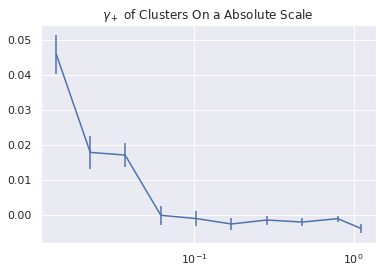

Aggregated xi:
[-6.0734e+01 -5.5726e+01 -8.6651e+01  1.8212e-01  1.6122e+01  7.9129e+01
  7.9996e+01  1.9451e+02  1.7099e+02  3.1544e+02]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -5690.6284 -11854.5548 -16697.2122 -25803.6975 -38821.9805 -56124.0789
 -73491.272  -74360.7274 -40649.6053   8530.988 ]
------------------------------------------------------------------------------
Aggregated npairs:
[  1325.   3116.   5058.   9265.  17065.  31777.  58555. 100000. 175935.
  84824.]
------------------------------------------------------------------------------
Mean xi:
[-4.5837e-02 -1.7884e-02 -1.7131e-02  1.9657e-05  9.4475e-04  2.4901e-03
  1.3662e-03  1.9451e-03  9.7188e-04  3.7188e-03]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2948 -3.8044 -3.3011 -2.7851 -2.2749 -1.7662 -1.2551 -0.7436 -0.231
  0.1006]
-----------------------------------------------------------------------

In [29]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

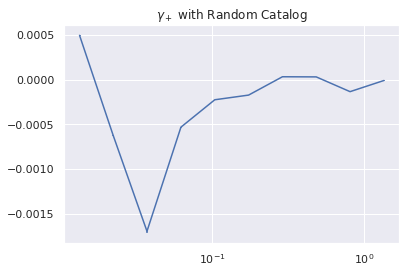

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [30]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

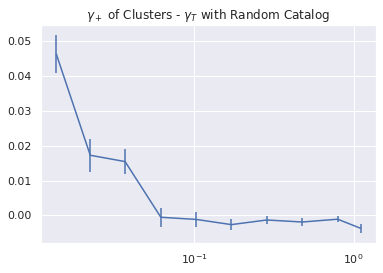

In [31]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

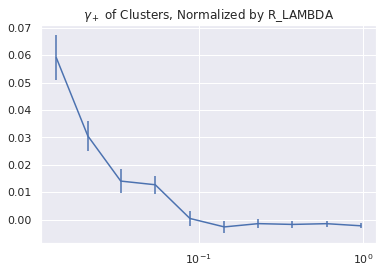

Aggregated xi:
[-32.8182 -58.4973 -48.5036 -72.8778  -4.3636  47.8889  46.2176  98.5286
 135.9108 345.9812]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2386.3854  -7381.2093 -11699.3919 -16661.4907 -24392.7534 -35245.0551
 -46991.6783 -56349.4636 -47735.3247  -5647.2995]
------------------------------------------------------------------------------
Aggregated npairs:
[   555.   1913.   3444.   5719.  10046.  18108.  31970.  56729.  92925.
 154770.]
------------------------------------------------------------------------------
Mean xi:
[-0.0591 -0.0306 -0.0141 -0.0127 -0.0004  0.0026  0.0014  0.0017  0.0015
  0.0022]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2998 -3.8584 -3.397  -2.9134 -2.4281 -1.9464 -1.4699 -0.9933 -0.5137
 -0.0365]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [32]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)